In [ ]:
!pip install -U turicreate
!pip install seaborn
!pip install tensorflow
!pip install -q keras
!pip install deepctr[gpu]

     |████████████████████████████████| 92.0MB 46kB/s 
     |████████████████████████████████| 3.6MB 42.6MB/s 
     |████████████████████████████████| 3.5MB 47.9MB/s 
     |████████████████████████████████| 86.4MB 52kB/s 
     |████████████████████████████████| 327kB 51.5MB/s 
     |████████████████████████████████| 18.3MB 1.2MB/s 
     |████████████████████████████████| 3.8MB 44.9MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 450kB 27.7MB/s 
  Created wheel for resampy: filename=resampy-0.2.1-cp37-none-any.whl size=320845 sha256=937ac5eb4a13d9957636870281469040c93e73d2a31f2b462e87d881a49ee03a
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
  Created wheel for prettytable: filename=prettytable-0.7.2-cp37-none-any.whl size=13700 sha256=49b1e961c578a8d3dbbbacac8d94b8cc4079f54da598f4d83484a8e478fec918
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb5951

     |████████████████████████████████| 122kB 6.4MB/s 
     |████████████████████████████████| 394.3MB 37kB/s 
     |████████████████████████████████| 6.0MB 42.1MB/s 
     |████████████████████████████████| 471kB 41.8MB/s 
     |████████████████████████████████| 4.9MB 39.1MB/s 
ERROR: tensorflow 2.0.4 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow 2.0.4 has requirement tensorboard<2.1.0,>=2.0.0, but you'll have tensorboard 2.5.0 which is incompatible.
ERROR: tensorflow 2.0.4 has requirement tensorflow-estimator<2.1.0,>=2.0.0, but you'll have tensorflow-estimator 2.4.0 which is incompatible.
ERROR: tensorflow-gpu 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Found existing installation: tensorboard 2.0.2
    Uninstalling tensorboard-2.0.2:
      Successfully uninstalled tensorboard-

# E-Commerce - Recommender Systems Assignment
### **Sbmitted by:** 
Itay Bouganim - ID: 305278384

Sahar Vaya - ID: 205583453

In [ ]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict

import turicreate as tc
from turicreate.toolkits.recommender.util import precision_recall_by_user

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Embedding, Input, Dense, Flatten, Dropout, Multiply, Concatenate, Reshape, Lambda, Dot, Add, Activation, Subtract
from tensorflow.keras.optimizers import Adagrad, Adam, SGD, RMSprop, Adamax # maybe remove

from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat, VarLenSparseFeat, get_feature_names

from os.path import join, isdir
from os import mkdir, getcwd

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#### Download dataset

In [ ]:
from urllib.request import urlretrieve
import zipfile

# Download MovieLens 100K dataset.
print("Downloading MovieLens data...")
DATASET_ZIP_PATH = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
DATASET_OUTPUT_DIR = 'ml-100k'

urlretrieve(DATASET_ZIP_PATH, "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done.")

Done.


In [ ]:
def get_file_path(filename):
  return join(DATASET_OUTPUT_DIR, filename)

In [ ]:
print("Dataset contains the following:")
with open(get_file_path('u.info'), 'r') as info_file:
  print(info_file.read())

Dataset contains the following:
943 users
1682 items
100000 ratings



In [ ]:
def decrement_ids(col_name, df):
  '''Used to decrement movie/user id to start from 0'''
  return df[col_name].apply(lambda x: int(x-1))

#### Explore dataset

In [ ]:
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(get_file_path('u.user'), sep='|', names=users_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = decrement_ids('user_id', users)

print(f'User data shape: {users.shape}')
users.head(10)

User data shape: (943, 5)


user_id  age sex     occupation zip_code
0        0   24   M     technician    85711
1        1   53   F          other    94043
2        2   23   M         writer    32067
3        3   24   M     technician    43537
4        4   33   F          other    15213
5        5   42   M      executive    98101
6        6   57   M  administrator    91344
7        7   36   M  administrator    05201
8        8   29   M        student    01002
9        9   53   M         lawyer    90703

In [ ]:
# Load movies dataset
# The movies file contains a binary feature for each genre.
genre_cols = [
    "Unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = ['movie_id', 'title', 'release_date', "video_release_date", "imdb_url"] + genre_cols
movies = pd.read_csv(get_file_path('u.item'), sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
movies["movie_id"] = decrement_ids('movie_id', movies)
movies[genre_cols] = movies[genre_cols].astype(int)
movies['release_date'] = movies['release_date'].fillna('')
movies["year"] = movies['release_date'].apply(lambda x: int(str(x).split('-')[-1]) if x else 0) # Seperate year information about each movie
movies['release_date'] = movies['release_date'].replace('', np.nan)

if movies['video_release_date'].isnull().all():
  movies.drop('video_release_date', axis=1, inplace=True)

print(f'Movie data shape: {movies.shape}')
movies.head(10)

Movie data shape: (1682, 24)


movie_id                                              title  ... Western  year
0         0                                   Toy Story (1995)  ...       0  1995
1         1                                   GoldenEye (1995)  ...       0  1995
2         2                                  Four Rooms (1995)  ...       0  1995
3         3                                  Get Shorty (1995)  ...       0  1995
4         4                                     Copycat (1995)  ...       0  1995
5         5  Shanghai Triad (Yao a yao yao dao waipo qiao) ...  ...       0  1995
6         6                              Twelve Monkeys (1995)  ...       0  1995
7         7                                        Babe (1995)  ...       0  1995
8         8                            Dead Man Walking (1995)  ...       0  1995
9         9                                 Richard III (1995)  ...       0  1996

[10 rows x 24 columns]

In [ ]:
# Load ratings dataset
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(get_file_path('u.data'), sep='\t', names=ratings_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
ratings["movie_id"] = decrement_ids('movie_id', ratings)
ratings["user_id"] = decrement_ids('user_id', ratings)

rating_user_count = ratings["user_id"].drop_duplicates().count()
rated_movie_count = ratings["movie_id"].drop_duplicates().count()

print(f'Rating data shape: {ratings.shape}')
print(f'Rating user count: {rating_user_count}')
print(f'Rated movie count: {rated_movie_count}')
ratings.head(10)

Rating data shape: (100000, 4)
Rating user count: 943
Rated movie count: 1682


user_id  movie_id  rating  unix_timestamp
0      195       241       3       881250949
1      185       301       3       891717742
2       21       376       1       878887116
3      243        50       2       880606923
4      165       345       1       886397596
5      297       473       4       884182806
6      114       264       2       881171488
7      252       464       5       891628467
8      304       450       3       886324817
9        5        85       3       883603013

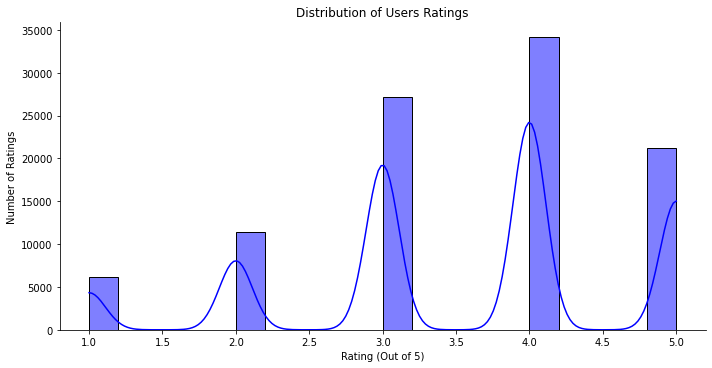

In [ ]:
sns.displot(x=ratings['rating'], bins=20, kde=True, color="b", height=5, aspect=2)
plt.title("Distribution of Users Ratings")
plt.ylabel('Number of Ratings')
plt.xlabel('Rating (Out of 5)')
plt.show()

Observe at the top 20 mean ratings per movie 

In [ ]:
ratings.groupby(by='movie_id')['rating'].mean().sort_values(ascending=False).head(20)

movie_id
1292    5.000000
1466    5.000000
1652    5.000000
813     5.000000
1121    5.000000
1598    5.000000
1200    5.000000
1188    5.000000
1499    5.000000
1535    5.000000
1448    4.625000
1641    4.500000
118     4.500000
1397    4.500000
1593    4.500000
407     4.491071
317     4.466443
168     4.466102
482     4.456790
113     4.447761
Name: rating, dtype: float64

# Question 1 - MovieLens 100K dataset analysis

## Section 1.a.

In [ ]:
def get_average_movie_ratings(ratings_df):
  average_ratings = ratings_df.groupby('movie_id', as_index=False).agg(avg_rating=('rating', 'mean'), count=('rating', 'count')).reset_index() # Average movie ratings
  return pd.merge(average_ratings, movies, on='movie_id')[['movie_id', 'avg_rating', 'title', 'count']]

def plot_ratings_histogram(title, df_col, bins=10, df_col2=None, col1_name='', col2_name='', x_name=''):
  if df_col2 is None:
    sns.displot(x=df_col, bins=10, kde=True, color="b", height=5, aspect=2)
    plt.xlabel('Average Rating', fontsize=12)
    plt.ylabel('Movie Count', fontsize=12)
    plt.title(title) 
    plt.show()
  else:
    data = [(col1_name, val) for val in df_col.values] + [(col2_name, val) for val in df_col2.values]
    data = pd.DataFrame(data=data, columns=['Data', x_name])
    p = sns.displot(data=data, x=x_name, hue='Data', kind='kde', fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5)
    p.fig.suptitle(title, fontsize=15)
    p.fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
average_ratings = get_average_movie_ratings(ratings_df=ratings)
average_ratings.head(10)

movie_id  ...  count
0         0  ...    452
1         1  ...    131
2         2  ...     90
3         3  ...    209
4         4  ...     86
5         5  ...     26
6         6  ...    392
7         7  ...    219
8         8  ...    299
9         9  ...     89

[10 rows x 4 columns]

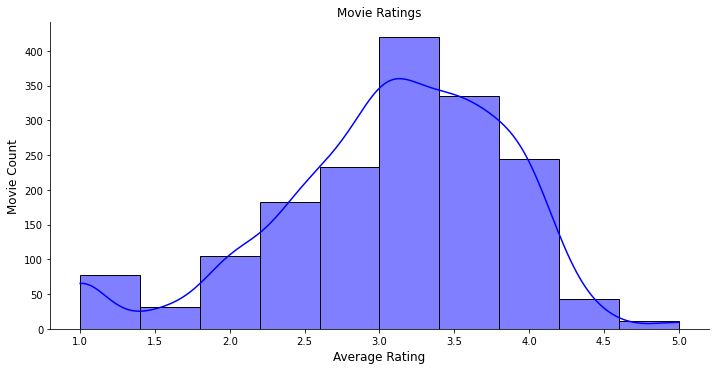

In [ ]:
plot_ratings_histogram(df_col=average_ratings['avg_rating'], title='Movie Ratings')

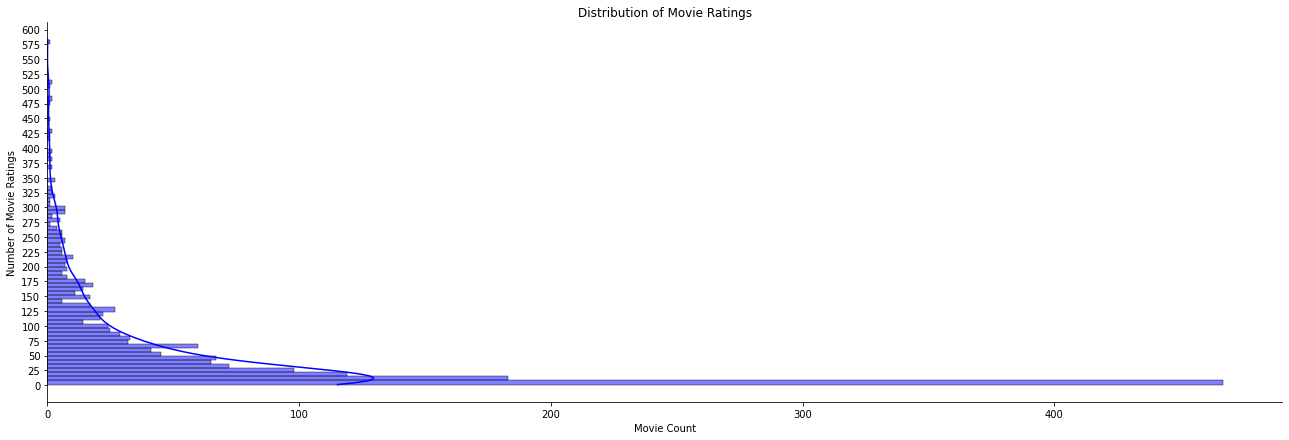

In [ ]:
no_of_ratings_per_movie = ratings.groupby('movie_id')['rating'].count().sort_values(ascending=False)

ax = sns.displot(y=no_of_ratings_per_movie, bins=np.ceil(len(no_of_ratings_per_movie) / 20).astype(np.int32), kde=True, color="b", height=6, aspect=3)
plt.title("Distribution of Movie Ratings")
plt.ylabel('Number of Movie Ratings')
plt.xlabel('Movie Count')
plt.yticks(np.arange(0, max(no_of_ratings_per_movie) + 25, 25))
plt.show()

In [ ]:
average_ratings.sort_values(['avg_rating', 'count'], ascending=(False, False), inplace=True)
average_ratings.head(3)

movie_id  avg_rating                                 title  count
1188      1188         5.0                    Prefontaine (1997)      3
1292      1292         5.0                       Star Kid (1997)      3
1466      1466         5.0  Saint of Fort Washington, The (1993)      2

In [ ]:
user_ratings = pd.merge(users, ratings, on='user_id')

## Section 1.b.

### Male average movie ratings

In [ ]:
male_ratings = user_ratings.query('sex == "M"')[['movie_id', 'rating']]
average_male_ratings = get_average_movie_ratings(ratings_df=male_ratings)
average_male_ratings.head(10)

movie_id  ...  count
0         0  ...    333
1         1  ...    112
2         2  ...     74
3         3  ...    164
4         4  ...     64
5         5  ...     21
6         6  ...    310
7         7  ...    159
8         8  ...    216
9         9  ...     69

[10 rows x 4 columns]

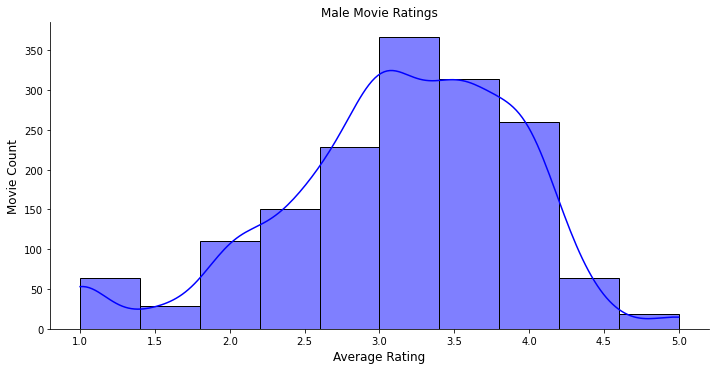

In [ ]:
plot_ratings_histogram(df_col=average_male_ratings['avg_rating'], title='Male Movie Ratings')

In [ ]:
average_male_ratings.sort_values(['avg_rating', 'count'], ascending=(False, False), inplace=True)
average_male_ratings.head(3)

movie_id  avg_rating               title  count
1290      1292         5.0     Star Kid (1997)      3
1172      1174         5.0    Hugo Pool (1997)      2
1186      1188         5.0  Prefontaine (1997)      2

### Female average movie ratings

In [ ]:
female_ratings = user_ratings.query('sex == "F"')[['movie_id', 'rating']]
average_female_ratings = get_average_movie_ratings(ratings_df=female_ratings)
average_female_ratings.head(10)

movie_id  ...  count
0         0  ...    119
1         1  ...     19
2         2  ...     16
3         3  ...     45
4         4  ...     22
5         5  ...      5
6         6  ...     82
7         7  ...     60
8         8  ...     83
9         9  ...     20

[10 rows x 4 columns]

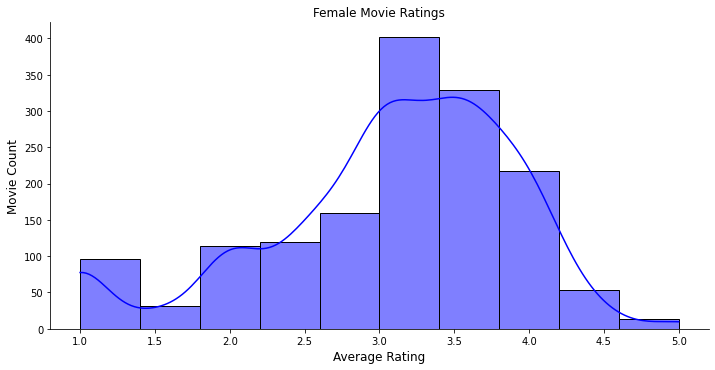

In [ ]:
plot_ratings_histogram(df_col=average_female_ratings['avg_rating'], title='Female Movie Ratings')

In [ ]:
average_female_ratings.sort_values(['avg_rating', 'count'], ascending=(False, False), inplace=True)
average_female_ratings.head(3)


movie_id  avg_rating                                   title  count
1302      1367         5.0                  Mina Tannenbaum (1994)      2
73          73         5.0     Faster Pussycat! Kill! Kill! (1965)      1
117        118         5.0  Maya Lin: A Strong Clear Vision (1994)      1

### Male-Female average movie ratings difference

In [ ]:
male_female_average_ratings = pd.merge(average_male_ratings, average_female_ratings, on='movie_id', suffixes=('_male', '_female'))
male_female_average_ratings.drop('title_male', 1, inplace=True)
male_female_average_ratings.rename(columns={'title_female': 'title'}, inplace=True)

male_female_average_ratings['rating_abs_diff']  = male_female_average_ratings.apply(lambda row: abs(row['avg_rating_male'] - row['avg_rating_female']), axis=1)

In [ ]:
male_female_average_ratings.sort_values(['rating_abs_diff', 'count_female', 'count_male'], ascending=False, inplace=True)
male_female_average_ratings.head(10)

movie_id  avg_rating_male  ...  count_female  rating_abs_diff
5         1305         5.000000  ...             1         4.000000
8          850         4.666667  ...             1         3.666667
11        1428         4.500000  ...             2         3.500000
19         640         4.419355  ...             2         3.419355
53        1591         4.250000  ...             1         3.250000
169       1274         4.000000  ...             2         3.000000
1433       838         1.000000  ...             2         3.000000
1435      1025         1.000000  ...             2         3.000000
162       1557         4.000000  ...             1         3.000000
166        625         4.000000  ...             1         3.000000

[10 rows x 7 columns]

Include only movies that are above the average amount of raters according to male and female raters.

In [ ]:
mean_count_per_movie_male = np.mean(male_female_average_ratings['count_male'])
mean_count_per_movie_female = np.mean(male_female_average_ratings['count_female'])
male_female_average_ratings['above_mean_count']  = male_female_average_ratings.apply(lambda row: row['count_male'] >= mean_count_per_movie_male and row['count_female'] >= mean_count_per_movie_female, axis=1)

male_female_average_ratings.sort_values(['above_mean_count', 'rating_abs_diff'], ascending=False, inplace=True)
male_female_average_ratings.head(10)

movie_id  avg_rating_male  ...  rating_abs_diff  above_mean_count
1090       719         2.746032  ...         1.036577              True
1073       154         2.774194  ...         0.892473              True
47         524         4.250000  ...         0.773810              True
1091       475         2.742574  ...         0.748951              True
91         155         4.127119  ...         0.693785              True
314        692         3.791667  ...         0.686404              True
981        553         2.927711  ...         0.664553              True
440        484         3.602410  ...         0.635686              True
1190        28         2.538462  ...         0.635452              True
809          4         3.140625  ...         0.632102              True

[10 rows x 8 columns]

## Section 1.c.

In [ ]:
def get_low_high_rated_by_percentile(movie_ratings_df, percentile):
  upper_qunatile = movie_ratings_df['avg_rating'].quantile(1 - percentile)
  lower_qunatile = movie_ratings_df['avg_rating'].quantile(percentile)
  high_rated_movies = movie_ratings_df.loc[movie_ratings_df['avg_rating'] >= upper_qunatile]
  low_rated_movies = movie_ratings_df.loc[movie_ratings_df['avg_rating'] <= lower_qunatile]
  return high_rated_movies, upper_qunatile, low_rated_movies, lower_qunatile

In [ ]:
def get_low_high_genere_distibution(movie_ratings_df):
  high_rated_movies, high_rating, low_rated_movies, low_rating = get_low_high_rated_by_percentile(movie_ratings_df, percentile=0.2) # 20% highest and 20% lowest
  high_rated_dict = {}
  low_rated_dict = {}
  for genre in genre_cols:
    high_rated_genere = high_rated_movies.apply(lambda x: True if x[genre] == 1 else False , axis=1)
    low_rated_genere = low_rated_movies.apply(lambda x: True if x[genre] == 1 else False , axis=1)
    num_of_row_high_rated = len(high_rated_genere[high_rated_genere == True])
    num_of_row_low_rated = len(low_rated_genere[low_rated_genere == True])
    high_rated_dict[genre] = num_of_row_high_rated
    low_rated_dict[genre] = num_of_row_low_rated
  return (high_rated_dict, high_rating), (low_rated_dict, low_rating)

In [ ]:
def plot_low_high_genere_distribution_histogram(low_rated, low_rating, high_rated, high_rating, title):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(33, 10))
  genere_ratings = {'High': (pd.DataFrame(high_rated.items()), high_rating), 'Low': (pd.DataFrame(low_rated.items()), low_rating)}
  for i, ax in enumerate(axes):
    sns.barplot(x=0, y=1, data=list(genere_ratings.values())[i][0], ax=ax)
    for p in ax.patches:
        height = p.get_height() # get bar height
        ax.text(p.get_x() + p.get_width() / 2,
                  height + p.get_y(), 
                  f'{int(height)}',
                  ha = 'center',   # horizontal alignment
                  va = 'bottom')  # vertical alignment
    ax.set(xlabel = 'Genre', ylabel='Count', title=f'{list(genere_ratings.keys())[i]} Ratings ({list(genere_ratings.values())[i][1]})')
  fig.suptitle(f'High/Low Rated Movies By Genere - {title}', fontsize=20)
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])

Highly rated total: (Above or equal 3.75): 606
Lower rated total: (Below or equal 2.5): 542


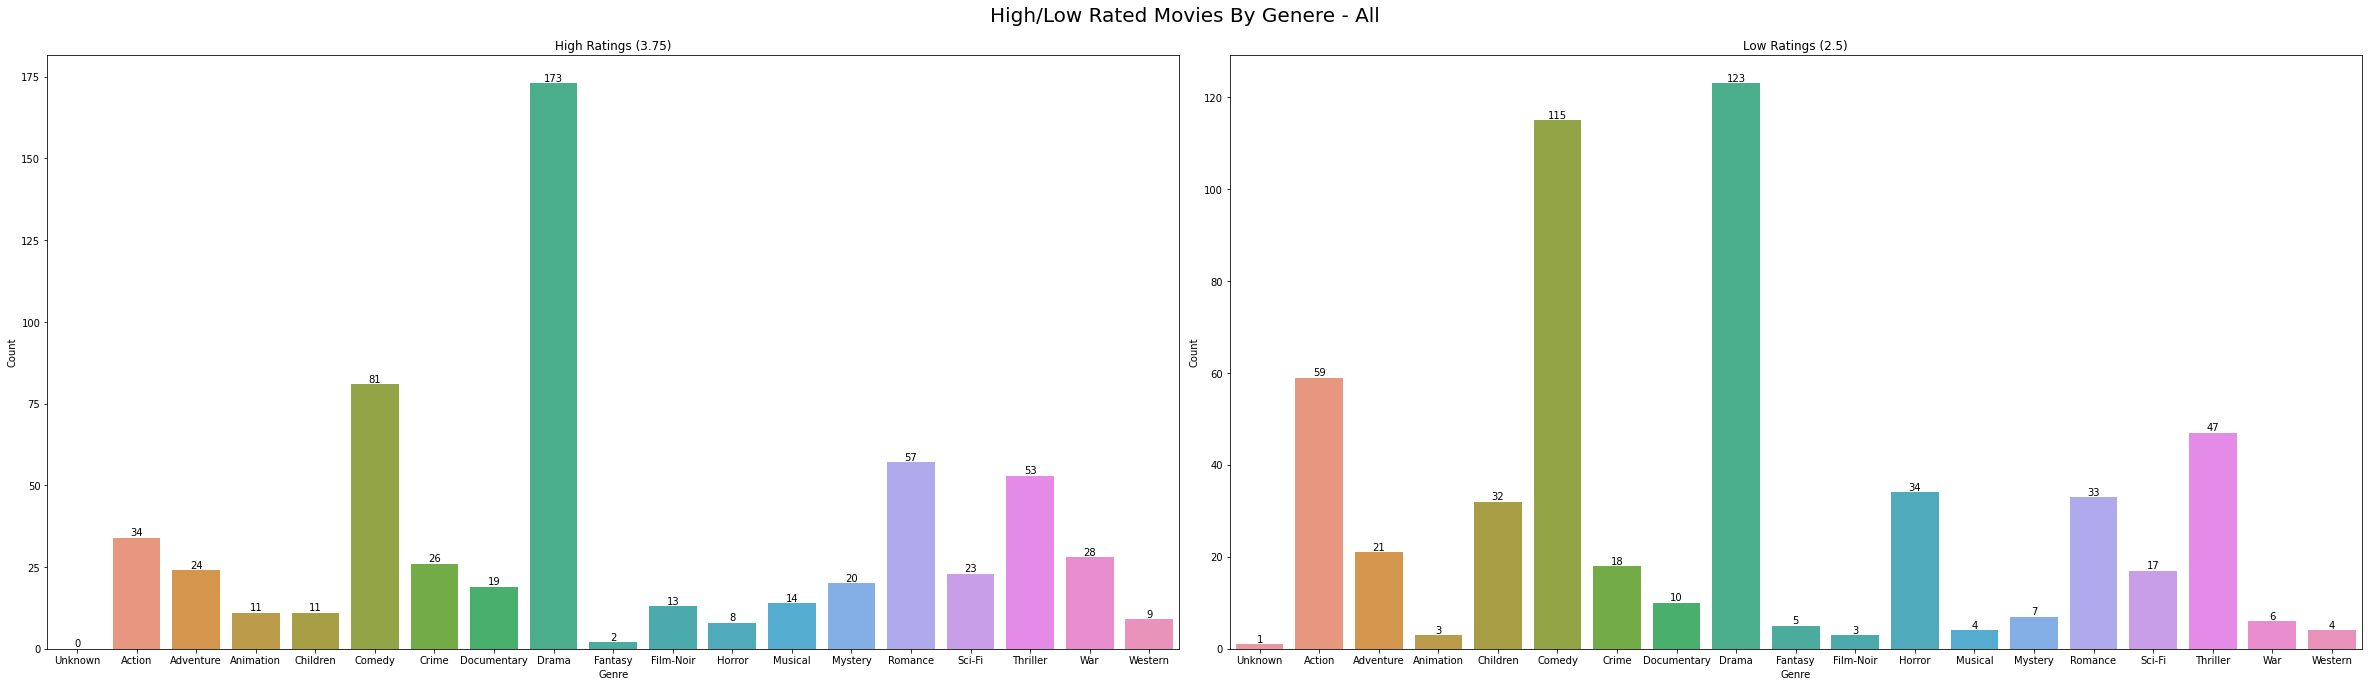

In [ ]:
average_ratings_with_genre = pd.merge(average_ratings, movies, on='movie_id')
(high_rated_dict_all, high_rating), (low_rated_dict_all, low_rating) = get_low_high_genere_distibution(average_ratings_with_genre)
plot_low_high_genere_distribution_histogram(low_rated=low_rated_dict_all, low_rating=low_rating, high_rated=high_rated_dict_all, high_rating=high_rating, title='All')

print(f'Highly rated total: (Above or equal {high_rating}): {sum(high_rated_dict_all.values())}')
print(f'Lower rated total: (Below or equal {low_rating}): {sum(low_rated_dict_all.values())}')

Highly rated total: (Above or equal 3.8333333333333335): 557
Lower rated total: (Below or equal 2.5): 517


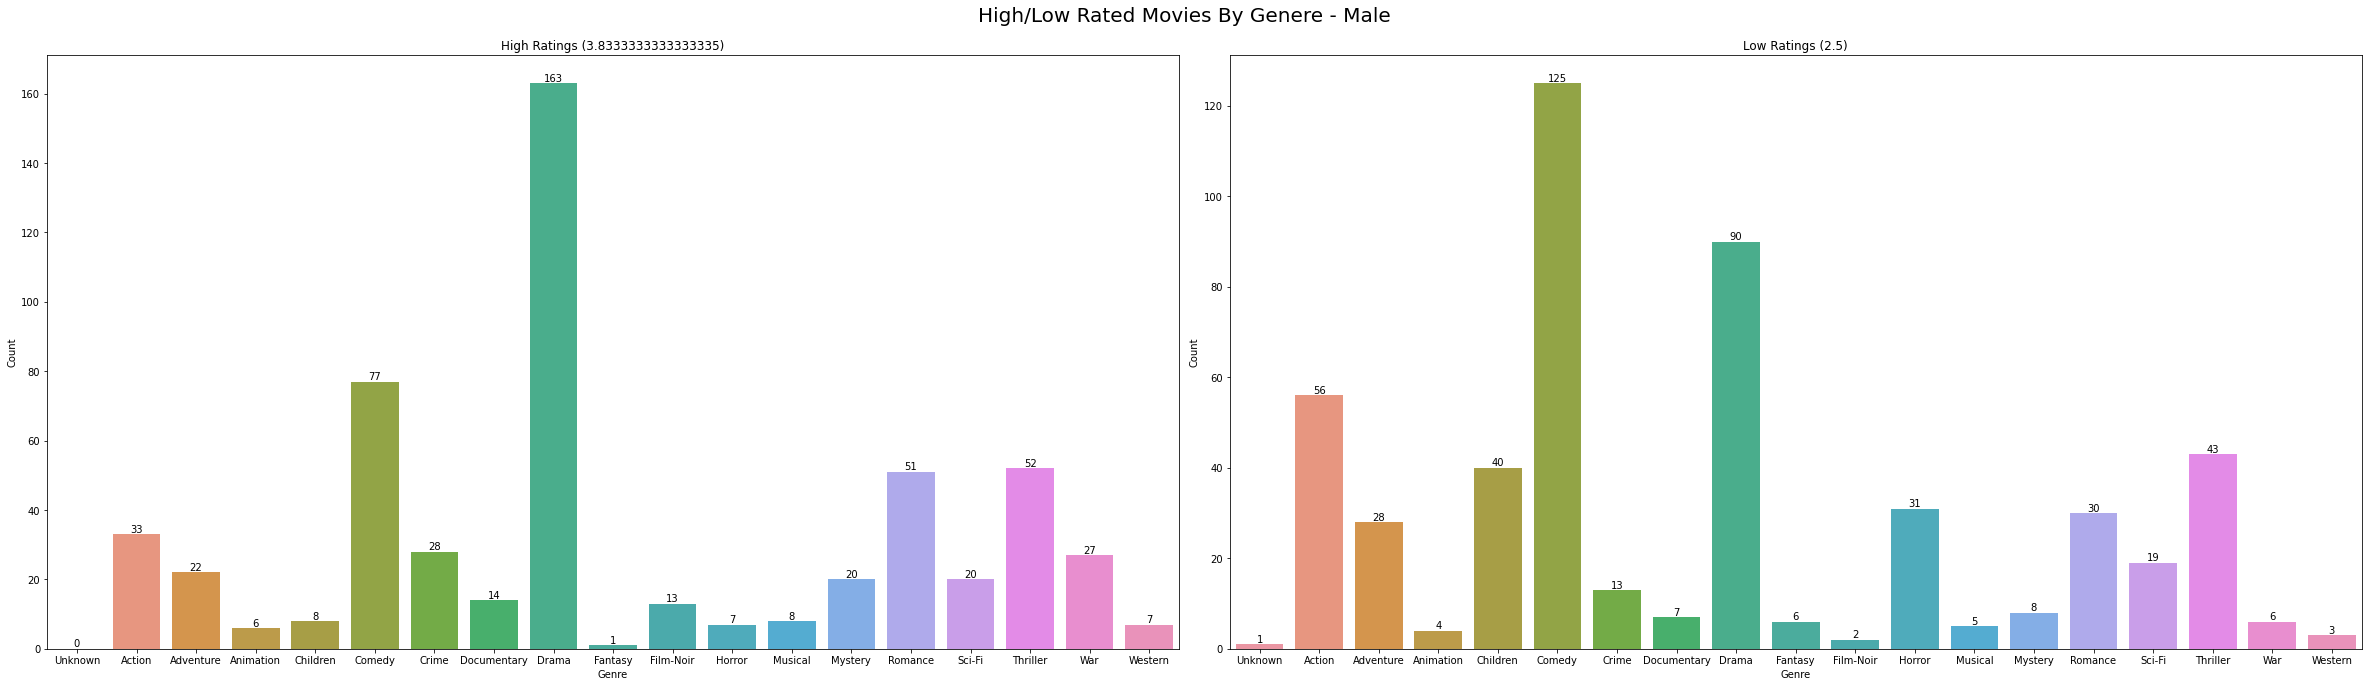

In [ ]:
average_ratings_with_genre = pd.merge(average_male_ratings, movies, on='movie_id')
(high_rated_dict_all, high_rating), (low_rated_dict_all, low_rating) = get_low_high_genere_distibution(average_ratings_with_genre)
plot_low_high_genere_distribution_histogram(low_rated=low_rated_dict_all, low_rating=low_rating, high_rated=high_rated_dict_all, high_rating=high_rating, title='Male')

print(f'Highly rated total: (Above or equal {high_rating}): {sum(high_rated_dict_all.values())}')
print(f'Lower rated total: (Below or equal {low_rating}): {sum(low_rated_dict_all.values())}')

Highly rated total: (Above or equal 3.7681574239713775): 539
Lower rated total: (Below or equal 2.5): 523


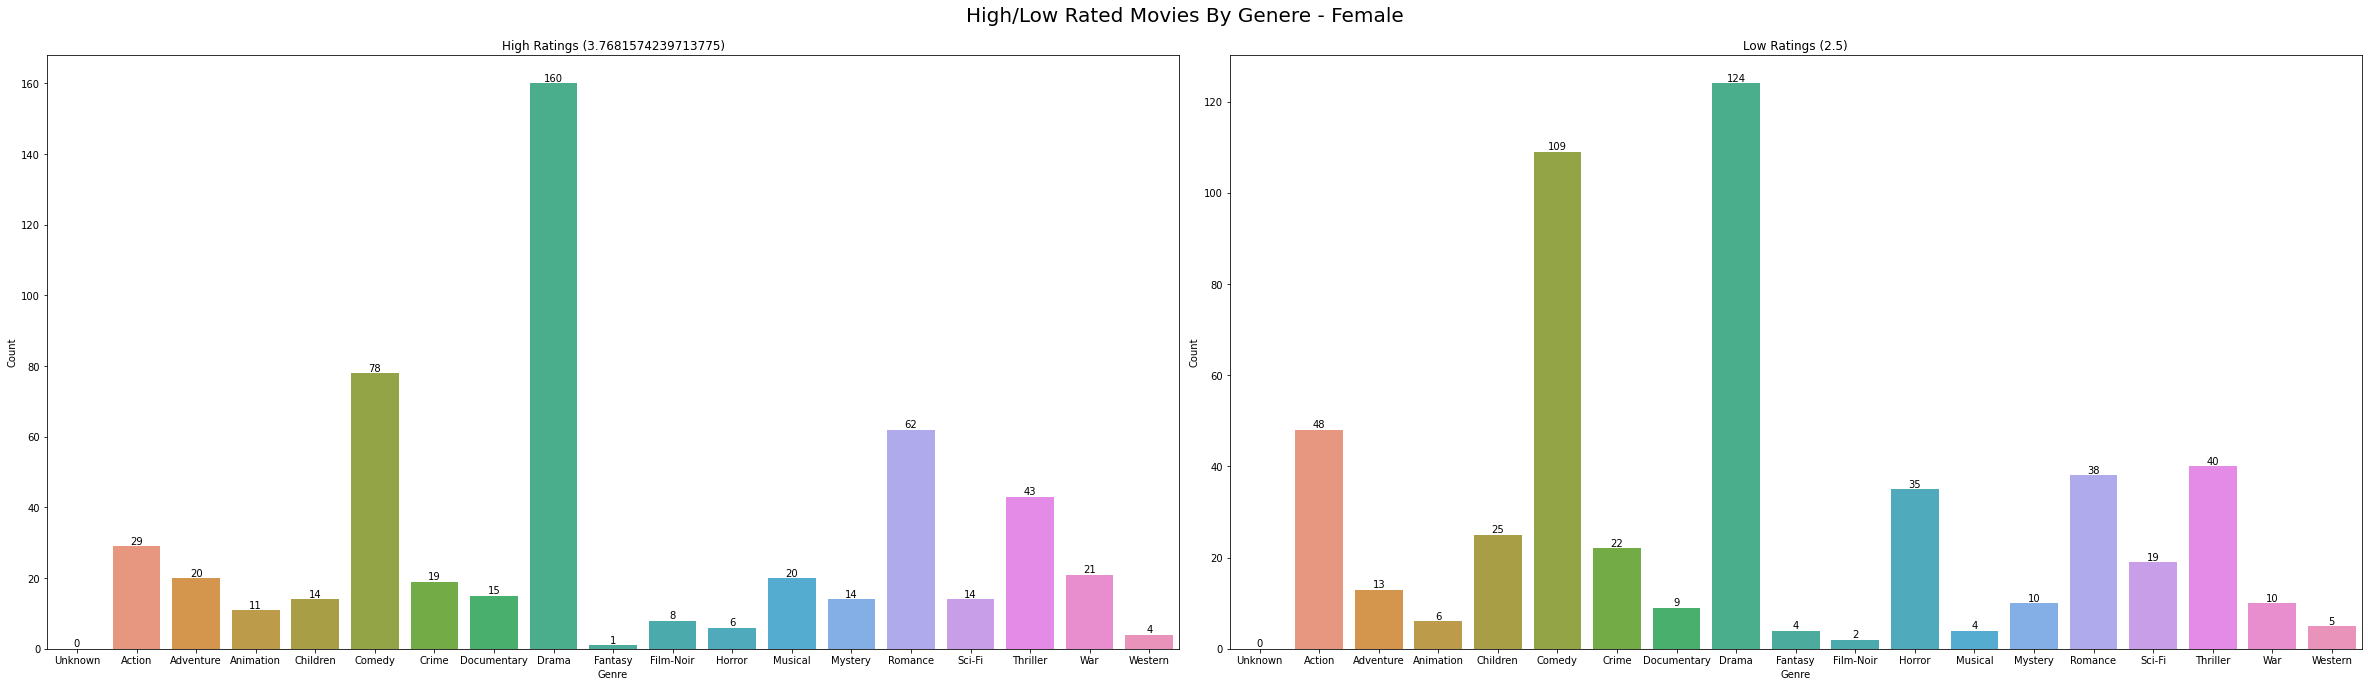

In [ ]:
average_ratings_with_genre = pd.merge(average_female_ratings, movies, on='movie_id')
(high_rated_dict_all, high_rating), (low_rated_dict_all, low_rating) = get_low_high_genere_distibution(average_ratings_with_genre)
plot_low_high_genere_distribution_histogram(low_rated=low_rated_dict_all, low_rating=low_rating, high_rated=high_rated_dict_all, high_rating=high_rating, title='Female')

print(f'Highly rated total: (Above or equal {high_rating}): {sum(high_rated_dict_all.values())}')
print(f'Lower rated total: (Below or equal {low_rating}): {sum(low_rated_dict_all.values())}')

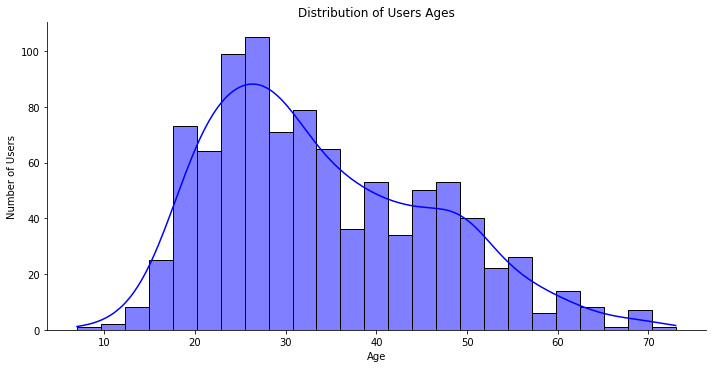

In [ ]:
sns.displot(x=users['age'], bins=25, kde=True, color="b", height=5, aspect=2)
plt.title("Distribution of Users Ages")
plt.ylabel('Number of Users')
plt.xlabel('Age')
plt.show()

In [ ]:
ages = user_ratings['age']
max_age = max(ages)
min_age = min(ages)
age_groups = {'kids': (min_age, 13), 'teens': (14, 21), 'adults': (22, 65), 'elder': (66, max_age)}

kids_ratings = user_ratings.query(f'age >= {age_groups["kids"][0]} and age <= {age_groups["kids"][1]}')[['movie_id', 'rating']]
average_kids_ratings = get_average_movie_ratings(ratings_df=kids_ratings)

teens_ratings = user_ratings.query(f'age >= {age_groups["teens"][0]} and age <= {age_groups["teens"][1]}')[['movie_id', 'rating']]
average_teens_ratings = get_average_movie_ratings(ratings_df=teens_ratings)

adults_ratings = user_ratings.query(f'age >= {age_groups["adults"][0]} and age <= {age_groups["adults"][1]}')[['movie_id', 'rating']]
average_adults_ratings = get_average_movie_ratings(ratings_df=adults_ratings)

elder_ratings = user_ratings.query(f'age >= {age_groups["elder"][0]} and age <= {age_groups["elder"][1]}')[['movie_id', 'rating']]
average_elder_ratings = get_average_movie_ratings(ratings_df=elder_ratings)


Highly rated total: (Above or equal 4.0): 469
Lower rated total: (Below or equal 3.0): 422


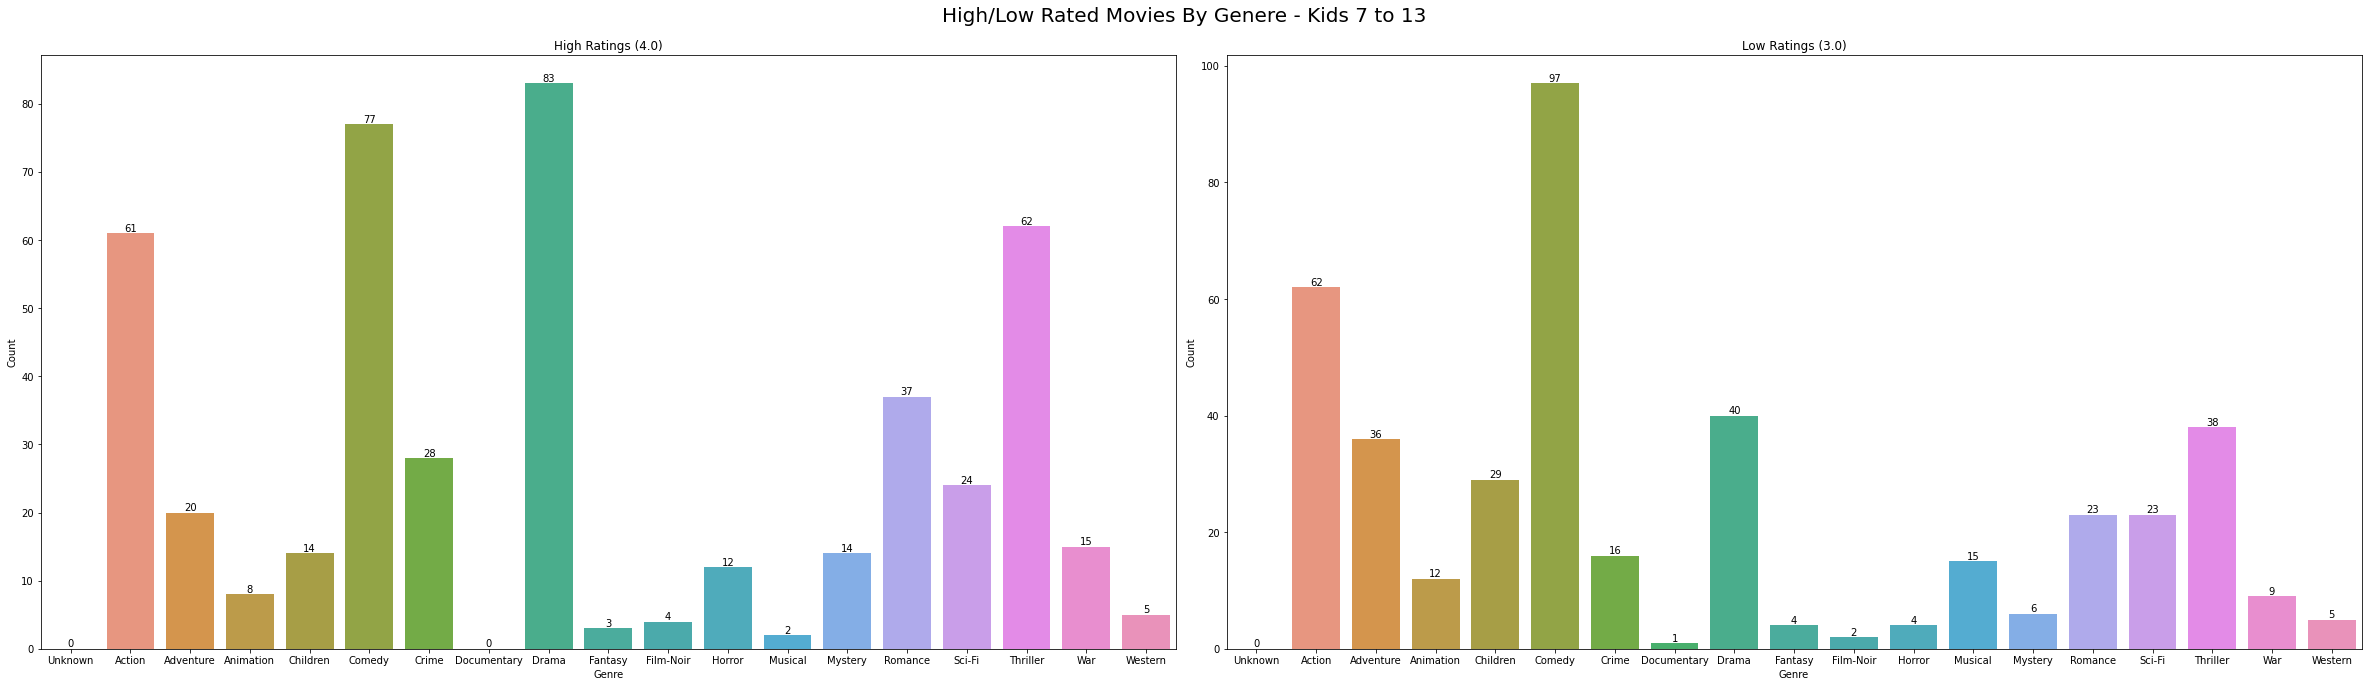

In [ ]:
average_ratings_with_genre = pd.merge(average_kids_ratings, movies, on='movie_id')
(high_rated_dict_all, high_rating), (low_rated_dict_all, low_rating) = get_low_high_genere_distibution(average_ratings_with_genre)
plot_low_high_genere_distribution_histogram(low_rated=low_rated_dict_all, low_rating=low_rating, high_rated=high_rated_dict_all, high_rating=high_rating, title=f'Kids {age_groups["kids"][0]} to {age_groups["kids"][1]}')

print(f'Highly rated total: (Above or equal {high_rating}): {sum(high_rated_dict_all.values())}')
print(f'Lower rated total: (Below or equal {low_rating}): {sum(low_rated_dict_all.values())}')

Highly rated total: (Above or equal 4.0): 523
Lower rated total: (Below or equal 2.5): 454


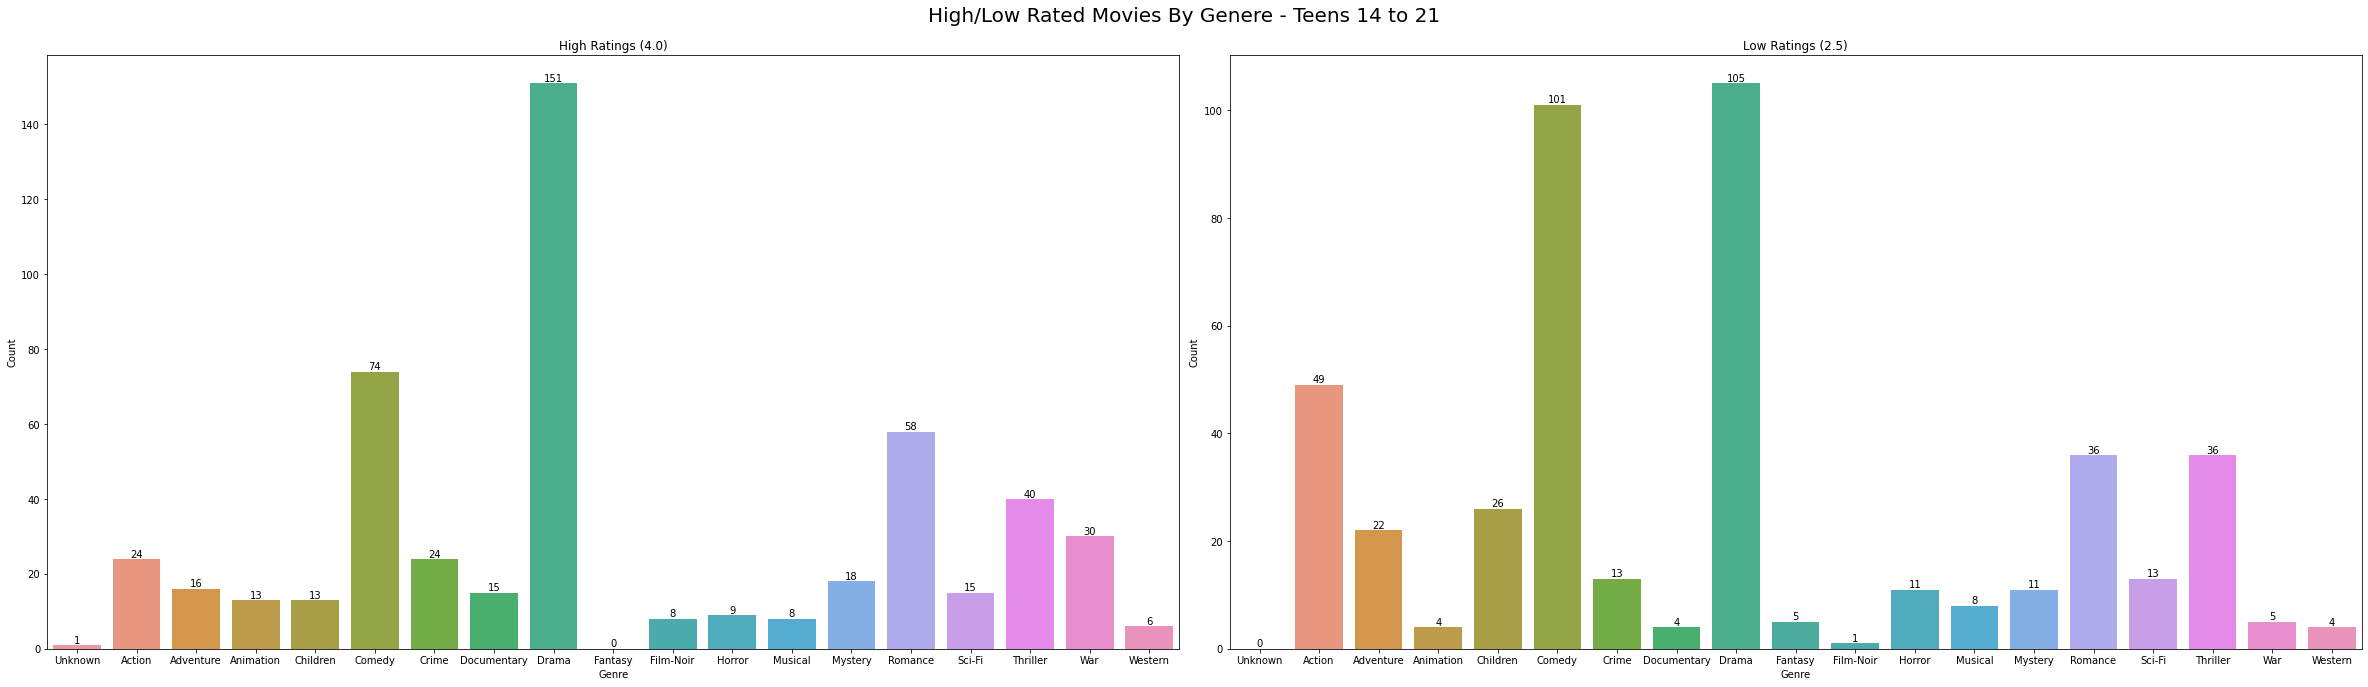

In [ ]:
average_ratings_with_genre = pd.merge(average_teens_ratings, movies, on='movie_id')
(high_rated_dict_all, high_rating), (low_rated_dict_all, low_rating) = get_low_high_genere_distibution(average_ratings_with_genre)
plot_low_high_genere_distribution_histogram(low_rated=low_rated_dict_all, low_rating=low_rating, high_rated=high_rated_dict_all, high_rating=high_rating, title=f'Teens {age_groups["teens"][0]} to {age_groups["teens"][1]}')

print(f'Highly rated total: (Above or equal {high_rating}): {sum(high_rated_dict_all.values())}')
print(f'Lower rated total: (Below or equal {low_rating}): {sum(low_rated_dict_all.values())}')

Highly rated total: (Above or equal 3.772803666921314): 584
Lower rated total: (Below or equal 2.5): 547


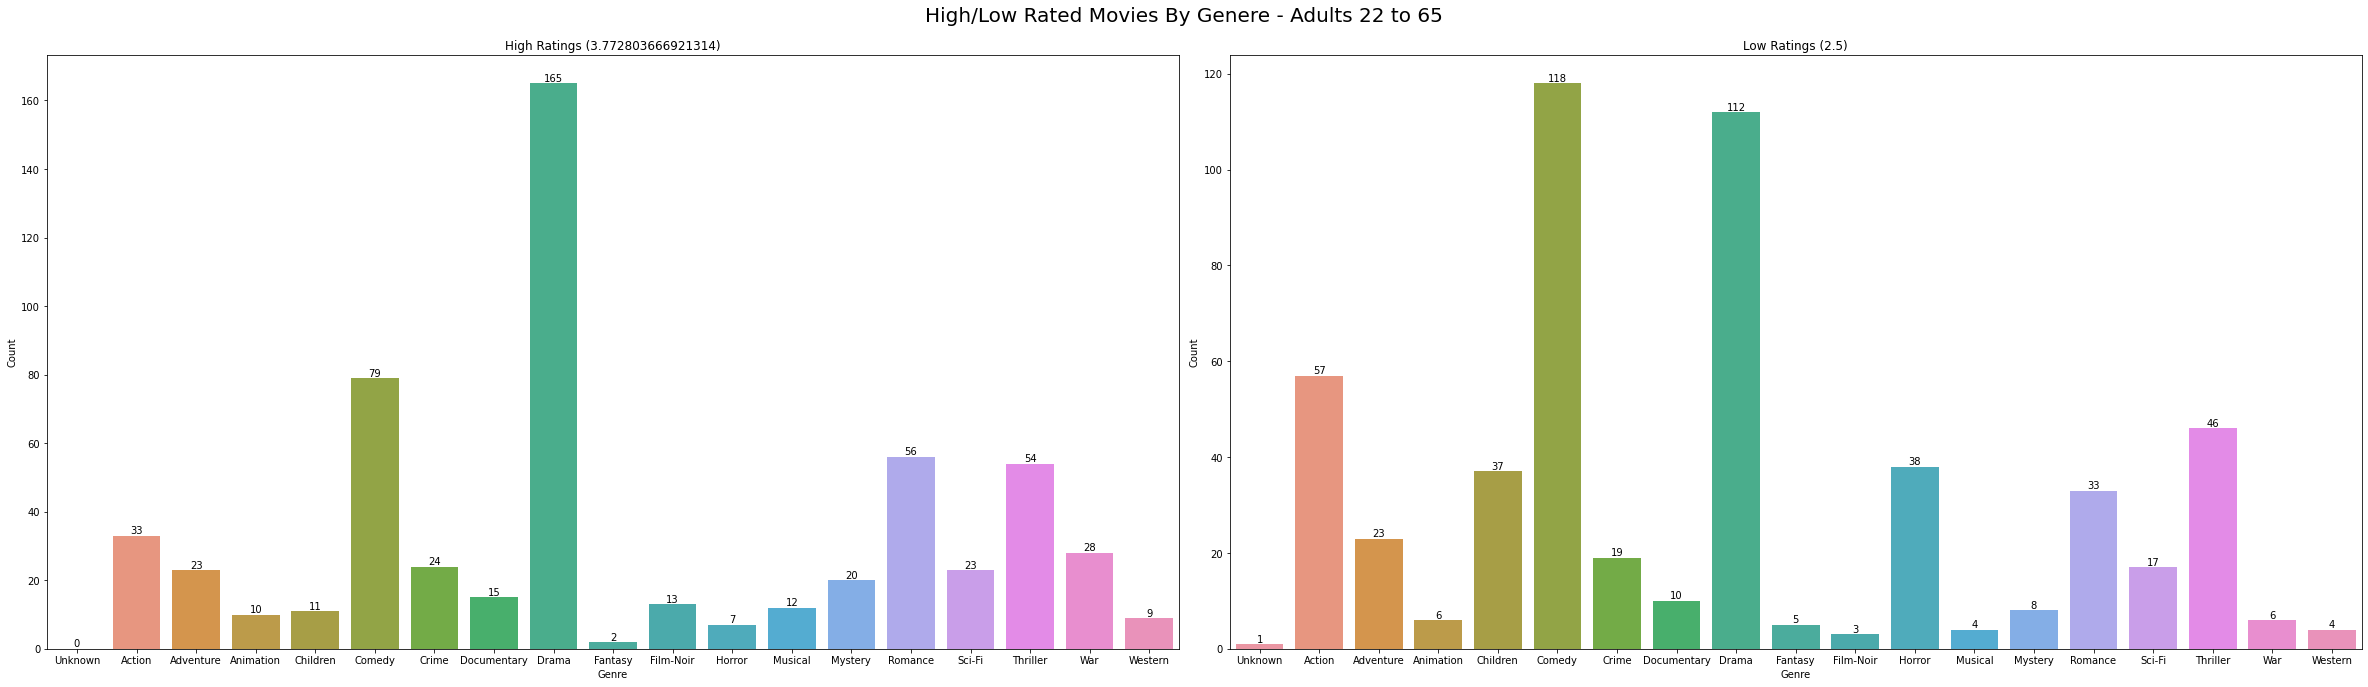

In [ ]:
average_ratings_with_genre = pd.merge(average_adults_ratings, movies, on='movie_id')
(high_rated_dict_all, high_rating), (low_rated_dict_all, low_rating) = get_low_high_genere_distibution(average_ratings_with_genre)
plot_low_high_genere_distribution_histogram(low_rated=low_rated_dict_all, low_rating=low_rating, high_rated=high_rated_dict_all, high_rating=high_rating, title=f'Adults {age_groups["adults"][0]} to {age_groups["adults"][1]}')

print(f'Highly rated total: (Above or equal {high_rating}): {sum(high_rated_dict_all.values())}')
print(f'Lower rated total: (Below or equal {low_rating}): {sum(low_rated_dict_all.values())}')

Highly rated total: (Above or equal 4.0): 330
Lower rated total: (Below or equal 3.0): 254


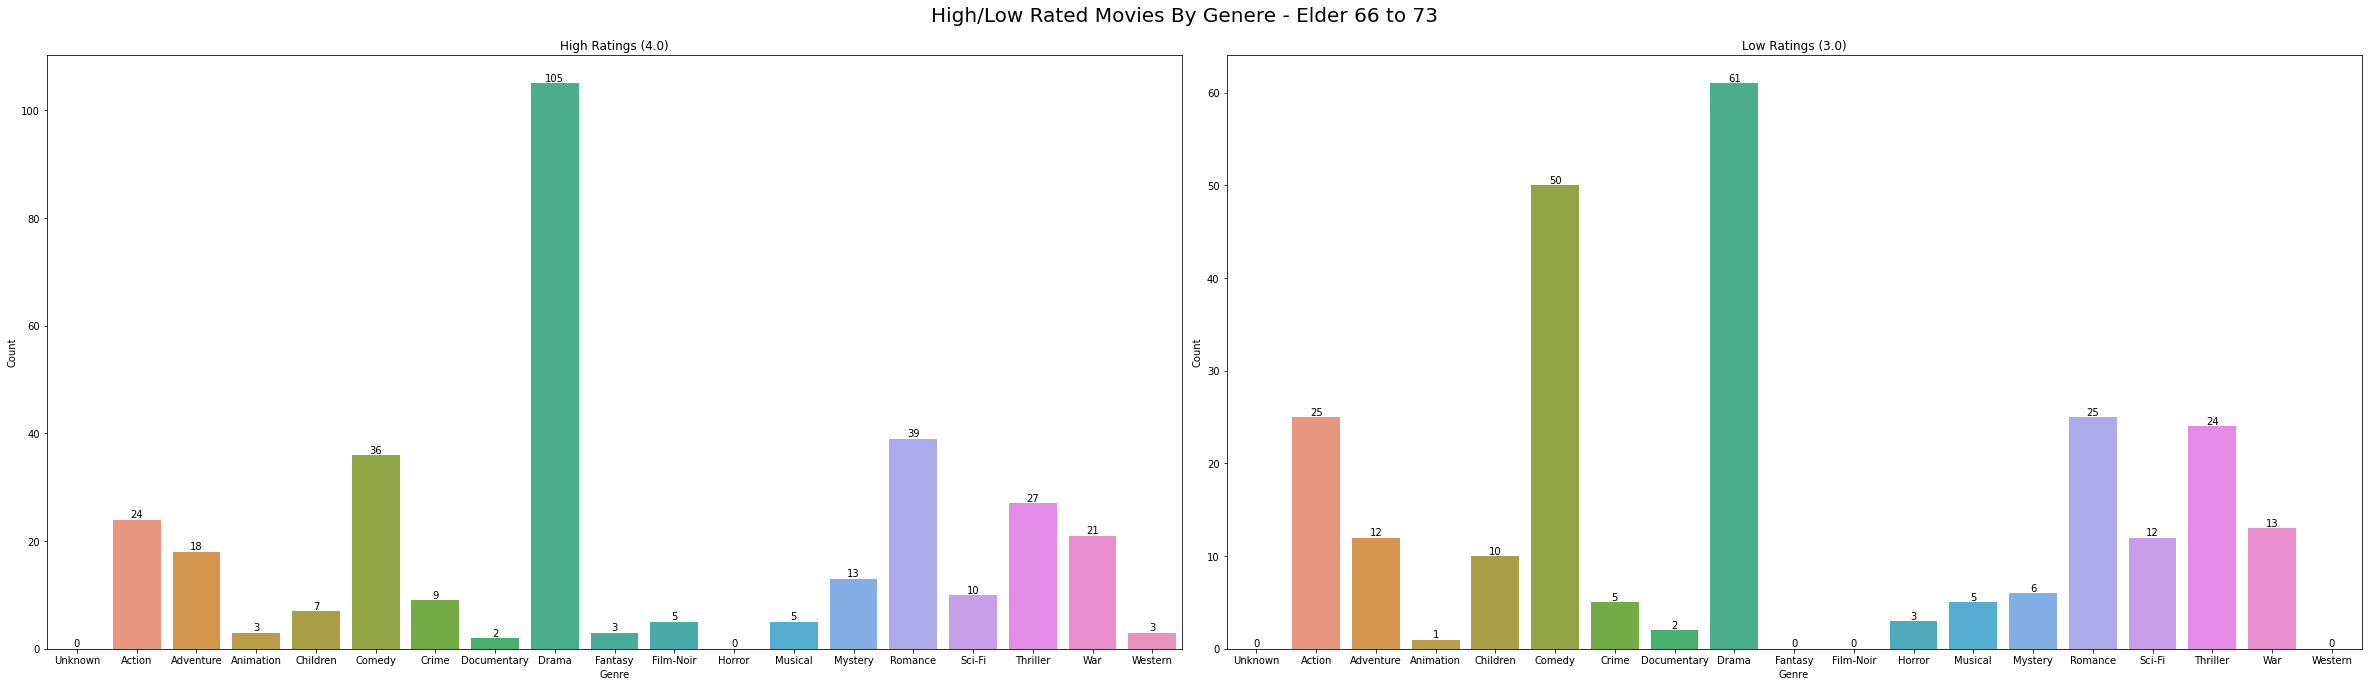

In [ ]:
average_ratings_with_genre = pd.merge(average_elder_ratings, movies, on='movie_id')
(high_rated_dict_all, high_rating), (low_rated_dict_all, low_rating) = get_low_high_genere_distibution(average_ratings_with_genre)
plot_low_high_genere_distribution_histogram(low_rated=low_rated_dict_all, low_rating=low_rating, high_rated=high_rated_dict_all, high_rating=high_rating, title=f'Elder {age_groups["elder"][0]} to {age_groups["elder"][1]}')

print(f'Highly rated total: (Above or equal {high_rating}): {sum(high_rated_dict_all.values())}')
print(f'Lower rated total: (Below or equal {low_rating}): {sum(low_rated_dict_all.values())}')

## Section 1.d.

#### Movie Popularity calculation
The formula as used in IMDB for calculating the Top Rated movies gives a true Bayesian estimate: 

weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C 

where:

- v is the number of ratings for the movie.
- m is the minimum ratings required to be listed in the chart.
- R is the average rating of the movie.
- C is the mean ratings across the whole data.

In [ ]:
rating_counts = ratings.groupby('movie_id', as_index=False)['movie_id'].agg({'rating_count':'count'})
m = round(rating_counts['rating_count'].quantile(0.9)) # We take the top 90 precentile of rating count per movie 
C = average_ratings.mean()[['avg_rating']]

def weighted_rating(row):
    v = row['rating_count']
    R = row['avg_rating'] # rating average per movie
    return (v / (v + m) * R) + (m / (m + v) * C)

In [ ]:
# Filter to include only movies that their rating count is above the threshold m
qualified = pd.merge(average_ratings, rating_counts[rating_counts['rating_count'] >= m], on='movie_id')

# Calculate popularity rating for each movie of the qualified movies
qualified['popularity'] = qualified.apply(weighted_rating, axis=1)
qualified.sort_values('popularity', ascending=False, inplace=True)
qualified

movie_id  avg_rating  ... rating_count  popularity
5          49    4.358491  ...          583    4.070281
0         317    4.466443  ...          298    3.963279
2          63    4.445230  ...          283    3.933300
11        126    4.283293  ...          413    3.932735
9          97    4.289744  ...          390    3.922811
..        ...         ...  ...          ...         ...
165       545    3.031496  ...          254    3.049294
166       288    2.980695  ...          259    3.018345
167       322    2.933333  ...          240    2.992302
168       234    2.847926  ...          217    2.947802
169       677    2.808219  ...          219    2.924875

[170 rows x 6 columns]

## Section 1.e.

#### MovieLens 100K dataset Sparsity

In [ ]:
sparsity = 1 - len(ratings) / (len(users) * len(movies))
print(f'Sparsity: {sparsity}')
print(f'Sparsity %: {(sparsity * 100):.4f}%')

Sparsity: 0.9369533063577546
Sparsity %: 93.6953%


Observe at the top rating users and their rating count

In [ ]:
unique_users = len(users['user_id'].unique())
unique_rating_users = len(ratings['user_id'].unique())

# Test that each user in the dataset rated at least one or more movies
assert unique_users == unique_rating_users
no_of_rated_movies_per_user = ratings.groupby(by='user_id')['rating'].count().sort_values(ascending=False)
no_of_rated_movies_per_user.head(10)

user_id
404    737
654    685
12     636
449    540
275    518
415    493
536    490
302    484
233    480
392    448
Name: rating, dtype: int64

#### Mean ratings per user in the dataset
Calculate the mean ratings per user in the entire dataset

In [ ]:
print(no_of_rated_movies_per_user.describe())
ratings_per_user_avg = round(ratings.groupby('user_id').agg('size').mean())
print(f'\nAverage rating count per user: {ratings_per_user_avg}')

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: rating, dtype: float64

Average rating count per user: 106


#### Explore how the top rating users rated the top rated movies

In [ ]:
user_rating_count = ratings.groupby('user_id')['rating'].count()
top_users = user_rating_count.sort_values(ascending=False)[:15] # 15 Most rating users

movie_rating_count = ratings.groupby('movie_id')['rating'].count()
top_movies = movie_rating_count.sort_values(ascending=False)[:15] # 15 Most rated movies

# Attach movie id to movie title
movie_titles = pd.merge(top_movies, movies, on='movie_id')

top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='user_id')
top_r = top_r.join(movie_titles, rsuffix='_r', how='inner', on='movie_id')
pd.crosstab(top_r.user_id, top_r.title, top_r.rating, aggfunc=np.sum).fillna('-')

title   Air Force One (1997)  ... Twelve Monkeys (1995)
user_id                       ...                      
6                          5  ...                     -
12                         3  ...                     4
180                        4  ...                     1
233                        3  ...                     3
275                        5  ...                     4
278                        -  ...                     -
302                        5  ...                     -
392                        4  ...                     -
404                        -  ...                     -
415                        5  ...                     4
428                        -  ...                     -
449                        -  ...                     -
536                        -  ...                     4
654                        3  ...                     3
845                        -  ...                     -

[15 rows x 15 columns]

# Question 2 - Non-Personal recommendations

In [ ]:
def plot_model_loss_comparison(losses, plot_title, high=False):
  '''Plots model MAE and RMSE loss values by the provided dict'''
  mae = {k: s['mae'] for k, s in losses.items()}
  rmse = {k: s['rmse'] for k, s in losses.items()}
  
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(len(losses) * 3, 8 if high else 6))
  mae_keys = list(mae.keys())
  mae_vals = [mae[k] for k in mae_keys]
  p1 = sns.barplot(x=mae_keys, y=mae_vals, ax=axes[0], palette="hls")
  axes[0].set_title('MAE')
  axes[0].set_ylabel('Loss')
  axes[0].set_xlabel('Model')
  p1.set(yticks=np.arange(0, max(mae_vals) + 0.2, 0.2))
  axes[0].tick_params(axis='y', labelsize=10)
  for i, v in enumerate(mae_vals):
      axes[0].text(i-.25, 0.1, f'{mae_vals[i]:.3f}', fontsize=14)
  plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
  axes[0].plot()
  
  rmse_keys = list(rmse.keys())
  rmse_vals = [rmse[k] for k in rmse_keys]
  p2 = sns.barplot(x=rmse_keys, y=rmse_vals, ax=axes[1], palette="hls")
  axes[1].set_title('RMSE')
  axes[1].set_ylabel('Loss')
  axes[1].set_xlabel('Model')
  p2.set(yticks=np.arange(0, max(rmse_vals) + 0.2, 0.2))
  axes[1].tick_params(axis='y', labelsize=10)
  for i, v in enumerate(rmse_vals):
      axes[1].text(i-.25, 0.1, f'{rmse_vals[i]:.3f}', fontsize=14)
  plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
  axes[1].plot()
  
  fig.suptitle(plot_title + ' (Lower is better)')
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

def plot_model_train_time_comparison(times, plot_title, high=False):
  '''Plots model train time values by the provided dict'''
  times = {k: t for k, t in times.items()}
  
  time_keys = list(times.keys())
  time_vals = [times[t] for t in time_keys]
  p1 = sns.barplot(x=time_keys, y=time_vals, palette="Blues")
  # p1.set(yticks=np.arange(0, max(time_vals) + 0.2, 0.2))
  ax = p1.axes
  ax.tick_params(axis='y', labelsize=10)
  for i, v in enumerate(time_vals):
      ax.text(i-.25, 0.1, f'{time_vals[i]:.2f}s', fontsize=14)
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
  ax.plot()
  plt.xlabel('Model', fontsize=12)
  plt.ylabel('Training time', fontsize=12)
  plt.title(plot_title) 
  plt.show()

#### Precision/Recall @ K calculations
**Precision at k is the proportion of recommended items in the top-k set that are relevant**

**Recall at k is the proportion of relevant items found in the top-k recommendations**
- Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)
- Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)
- Relevant item: Has a Actual/Predicted rating >= threshold
- Irrelevant item: Has a Actual/Predicted rating < threshold

In [ ]:
def precision_recall_at_k(data, k=5, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, true_pred in data:
      for true_r, pred_r in true_pred:
        user_est_true[uid].append((pred_r, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by predicted value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((pred_r >= threshold) for (pred_r, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (pred_r >= threshold))
                              for (pred_r, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return precisions, recalls

def mean_precision_recall_at_k(test_pred, k=5, threshold=3.5):
    """Return the mean precision and recall at k metrics for all users"""
    data = []
    for uid, vals in test_pred.sort_values('user_id', ascending=False).groupby('user_id'):
      data.append((uid, zip(list(vals['rating'].values), list(vals['rating_pred'].values))))
    precisions, recalls = precision_recall_at_k(data, k=k, threshold=threshold)
    return np.mean(list(precisions.values())), np.mean(list(recalls.values()))

Here we assume that a relevant movie is a movie with rating value of 4 or above (actual and predicted).

In [ ]:
def plot_model_precision_recall_at_k(test_pred, k, plot_title, threshold=4):
  '''Plots model precision@k and recall@k values by the provided df and k values with given threshold'''
  mprk = [(i, mean_precision_recall_at_k(test_pred, i, threshold)) for i in k]
  mprk = [(k, precision, recall) for k, (precision, recall) in mprk]

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(len(mprk) * 3, 6))

  keys = [f'Precision@{k}' for k, precision, recall in mprk]
  vals = [precision for k, precision, recall in mprk]
  p1 = sns.barplot(x=keys, y=vals, ax=axes[0], palette="YlOrBr")
  axes[0].set_title('Precision@K')
  axes[0].set_ylabel('Precision@K')
  axes[0].set_xlabel('K')
  p1.set(yticks=np.arange(0, max(vals) + 0.2, 0.2))
  axes[0].tick_params(axis='y', labelsize=10)
  for i, v in enumerate(vals):
      axes[0].text(i-.25, 0.1, f'{vals[i]:.3f}', fontsize=14)
  plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
  axes[0].plot()
  
  keys = [f'Recall@{k}' for k, precision, recall in mprk]
  vals = [recall for k, recision, recall in mprk]
  p2 = sns.barplot(x=keys, y=vals, ax=axes[1], palette="YlOrBr")
  axes[1].set_title('Recall@K')
  axes[1].set_ylabel('Recall@K')
  axes[1].set_xlabel('K')
  p2.set(yticks=np.arange(0, max(vals) + 0.2, 0.2))
  axes[1].tick_params(axis='y', labelsize=10)
  for i, v in enumerate(vals):
      axes[1].text(i-.25, 0.1, f'{vals[i]:.3f}', fontsize=14)
  plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
  axes[1].plot()
  
  fig.suptitle(plot_title + " - Precision/Recall@K")
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

  return mprk

In [ ]:
def plot_model_precision_recall_at_k_comparison(data, plot_title, high=False, wide=False):
  '''Plots models precision@k and recall@k values as provided in given data dict'''
  mprk = [(name, i) for name, s in data.items() for i in s]
  mprk = [(name, t, k, precision) if t == 'Precision@K' else (name, t, k, recall) for name, (k, precision, recall) in mprk for t in ['Precision@K', 'Recall@K']]
  df = pd.DataFrame(mprk, columns = ['Name', 'Type', 'K', 'Value'])
  
  p = sns.catplot(x='K', y='Value', col='Type', hue='Name', data=df, kind='bar', sharey=False, aspect=1 if not wide else 3, size=5, palette="muted")
  p.fig.suptitle(plot_title + ' - Precision/Recall @ K Comparison', y=1.0)
  p.fig.subplots_adjust(top=0.81,right=0.86)
  p._legend.remove()

  for i in range(2):
    ax = p.facet_axis(0,i)
    for patch in ax.patches:
      ax.text(patch.get_x() + 0.01, patch.get_height() * 1.02, 
              f'{patch.get_height():.3}',
              color='black', 
              rotation='horizontal', 
              size='small')
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.show()

#### Load training data and test data to train the models in the following questions on

In [ ]:
# Load train and test data
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

ratings_train = pd.read_csv(get_file_path('u1.base'), sep='\t', names=r_cols, encoding='latin-1')
ratings_train['movie_id'] = decrement_ids('movie_id', ratings_train)
ratings_train['user_id'] = decrement_ids('user_id', ratings_train)

ratings_test = pd.read_csv(get_file_path('u1.test'), sep='\t', names=r_cols, encoding='latin-1')
ratings_test['movie_id'] = decrement_ids('movie_id', ratings_test)
ratings_test['user_id'] = decrement_ids('user_id', ratings_test)

print(f'Train data shape: {ratings_train.shape}, Test data shape: {ratings_test.shape}')

Train data shape: (80000, 4), Test data shape: (20000, 4)


In [ ]:
ratings_train

user_id  movie_id  rating  unix_timestamp
0            0         0       5       874965758
1            0         1       3       876893171
2            0         2       4       878542960
3            0         3       3       876893119
4            0         4       3       889751712
...        ...       ...     ...             ...
79995      942      1066       2       875501756
79996      942      1073       4       888640250
79997      942      1187       3       888640250
79998      942      1227       3       888640275
79999      942      1329       3       888692465

[80000 rows x 4 columns]

In [ ]:
ratings_test

user_id  movie_id  rating  unix_timestamp
0            0         5       5       887431973
1            0         9       3       875693118
2            0        11       5       878542960
3            0        13       5       874965706
4            0        16       3       875073198
...        ...       ...     ...             ...
19995      457       647       4       886395899
19996      457      1100       4       886397931
19997      458       933       3       879563639
19998      459         9       3       882912371
19999      461       681       5       886365231

[20000 rows x 4 columns]

#### Compare the rating distribution in our training data and our test data

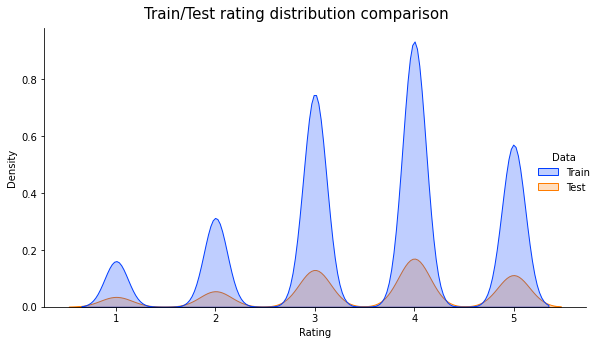

In [ ]:
plot_ratings_histogram(df_col=ratings_train['rating'], df_col2=ratings_test['rating'], title='Train/Test rating distribution comparison', col1_name='Train', col2_name='Test', x_name='Rating')

#### Compare the user gender distribution in our training data and our test data

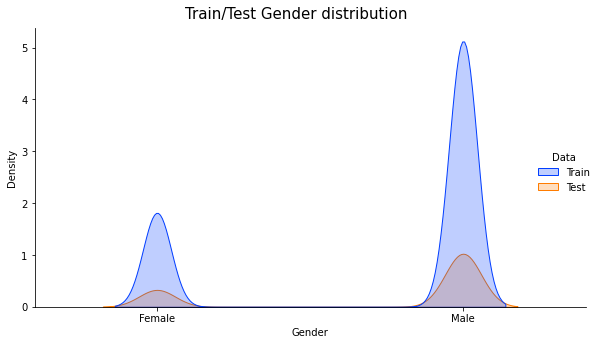

In [ ]:
def plot_gender_histogram(title):
  data = [('Train', 1 if val == 'M' else 0) for val in pd.merge(ratings_train, users, on='user_id')['sex'].values] + [('Test', 1 if val == 'M' else 0) for val in pd.merge(ratings_test, users, on='user_id')['sex'].values]
  data = pd.DataFrame(data=data, columns=['Data', 'Gender'])
  p = sns.displot(data=data, x='Gender', hue='Data', kind='kde', fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5)
  p.set_xticklabels(['Female', 'Male'], fontsize=10)
  p.fig.suptitle(title, fontsize=15)
  p.fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.xticks(np.arange(0, 2, 1.0))
  plt.show()
  
plot_gender_histogram(title='Train/Test Gender distribution')

#### Compare the user age distribution in our training data and our test data

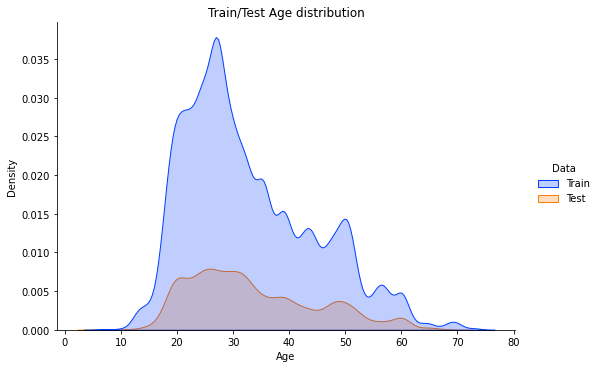

In [ ]:
def plot_age_histogram(title):
  data = [('Train', val) for val in pd.merge(ratings_train, users, on='user_id')['age'].values] + [('Test', val) for val in pd.merge(ratings_test, users, on='user_id')['age'].values]
  data = pd.DataFrame(data=data, columns=['Data', 'Age'])
  p = sns.displot(data=data, x='Age', hue='Data', kind='kde', fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5)
  plt.title(title)
  plt.show()
  
plot_age_histogram(title='Train/Test Age distribution')

In [ ]:
def mae(y_true, y_pred):
  """Calculates MAE metric according to true and predicted values"""
  return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
  """Calculates RMSE metric according to true and predicted values"""
  return np.sqrt(np.mean((y_pred - y_true)**2))

## Section 2.a.
### Baseline rating prediction models based on the global average rating per movie in the entire MovieLens 100K dataset

In [ ]:
# The baseline model always predicts the average rating per movie
class BaselineRecommender:
  def __init__(self, gender=None):
    self.gender = gender
  
  def fit(self, data):
    if self.gender:
      self.data = user_ratings.query(f'sex == "{self.gender}"')[['movie_id', 'rating']]
    else:
      self.data = data
    self.data = get_average_movie_ratings(self.data)
    self.model = pd.Series(self.data['avg_rating'].values, index=self.data['movie_id']).to_dict()

  def predict(self, test_data):
    pred = []
    if self.gender:
      test_data = pd.merge(users, test_data, on='user_id').query(f'sex == "{self.gender}"')[['user_id', 'movie_id', 'rating']]
    else:
      test_data = test_data[['user_id', 'movie_id', 'rating']]
    test_data['movie_id'].apply(lambda id: pred.append(self.model[id]))
    return pred, test_data

  def evaluate(self, test_data):
    pred, test_data = self.predict(test_data)
    return {'MAE': mae(test_data["rating"], pred), 'RMSE': rmse(test_data["rating"], pred)}

#### Entire population baseline predictions

In [ ]:
baseline_model = BaselineRecommender()
baseline_model.fit(ratings)
basemodel_pred, test_data = baseline_model.predict(ratings_test)
basemodel_loss = baseline_model.evaluate(test_data)

test_pred = test_data.assign(rating_pred=basemodel_pred)
print(f'Total subjects in test data: {len(test_pred)}')
test_pred

Total subjects in test data: 20000


user_id  movie_id  rating  rating_pred
0            0         5       5     3.576923
1            0         9       3     3.831461
2            0        11       5     4.385768
3            0        13       5     3.967213
4            0        16       3     3.119565
...        ...       ...     ...          ...
19995      457       647       4     4.029851
19996      457      1100       4     3.770270
19997      458       933       3     2.926471
19998      459         9       3     3.831461
19999      461       681       5     3.060000

[20000 rows x 4 columns]

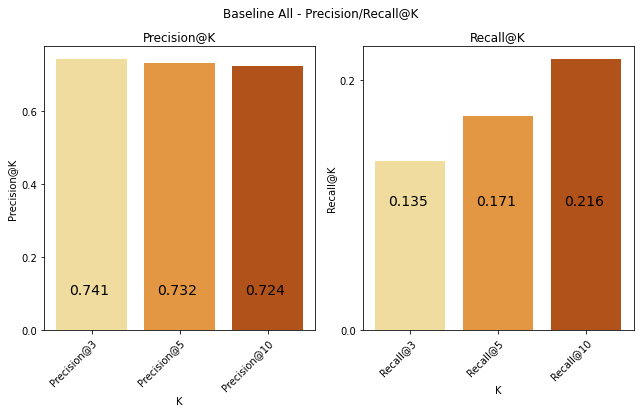

In [ ]:
mprk_baseline_all = plot_model_precision_recall_at_k(test_pred, k=[3, 5, 10], plot_title='Baseline All')

In [ ]:
print(f'MAE: {basemodel_loss["MAE"]}')
print(f'RMSE: {basemodel_loss["RMSE"]}')

MAE: 0.8072284653453374
RMSE: 1.0083009538696794


## Section 2.b.

#### Male population baseline predictions

In [ ]:
gender = 'M'
baseline_model_male = BaselineRecommender(gender)
baseline_model_male.fit(ratings)
basemodel_pred_male, test_data = baseline_model_male.predict(ratings_test)
basemodel_loss_male = baseline_model_male.evaluate(test_data)

test_pred = test_data.assign(rating_pred=basemodel_pred_male)
print(f'Total {gender} gender in test data: {len(test_pred)}')
test_pred

Total M gender in test data: 15167


user_id  movie_id  rating  rating_pred
0            0         5       5     3.571429
1            0         9       3     3.869565
2            0        11       5     4.399061
3            0        13       5     4.000000
4            0        16       3     3.164557
...        ...       ...     ...          ...
19985      455       942       4     3.513514
19994      457       143       4     3.908163
19995      457       647       4     4.060000
19996      457      1100       4     3.816667
19997      458       933       3     2.763158

[15167 rows x 4 columns]

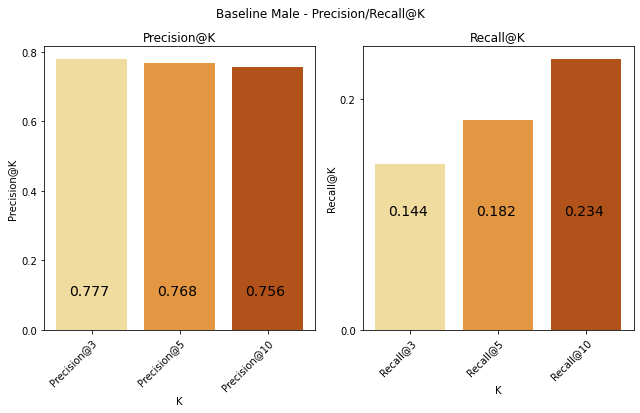

In [ ]:
mprk_baseline_male = plot_model_precision_recall_at_k(test_pred, k=[3, 5, 10], plot_title='Baseline Male')

In [ ]:
print(f'MAE: {basemodel_loss_male["MAE"]}')
print(f'RMSE: {basemodel_loss_male["RMSE"]}')

MAE: 0.7807317165450502
RMSE: 0.9767495515684287


#### Female population baseline predictions

In [ ]:
gender = 'F'
baseline_model_female = BaselineRecommender(gender)
baseline_model_female.fit(ratings)
basemodel_pred_female, test_data = baseline_model_female.predict(ratings_test)
basemodel_loss_female = baseline_model_female.evaluate(test_data)

test_pred = test_data.assign(rating_pred=basemodel_pred_female)
print(f'Total {gender} gender in test data: {len(test_pred)}')
test_pred

Total F gender in test data: 4833


user_id  movie_id  rating  rating_pred
137          1        12       4     3.269231
138          1        18       3     4.285714
139          1        49       5     4.245033
140          1       250       5     4.529412
141          1       256       4     3.650000
...        ...       ...     ...          ...
19991      456       703       4     2.818182
19992      456       707       4     3.566667
19993      456       774       3     2.933333
19998      459         9       3     3.700000
19999      461       681       5     3.187500

[4833 rows x 4 columns]

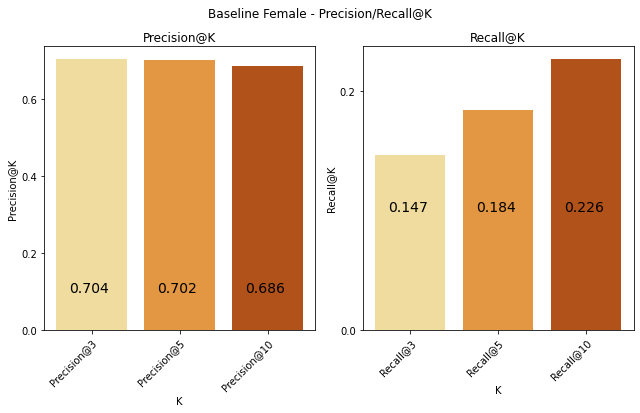

In [ ]:
mprk_baseline_female = plot_model_precision_recall_at_k(test_pred, k=[3, 5, 10], plot_title='Baseline Female')

In [ ]:
print(f'MAE: {basemodel_loss_female["MAE"]}')
print(f'RMSE: {basemodel_loss_female["RMSE"]}')

MAE: 0.8527262621582588
RMSE: 1.0601130761239335


#### Compare the baseline models loss values in regards to population gender

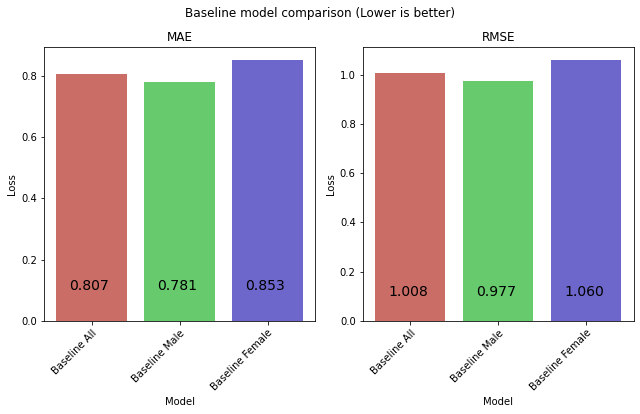

In [ ]:
plot_model_loss_comparison(losses={'Baseline All': {'mae': basemodel_loss["MAE"], 'rmse': basemodel_loss["RMSE"]},
                                   'Baseline Male': {'mae': basemodel_loss_male["MAE"], 'rmse': basemodel_loss_male["RMSE"]},
                                   'Baseline Female': {'mae': basemodel_loss_female["MAE"], 'rmse': basemodel_loss_female["RMSE"]}},
                            plot_title='Baseline model comparison')

#### Compare the baseline models precision/recall @ K values in regards to population gender

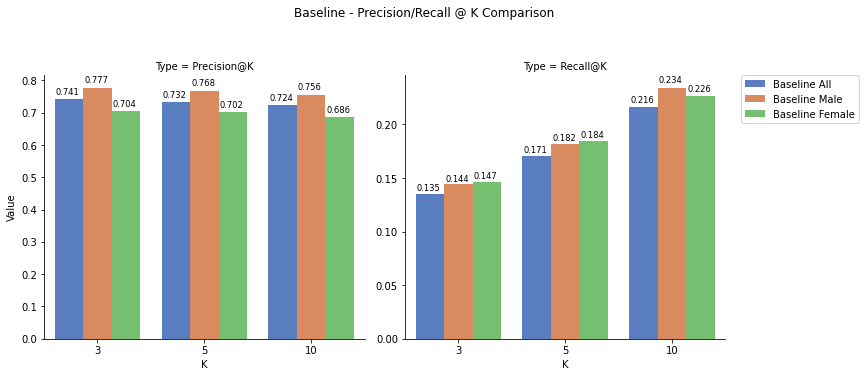

In [ ]:
plot_model_precision_recall_at_k_comparison(data={'Baseline All': mprk_baseline_all,
                                   'Baseline Male': mprk_baseline_male,
                                   'Baseline Female': mprk_baseline_female},
                                    plot_title='Baseline')

# Question 3 - Personal recommendations using TuriCreate library
The TuriCreate recommender toolkit provides a unified interface to train a variety of recommender models and use them to make recommendations.

In [ ]:
train_data = tc.SFrame(ratings_train)
test_data = tc.SFrame(ratings_test)

## Section 3.a.
Implement rating prediction models according to the following models:
- Item2Item Simillarity
- Item Content
- Matrix Factorization

### Item2Item Simillarity

#### Cosine similarity

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space.
It is defined to equal the cosine of the angle between them, which is also the same as the inner product of the same vectors normalized to both have length 1.

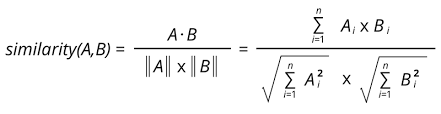

In [ ]:
item_cosine_sim_model = tc.item_similarity_recommender.create(train_data, user_id='user_id', item_id='movie_id', target='rating', similarity_type='cosine')

Warning: Ignoring columns unix_timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 80000 observations with 943 users and 1650 items.

Data prepared in: 0.120485s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 13.912ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 18.979ms                            | 0                | 2               |

| 262.353ms                           | 100              | 1650            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.295729s

In [ ]:
y_pred_cosine = item_cosine_sim_model.predict(test_data)
print(f'MAE: {mae(test_data["rating"], y_pred_cosine)}')
print(f'RMSE: {rmse(np.array(test_data["rating"]), np.array(y_pred_cosine))}')
item_cosine_sim_model.evaluate(test_data)

MAE: 3.2668090662272924
RMSE: 3.4523759469176674

Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.5904139433551199 | 0.02627655635316414 |
|   2    |  0.5555555555555555 | 0.04729886233977544 |
|   3    |  0.5301379811183732 | 0.06427629156051512 |
|   4    |  0.5054466230936822 |  0.0819837493495335 |
|   5    | 0.49673202614379114 | 0.10107005493937378 |
|   6    | 0.47712418300653575 | 0.11393808710889497 |
|   7    |  0.4593837535014004 | 0.12560420169882275 |
|   8    | 0.44498910675381265 | 0.13513370499162625 |
|   9    |  0.4366981360445412 |  0.1467042228785395 |
|   10   |  0.4270152505446624 |  0.1575620140381631 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.4523759469176682

Per User RMSE (best)
+---------+-------------------+-------+
| user_id |

{'precision_recall_by_user': Columns:
 	user_id	int
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 8262
 
 Data:
 +---------+--------+--------------------+-----------------------+-------+
 | user_id | cutoff |     precision      |         recall        | count |
 +---------+--------+--------------------+-----------------------+-------+
 |    0    |   1    |        1.0         | 0.0072992700729927005 |  137  |
 |    0    |   2    |        1.0         |  0.014598540145985401 |  137  |
 |    0    |   3    |        1.0         |  0.021897810218978103 |  137  |
 |    0    |   4    |        1.0         |  0.029197080291970802 |  137  |
 |    0    |   5    |        1.0         |   0.0364963503649635  |  137  |
 |    0    |   6    |        1.0         |  0.043795620437956206 |  137  |
 |    0    |   7    |        1.0         |  0.051094890510948905 |  137  |
 |    0    |   8    |       0.875        |  0.051094890510948905 |  137  |
 |    0    |   9    | 0.8888888888888888 |

In [ ]:
test_pred = ratings_test.assign(rating_pred=y_pred_cosine)
test_pred

user_id  movie_id  rating  unix_timestamp  rating_pred
0            0         5       5       887431973     0.000000
1            0         9       3       875693118     0.034503
2            0        11       5       878542960     0.620242
3            0        13       5       874965706     0.151729
4            0        16       3       875073198     0.066452
...        ...       ...     ...             ...          ...
19995      457       647       4       886395899     0.013386
19996      457      1100       4       886397931     0.040171
19997      458       933       3       879563639     0.069467
19998      459         9       3       882912371     0.172382
19999      461       681       5       886365231     0.400080

[20000 rows x 5 columns]

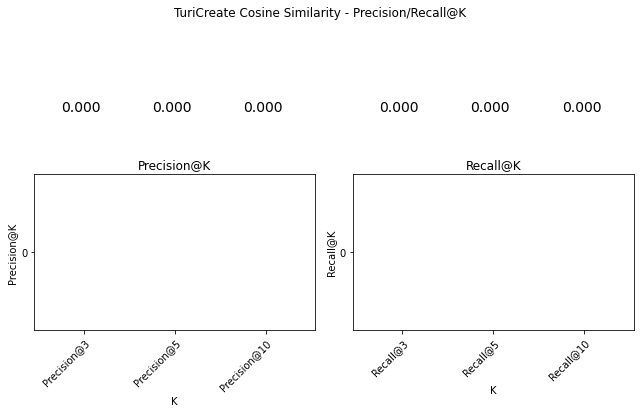

In [ ]:
mprk_cosine = plot_model_precision_recall_at_k(test_pred, k=[3, 5, 10], plot_title='TuriCreate Cosine Similarity')

### Pearson Correlation
In statistics, the Pearson correlation coefficient, also referred to as Pearson's r, the Pearson product-moment correlation coefficient (PPMCC), or the bivariate correlation, is a measure of linear correlation between two sets of data.

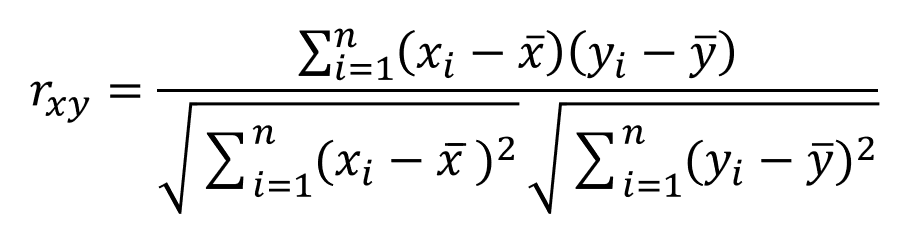

In [ ]:
item_pearson_sim_model = tc.item_similarity_recommender.create(train_data, user_id='user_id', item_id='movie_id', target='rating', similarity_type='pearson')

Warning: Ignoring columns unix_timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 80000 observations with 943 users and 1650 items.

Data prepared in: 0.119556s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 24.276ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 27.686ms                            | 0                | 2               |

| 371.582ms                           | 100              | 1650            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.405158s

In [ ]:
y_pred_pearson = item_pearson_sim_model.predict(test_data)
print(f'MAE: {mae(test_data["rating"], y_pred_pearson)}')
print(f'RMSE: {rmse(np.array(test_data["rating"]), np.array(y_pred_pearson))}')
item_pearson_sim_model.evaluate(test_data)

MAE: 0.8258110855318893
RMSE: 1.0329022402031238

Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |  0.002178649237472767  | 1.134713144517066e-05  |
|   2    | 0.0010893246187363831  | 1.1347131445170659e-05 |
|   3    | 0.0007262164124909222  | 1.1347131445170659e-05 |
|   4    | 0.0005446623093681916  | 1.1347131445170659e-05 |
|   5    | 0.0004357298474945534  | 1.134713144517066e-05  |
|   6    | 0.00036310820624546115 | 1.134713144517066e-05  |
|   7    | 0.00031123560535325237 | 1.1347131445170659e-05 |
|   8    | 0.0005446623093681914  | 3.357824611326011e-05  |
|   9    | 0.0009682885499878966  | 0.00010851802450734261 |
|   10   |  0.00130718954248366   | 0.00014613572119356663 |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 1.032902

{'precision_recall_by_user': Columns:
 	user_id	int
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 8262
 
 Data:
 +---------+--------+-----------+--------+-------+
 | user_id | cutoff | precision | recall | count |
 +---------+--------+-----------+--------+-------+
 |    0    |   1    |    0.0    |  0.0   |  137  |
 |    0    |   2    |    0.0    |  0.0   |  137  |
 |    0    |   3    |    0.0    |  0.0   |  137  |
 |    0    |   4    |    0.0    |  0.0   |  137  |
 |    0    |   5    |    0.0    |  0.0   |  137  |
 |    0    |   6    |    0.0    |  0.0   |  137  |
 |    0    |   7    |    0.0    |  0.0   |  137  |
 |    0    |   8    |    0.0    |  0.0   |  137  |
 |    0    |   9    |    0.0    |  0.0   |  137  |
 |    0    |   10   |    0.0    |  0.0   |  137  |
 +---------+--------+-----------+--------+-------+
 [8262 rows x 5 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns

In [ ]:
test_pred = ratings_test.assign(rating_pred=y_pred_pearson)
test_pred

user_id  movie_id  rating  unix_timestamp  rating_pred
0            0         5       5       887431973     3.405687
1            0         9       3       875693118     3.877677
2            0        11       5       878542960     4.406993
3            0        13       5       874965706     3.902111
4            0        16       3       875073198     3.179882
...        ...       ...     ...             ...          ...
19995      457       647       4       886395899     3.961275
19996      457      1100       4       886397931     3.723208
19997      458       933       3       879563639     2.906380
19998      459         9       3       882912371     3.879852
19999      461       681       5       886365231     3.097424

[20000 rows x 5 columns]

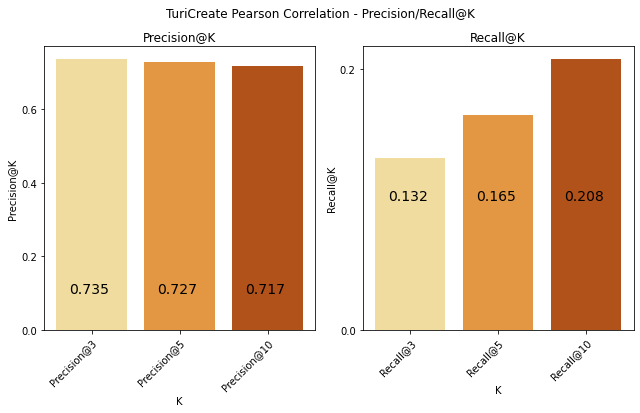

In [ ]:
mprk_pearson = plot_model_precision_recall_at_k(test_pred, k=[3, 5, 10], plot_title='TuriCreate Pearson Correlation')

### Item Content

A recommender based on the similarity between item content rather using user interaction patterns to compute similarity.

In [ ]:
def condense_binary_row(data, final_col, binary_cols, to_str=False):
    '''Condeses a df row with binary cols to a list of the column names that are set to 1'''
    cols = list(binary_cols)
    x = data[cols] # Slice the cols
    x = list(x[x[cols] == 1].index) # Get only binary positive values
    x.sort()
    data[final_col] = x # Assign column names list to final column
    data.drop(labels=cols, inplace=True) # Drop binary columns
    return data

d = pd.merge(pd.Series(ratings_train['movie_id'].unique(), name='movie_id'), movies, on='movie_id')[['movie_id', 'year'] + genre_cols]
content_train = tc.SFrame(d.apply(lambda row: condense_binary_row(row, 'Generes', genre_cols), axis=1))
item_content_model = tc.recommender.item_content_recommender.create(item_data=content_train, item_id='movie_id', observation_data=train_data, user_id='user_id', target='rating')

Applying transform:
Class             : AutoVectorizer

Model Fields
------------
Features          : ['year', 'Generes']
Excluded Features : ['movie_id']

Column   Type  Interpretation  Transforms  Output Type
-------  ----  --------------  ----------  -----------
year     int   numerical       None        int        
Generes  list  categorical     Flatten     dict       


Defaulting to brute force instead of ball tree because there are multiple distance components.


Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 1            | 1650    | 0.0606061   | 10.802ms     |

| Done         |         | 100         | 337.597ms    |

+--------------+---------+-------------+--------------+

Warning: Ignoring columns unix_timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 80000 observations with 943 users and 1650 items.

Data prepared in: 0.289763s

Loading user-provided nearest items.

Generating candidate set for working with new users.

Finished training in 0.043254s

In [ ]:
y_pred_content = item_content_model.predict(test_data)
print(f'MAE: {mae(test_data["rating"], y_pred_content)}')
print(f'RMSE: {rmse(np.array(test_data["rating"]), np.array(y_pred_content))}')
item_content_model.evaluate(test_data)

MAE: 3.349401487943707
RMSE: 3.5441401224014406

Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.1459694989106754 | 0.00399187728549197  |
|   2    |  0.1318082788671024 | 0.007440228130846247 |
|   3    | 0.11328976034858393 | 0.009977820101997957 |
|   4    | 0.11274509803921569 | 0.01307143846911446  |
|   5    | 0.10893246187363846 | 0.015954642182971428 |
|   6    | 0.10784313725490194 | 0.018738603932986587 |
|   7    | 0.10364145658263312 | 0.02079145214278566  |
|   8    | 0.09967320261437909 | 0.02256903121170482  |
|   9    | 0.09803921568627458 | 0.025090184698572437 |
|   10   | 0.09782135076252728 | 0.028056399563741403 |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 3.544140122401443

Per User RMSE (best)
+---------+--------------------+-------

{'precision_recall_by_user': Columns:
 	user_id	int
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 8262
 
 Data:
 +---------+--------+---------------------+-----------------------+-------+
 | user_id | cutoff |      precision      |         recall        | count |
 +---------+--------+---------------------+-----------------------+-------+
 |    0    |   1    |         0.0         |          0.0          |  137  |
 |    0    |   2    |         0.0         |          0.0          |  137  |
 |    0    |   3    |         0.0         |          0.0          |  137  |
 |    0    |   4    |         0.0         |          0.0          |  137  |
 |    0    |   5    |         0.0         |          0.0          |  137  |
 |    0    |   6    |         0.0         |          0.0          |  137  |
 |    0    |   7    | 0.14285714285714285 | 0.0072992700729927005 |  137  |
 |    0    |   8    |        0.125        | 0.0072992700729927005 |  137  |
 |    0    |   9    |  0.222222

In [ ]:
test_pred = ratings_test.assign(rating_pred=y_pred_content)
test_pred

user_id  movie_id  rating  unix_timestamp  rating_pred
0            0         5       5       887431973     0.128994
1            0         9       3       875693118     0.042744
2            0        11       5       878542960     0.076707
3            0        13       5       874965706     0.214417
4            0        16       3       875073198     0.016845
...        ...       ...     ...             ...          ...
19995      457       647       4       886395899     0.049140
19996      457      1100       4       886397931     0.067293
19997      458       933       3       879563639     0.000000
19998      459         9       3       882912371     0.044776
19999      461       681       5       886365231     0.000000

[20000 rows x 5 columns]

In [ ]:
mprk_content = plot_model_precision_recall_at_k(test_pred, k=[3, 5, 10], plot_title='TuriCreate Item Content')

NameError: ignored

### Matrix Facorization
Matrix factorization is a class of collaborative filtering algorithms used in recommender systems.
Matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices.

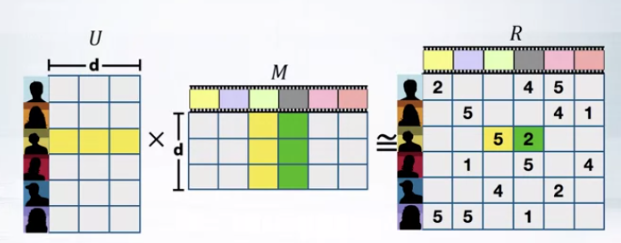

In [ ]:
mf_model = tc.recommender.factorization_recommender.create(train_data, user_id='user_id', item_id='movie_id', target='rating')

Preparing data set.

Data has 80000 observations with 943 users and 1650 items.

Data prepared in: 0.119615s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80000 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 16.6667           | Not Viable                               |

| 1       | 4.16667           | Not Viable                               |

| 2       | 1.04167           | Not Viable                               |

| 3       | 0.260417          | 0.173785                                 |

| 4       | 0.130208          | 0.334914                                 |

| 5       | 0.0651042         | 0.601517                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.260417          | 0.173785                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 132us        | 1.25115           | 1.11855               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 104.227ms    | DIVERGED          | DIVERGED              | 0.260417    |

| RESET   | 122.977ms    | 1.25115           | 1.11855               |             |

| 1       | 187.681ms    | 1.1799            | 1.08623               | 0.130208    |

| 2       | 243.564ms    | 0.908494          | 0.953148              | 0.130208    |

| 3       | 311.02ms     | 0.875735          | 0.935806              | 0.130208    |

| 4       | 352.024ms    | 0.855887          | 0.92514               | 0.130208    |

| 5       | 417.665ms    | 0.839543          | 0.916264              | 0.130208    |

| 9       | 630.25ms     | 0.798271          | 0.893458              | 0.130208    |

| 49      | 2.68s        | 0.641143          | 0.800705              | 0.130208    |

| 50      | 2.75s        | 0.638991          | 0.79936               | 0.130208    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.620772

Final training RMSE: 0.787882

In [ ]:
y_pred_mf = mf_model.predict(test_data)
print(f'MAE: {mae(test_data["rating"], y_pred_mf)}')
print(f'RMSE: {rmse(np.array(test_data["rating"]), np.array(y_pred_mf))}')
mf_model.evaluate(test_data)

MAE: 0.7592660491639456
RMSE: 0.9706173422580765

Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.16557734204793026 | 0.00526882588907496  |
|   2    | 0.16122004357298475 | 0.009331126392212445 |
|   3    | 0.15831517792302105 | 0.013050216397672225 |
|   4    | 0.15631808278867096 | 0.01656749454074667  |
|   5    | 0.14901960784313723 | 0.019136219428219754 |
|   6    |  0.1427015250544662 | 0.021669656407745114 |
|   7    |  0.1400560224089636 | 0.024627216985494017 |
|   8    | 0.13671023965141602 | 0.026788140844956013 |
|   9    |  0.1353183248608085 |  0.0294314764760266  |
|   10   | 0.13464052287581704 | 0.032400857433660626 |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9706173422580769

Per User RMSE (best)
+---------+---------------------+----

{'precision_recall_by_user': Columns:
 	user_id	int
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 8262
 
 Data:
 +---------+--------+-----------+--------+-------+
 | user_id | cutoff | precision | recall | count |
 +---------+--------+-----------+--------+-------+
 |    0    |   1    |    0.0    |  0.0   |  137  |
 |    0    |   2    |    0.0    |  0.0   |  137  |
 |    0    |   3    |    0.0    |  0.0   |  137  |
 |    0    |   4    |    0.0    |  0.0   |  137  |
 |    0    |   5    |    0.0    |  0.0   |  137  |
 |    0    |   6    |    0.0    |  0.0   |  137  |
 |    0    |   7    |    0.0    |  0.0   |  137  |
 |    0    |   8    |    0.0    |  0.0   |  137  |
 |    0    |   9    |    0.0    |  0.0   |  137  |
 |    0    |   10   |    0.0    |  0.0   |  137  |
 +---------+--------+-----------+--------+-------+
 [8262 rows x 5 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns

In [ ]:
test_pred = ratings_test.assign(rating_pred=y_pred_mf)
test_pred

user_id  movie_id  rating  unix_timestamp  rating_pred
0            0         5       5       887431973     3.064887
1            0         9       3       875693118     4.112834
2            0        11       5       878542960     4.530835
3            0        13       5       874965706     4.147889
4            0        16       3       875073198     3.788614
...        ...       ...     ...             ...          ...
19995      457       647       4       886395899     3.962348
19996      457      1100       4       886397931     3.644977
19997      458       933       3       879563639     2.930394
19998      459         9       3       882912371     4.017355
19999      461       681       5       886365231     3.592513

[20000 rows x 5 columns]

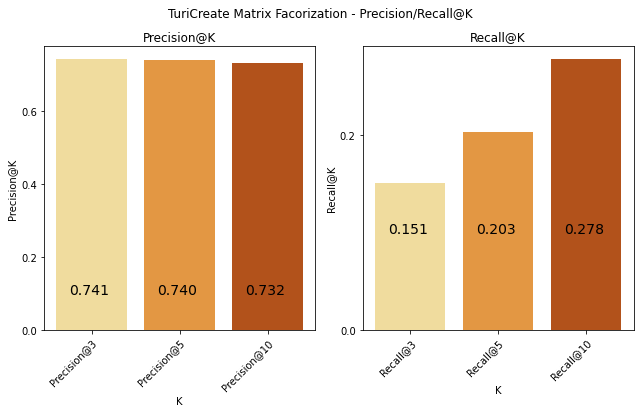

In [ ]:
mprk_mf = plot_model_precision_recall_at_k(test_pred, k=[3, 5, 10], plot_title='TuriCreate Matrix Facorization')

## Section 3.b.

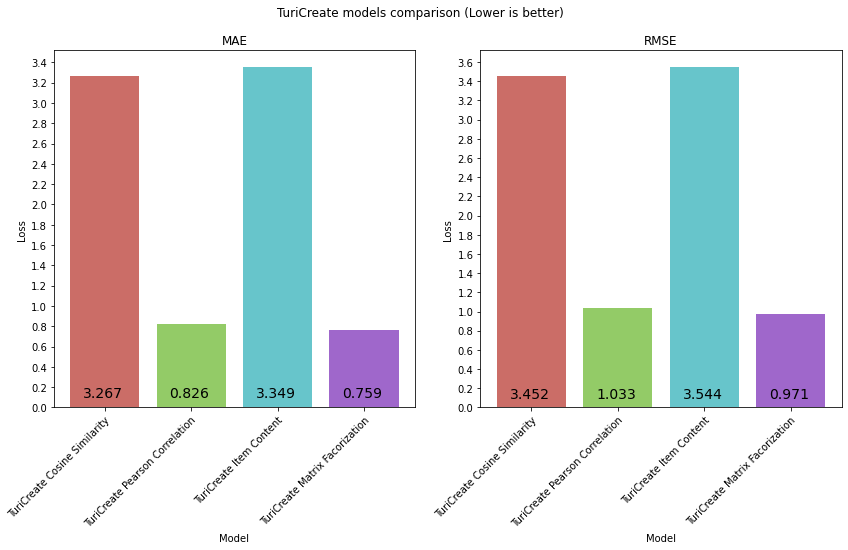

In [ ]:
plot_model_loss_comparison(losses={'TuriCreate Cosine Similarity': {'mae': mae(test_data["rating"], y_pred_cosine), 'rmse': rmse(np.array(test_data["rating"]), np.array(y_pred_cosine))},
                                   'TuriCreate Pearson Correlation': {'mae': mae(test_data["rating"], y_pred_pearson), 'rmse': rmse(np.array(test_data["rating"]), np.array(y_pred_pearson))},
                                   'TuriCreate Item Content': {'mae': mae(test_data["rating"], y_pred_content), 'rmse': rmse(np.array(test_data["rating"]), np.array(y_pred_content))},
                                   'TuriCreate Matrix Facorization': {'mae': mae(test_data["rating"], y_pred_mf), 'rmse': rmse(np.array(test_data["rating"]), np.array(y_pred_mf))},
                                   },
                            plot_title='TuriCreate models comparison', high=True)

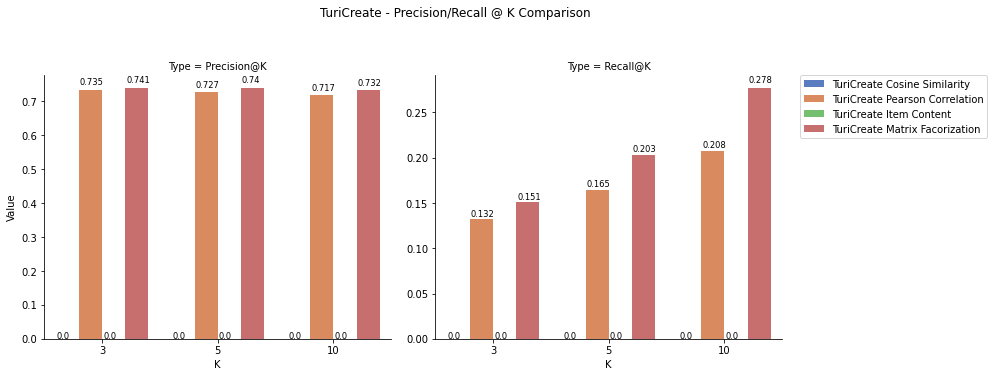

In [ ]:
plot_model_precision_recall_at_k_comparison(data={'TuriCreate Cosine Similarity': mprk_cosine,
                                   'TuriCreate Pearson Correlation': mprk_pearson,
                                   'TuriCreate Item Content': mprk_content,
                                   'TuriCreate Matrix Facorization': mprk_mf},
                                    plot_title='TuriCreate')

In [ ]:
models_performance = tc.recommender.util.compare_models = (test_data, [item_content_model, item_cosine_sim_model, item_pearson_sim_model, mf_model])
print(models_performance)

(Columns:
	user_id	int
	movie_id	int
	rating	int
	unix_timestamp	int

Rows: 20000

Data:
+---------+----------+--------+----------------+
| user_id | movie_id | rating | unix_timestamp |
+---------+----------+--------+----------------+
|    0    |    5     |   5    |   887431973    |
|    0    |    9     |   3    |   875693118    |
|    0    |    11    |   5    |   878542960    |
|    0    |    13    |   5    |   874965706    |
|    0    |    16    |   3    |   875073198    |
|    0    |    19    |   4    |   887431883    |
|    0    |    22    |   4    |   875072895    |
|    0    |    23    |   3    |   875071713    |
|    0    |    26    |   2    |   876892946    |
|    0    |    30    |   3    |   875072144    |
+---------+----------+--------+----------------+
[20000 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns., [Class                            : ItemContentRecommender

Schema
----

## Section 3.c.

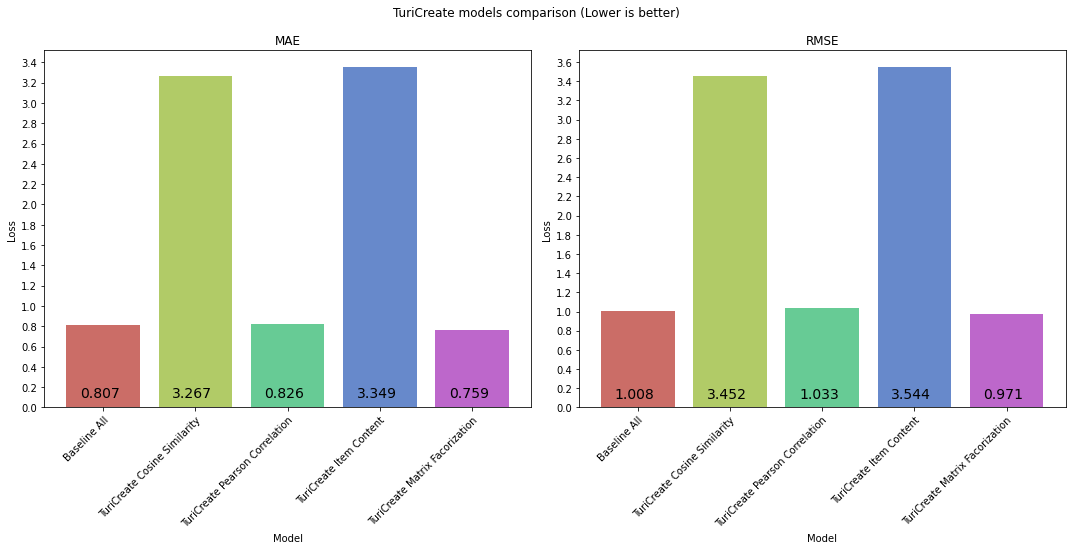

In [ ]:
plot_model_loss_comparison(losses={'Baseline All': {'mae': basemodel_loss["MAE"], 'rmse': basemodel_loss["RMSE"]},
                                    'TuriCreate Cosine Similarity': {'mae': mae(test_data["rating"], y_pred_cosine), 'rmse': rmse(np.array(test_data["rating"]), np.array(y_pred_cosine))},
                                   'TuriCreate Pearson Correlation': {'mae': mae(test_data["rating"], y_pred_pearson), 'rmse': rmse(np.array(test_data["rating"]), np.array(y_pred_pearson))},
                                   'TuriCreate Item Content': {'mae': mae(test_data["rating"], y_pred_content), 'rmse': rmse(np.array(test_data["rating"]), np.array(y_pred_content))},
                                   'TuriCreate Matrix Facorization': {'mae': mae(test_data["rating"], y_pred_mf), 'rmse': rmse(np.array(test_data["rating"]), np.array(y_pred_mf))},
                                   },
                            plot_title='TuriCreate models comparison', high=True)

# Question 4 - Keras ‫‪Neural‬‬ ‫‪Collaborative‬‬ ‫‪Filtering‬‬ models

#### NCF: A fusion of GMF and MLP
NCF has 2 components **GMF (Generalized Matrix Factorisation )*** and **MLP(Multi-Layer Perceptron)** with the following benefits
GMF that applies the linear kernel to model user-item interactions like MF.

MLP that uses multiple neural layers to layer nonlinear interactions
NCF combines these models together to superimpose their desirable characteristics. 
NCF concatenates the output of GMF and MLP before feeding them into NCF layer.

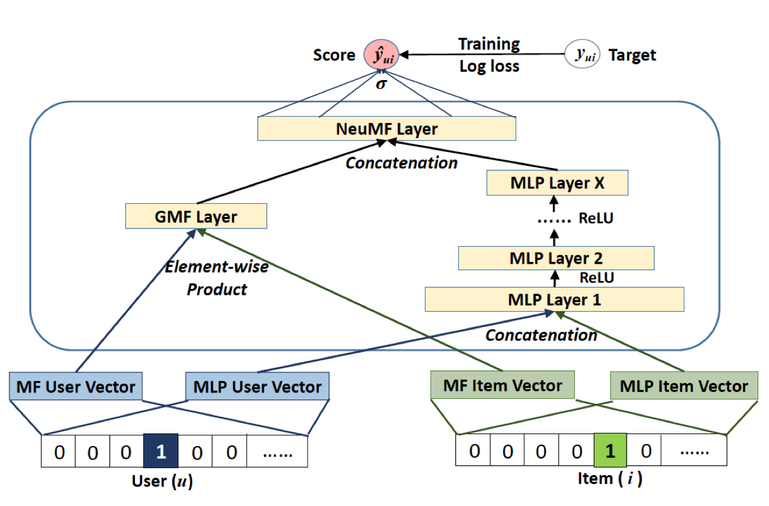

#### Prepare data for ‫‪Neural‬‬ ‫‪Collaborative‬‬ ‫‪Filtering‬‬ model training

In [ ]:
MODEL_WEIGHTS_FILE_PREFIX = 'keras_model_'
KERAS_MODEL_PATH = 'keras_models'

KERAS_MODEL_FULL_PATH = join(getcwd(), KERAS_MODEL_PATH)

if not isdir(KERAS_MODEL_FULL_PATH):
  mkdir(KERAS_MODEL_FULL_PATH)

In [ ]:
def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [ ]:
def min_max_normalize(value, min, max):
  return (value - min) / (max - min)

def reverse_min_max_normalize(value, min, max):
  return value * (max - min) + min

def get_min_max_rating(df):
  min_rating = df['rating'].drop_duplicates().astype(np.float32).min()
  max_rating = df['rating'].drop_duplicates().astype(np.float32).max()
  return max_rating, min_rating

Assign user ids and movie ids to training data map

In [ ]:
max_rating, min_rating = get_min_max_rating(ratings)

train = ratings_train[['user_id', 'movie_id']].values
X_train_map = {'user_id': train[:, 0], 'movie_id': train[:, 1]}
y_train = ratings_train['rating'].values.astype(np.float32)

test = ratings_test[['user_id', 'movie_id']].values
X_test_map = {'user_id': test[:, 0], 'movie_id': test[:, 1]}
y_test = ratings_test['rating'].values.astype(np.float32)

print(f'Train data shapes: user_id: {X_train_map["user_id"].shape}, movie_id: {X_train_map["movie_id"].shape}, y train (rating): {y_train.shape}')
print(f'Test data shapes: user_id: {X_test_map["user_id"].shape}, movie_id: {X_test_map["movie_id"].shape}, y test (rating): {y_test.shape}')

Train data shapes: user_id: (80000,), movie_id: (80000,), y train (rating): (80000,)
Test data shapes: user_id: (20000,), movie_id: (20000,), y test (rating): (20000,)


In [ ]:
def plot_history(history, plot_title):
    metric_map = {'mae': 'MAE', 'root_mean_squared_error': 'RMSE'}
    fig, axes = plt.subplots(nrows=1, ncols=len(metric_map), figsize=(len(metric_map) * 7, 5))
    history = history.history
    # Plot training & validation metrics
    for i, metric in enumerate(metric_map.keys()):
        axes[i].plot(history[metric])
        axes[i].plot(history[f'val_{metric}'])
        axes[i].legend(['Train', 'Validation'], loc='upper right')
        axes[i].set_title(f'Model {metric_map[metric]} Metric')
        axes[i].set_ylabel(metric_map[metric])
        axes[i].set_xlabel('Epoch')
        axes[i].grid()

    fig.suptitle(plot_title + " Metrics History")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
class TrainTime(Callback):
  '''Used to print elapsed time in seconds in the end of the training process'''
  def on_train_begin(self, logs={}):
      self.train_time_start = time.time()

  def on_train_end(self, logs={}):
      self.train_time_end = time.time() - self.train_time_start
      print(f'Total training time: {self.train_time_end} sec')

def create_callbacks(model_name):
  train_time_callback = TrainTime()
  return train_time_callback, [train_time_callback, EarlyStopping('val_loss', patience=10), 
          ModelCheckpoint(join(KERAS_MODEL_FULL_PATH, MODEL_WEIGHTS_FILE_PREFIX + model_name + '.h5'), save_best_only=True)]

## Section 4.a.

We will implement an NCF (Neural Collaborative Filtering) model starting with 1 hidden dense layer.

In [ ]:
def create_ncf_model_1(num_users, num_movies, latent_dim, hidden_dim, loss_f, lr, dropout):
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    movie_input = Input(shape=(1,),dtype='int32', name='movie_input')
    
    # Matrix factorization embedding layer
    mf_embedding_user = Embedding(input_dim=num_users, output_dim=latent_dim, name='mf_user_embedding', input_length=1, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))
    mf_embedding_movie = Embedding(input_dim=num_movies, output_dim=latent_dim, name='mf_movie_embedding', input_length=1, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))

    mf_user_latent = Flatten(name='mf_user_latent')(mf_embedding_user(user_input))
    mf_movie_latent = Flatten(name='mf_movie_latent')(mf_embedding_movie(movie_input))

    # MLP embedding layer
    mlp_embedding_user = Embedding(input_dim=num_users, output_dim=latent_dim, name='mlp_user_embedding', input_length=1)
    mlp_embedding_movie = Embedding(input_dim=num_movies, output_dim=latent_dim, name='mlp_movie_embedding', input_length=1)

    mlp_user_latent = Flatten(name='mlp_user_latent')(mf_embedding_user(user_input))
    mlp_movie_latent = Flatten(name='mlp_movie_latent')(mf_embedding_movie(movie_input))

    # Element-wise product of user and movie embeddings
    gmf = Multiply(name='gmf_user_movie_element_wise_product')([mf_user_latent, mf_movie_latent])

    # MLP concatination
    mlp = Concatenate(name='mlp_concat')([mlp_user_latent, mlp_movie_latent])

    # MLP hidden layers
    drop1 = Dropout(0.1, name='drop1_0.05')(mlp)
    hidden1 = Dense(hidden_dim, activation='relu')(drop1)
    drop2 = Dropout(dropout, name=f'drop2_{dropout}')(hidden1)

    # GMF & MLP concatination
    ncf_concat = Concatenate(name='ncf_concat')([gmf, drop2])
    x = Dense(1, activation='sigmoid', kernel_initializer='he_normal', name='prediction')(ncf_concat)

    # Since we used sigmoid [0, 1] output from previous layer we reverse-normalize to our range [min_rating, max_rating]
    pred = Lambda(lambda value: reverse_min_max_normalize(value, min_rating, max_rating), name='min_max_normalize')(x)

    model = Model(inputs=[user_input, movie_input], outputs=pred) # , gender_input, age_input
    model.compile(loss=loss_f, optimizer=Adam(lr=lr), metrics=['mae', root_mean_squared_error])
    return model

In [ ]:
ncf_model_1 = create_ncf_model_1(num_users=rating_user_count, num_movies=rated_movie_count, latent_dim=20, hidden_dim=20, loss_f='mse', lr=0.001, dropout=0.5)
ncf_model_1.summary()

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
mf_user_embedding (Embedding)   (None, 1, 20)        18860       user_input[0][0]                 
                                                                 user_input[0][0]                 
__________________________________________________________________________________________________
mf_movie_embedding (Embedding)  (None, 1, 20)        33640       movie_input[0][0]         

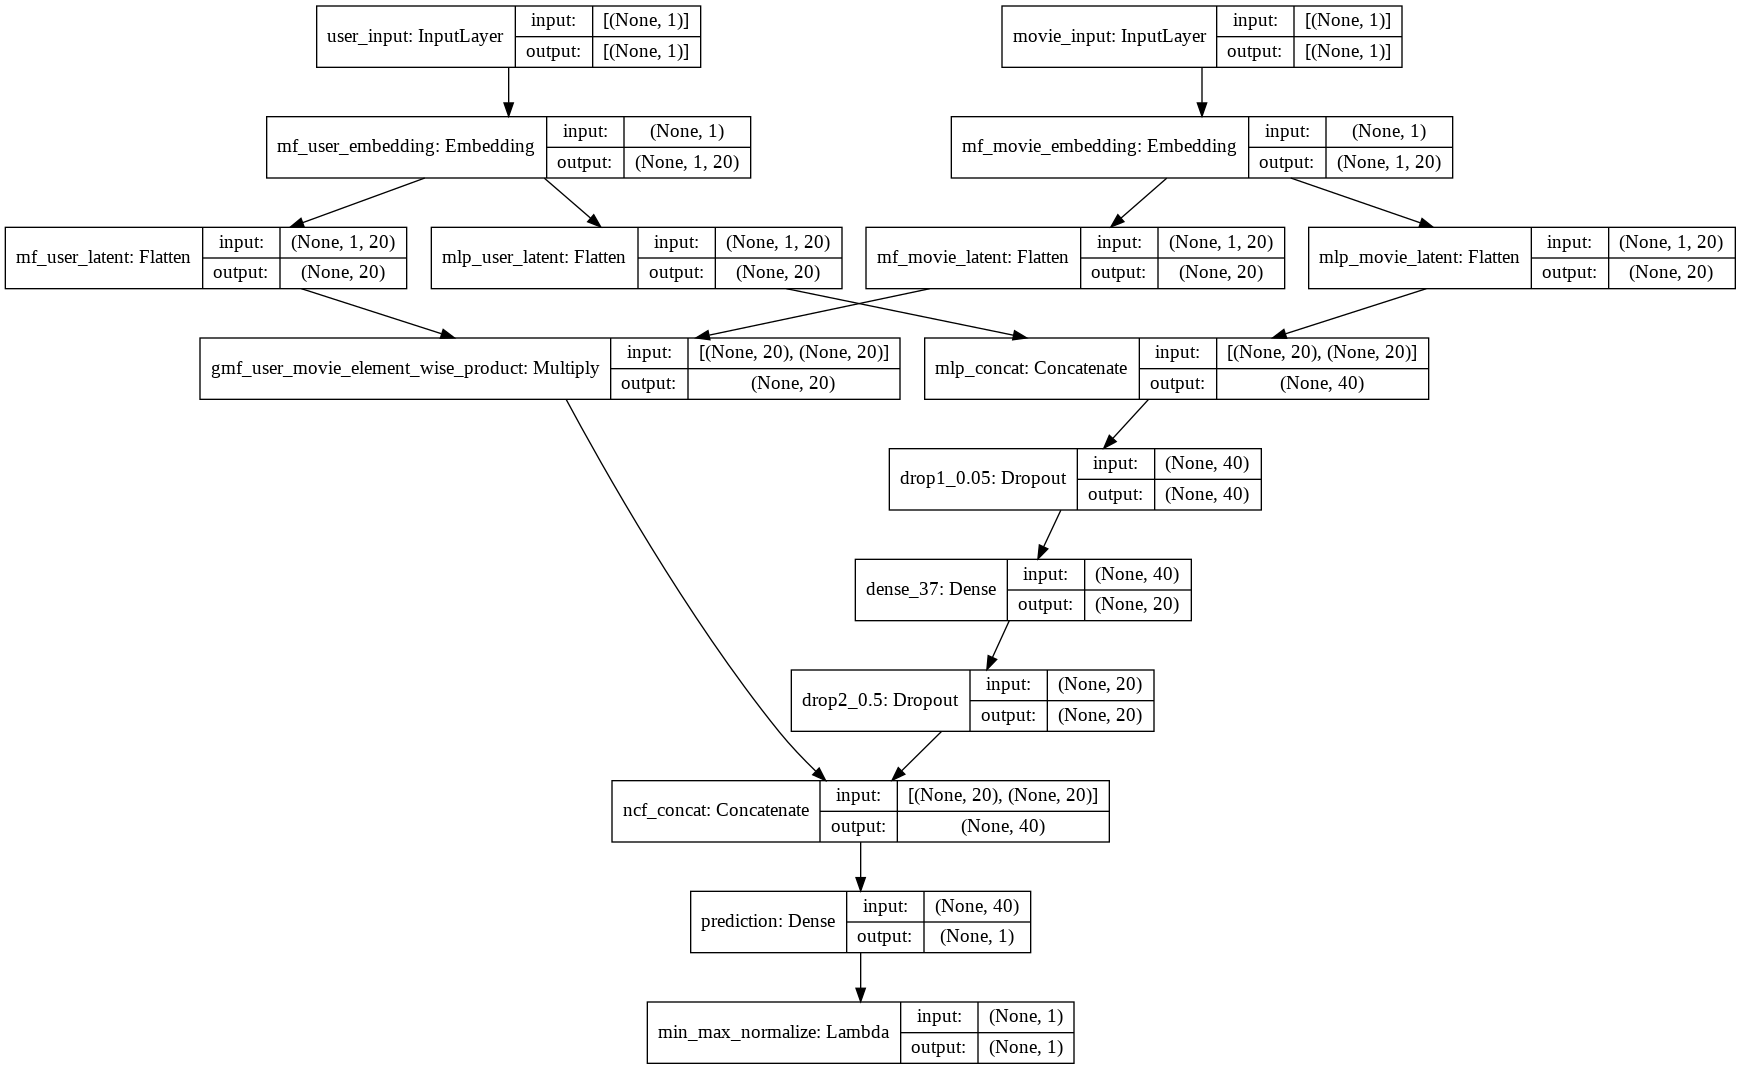

In [ ]:
plot_model(ncf_model_1, "ncf_model_1.png", show_shapes=True)

In [ ]:
train_time_callback_1, callbacks = create_callbacks('ncf_model_1')
ncf_model_1_history = ncf_model_1.fit([X_train_map['user_id'], X_train_map['movie_id']], y_train, epochs=25, validation_split=.1, verbose=1, callbacks=callbacks, batch_size=32)

Epoch 1/25
2250/2250 [==============================] - 7s 3ms/step - loss: 1.1276 - mae: 0.8597 - root_mean_squared_error: 1.0524 - val_loss: 0.9760 - val_mae: 0.7931 - val_root_mean_squared_error: 0.9657
Epoch 2/25
2250/2250 [==============================] - 6s 2ms/step - loss: 0.9099 - mae: 0.7581 - root_mean_squared_error: 0.9455 - val_loss: 0.9730 - val_mae: 0.7920 - val_root_mean_squared_error: 0.9637
Epoch 3/25
2250/2250 [==============================] - 6s 3ms/step - loss: 0.8818 - mae: 0.7443 - root_mean_squared_error: 0.9312 - val_loss: 0.9715 - val_mae: 0.7918 - val_root_mean_squared_error: 0.9627
Epoch 4/25
2250/2250 [==============================] - 6s 3ms/step - loss: 0.8607 - mae: 0.7362 - root_mean_squared_error: 0.9190 - val_loss: 0.9830 - val_mae: 0.8000 - val_root_mean_squared_error: 0.9685
Epoch 5/25
2250/2250 [==============================] - 6s 3ms/step - loss: 0.8374 - mae: 0.7255 - root_mean_squared_error: 0.9062 - val_loss: 0.9773 - val_mae: 0.7956 - val_ro

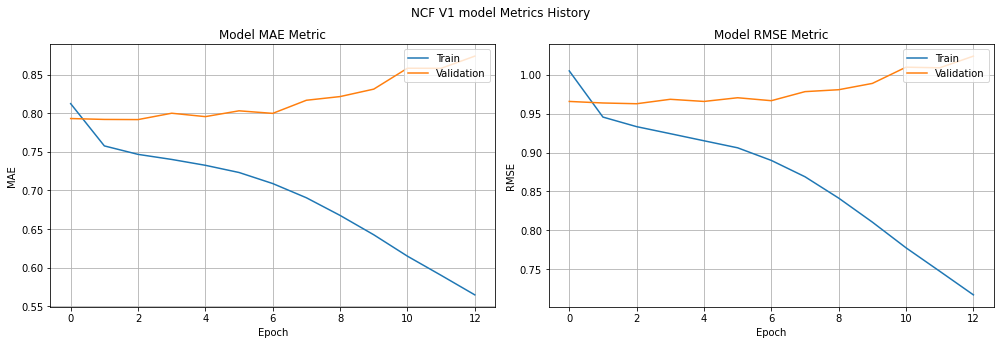

In [ ]:
plot_history(ncf_model_1_history, plot_title='NCF V1 model')

## Section 4.b.

We can clearly see that our initial Neural Collaborative Filtering model suffers from overfitting. 

**(validation loss increasing while training loss decreasing)**

In our second iteration we will try to solve it by:
- Decreasing our optimizers learning rate and to avoid divergence.
- Since we measure our model performance by MAE metric we need to change the loss function to MAE instead of MSE (alothough they usually correlate).
- Increasing dropout.

In [ ]:
loss_metrics_ncf_1 = ncf_model_1.evaluate([X_test_map['user_id'], X_test_map['movie_id']], y_test)

print(f'MAE: {loss_metrics_ncf_1[1]}')
print(f'RMSE: {loss_metrics_ncf_1[2]}')

625/625 [==============================] - 1s 1ms/step - loss: 1.0128 - mae: 0.7796 - root_mean_squared_error: 0.9822
MAE: 0.7796024680137634
RMSE: 0.9821773171424866


In [ ]:
prediction = ncf_model_1.predict([X_test_map['user_id'], X_test_map['movie_id']], batch_size=20)
test_pred = ratings_test.assign(rating_pred=prediction)
test_pred

user_id  movie_id  rating  unix_timestamp  rating_pred
0            0         5       5       887431973     3.800531
1            0         9       3       875693118     4.134938
2            0        11       5       878542960     4.930750
3            0        13       5       874965706     4.294693
4            0        16       3       875073198     3.214992
...        ...       ...     ...             ...          ...
19995      457       647       4       886395899     3.928123
19996      457      1100       4       886397931     3.894881
19997      458       933       3       879563639     3.131896
19998      459         9       3       882912371     3.934884
19999      461       681       5       886365231     3.312722

[20000 rows x 5 columns]

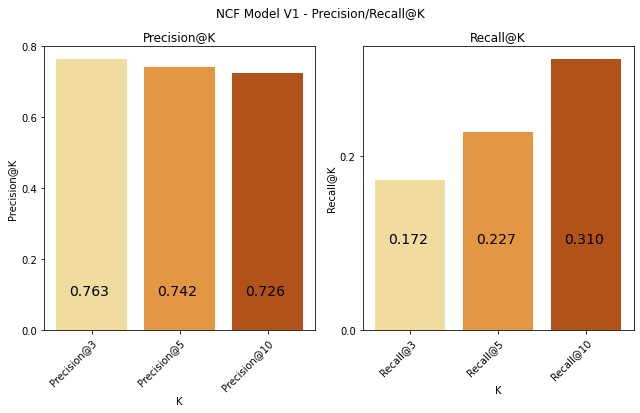

In [ ]:
mprk_ncf_1 = plot_model_precision_recall_at_k(test_pred, k=[3, 5, 10], plot_title='NCF Model V1')

- Decrease optimizer dropout from 0.001 to 0.0001 to try and avoid overfitting caused by divergence of the model.
- Changed loss function from MSE to MAE

In [ ]:
ncf_model_2 = create_ncf_model_1(num_users=rating_user_count, num_movies=rated_movie_count, latent_dim=20, hidden_dim=20, loss_f='mae', lr=0.0001, dropout=0.5)
ncf_model_2.summary()

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
mf_user_embedding (Embedding)   (None, 1, 20)        18860       user_input[0][0]                 
                                                                 user_input[0][0]                 
__________________________________________________________________________________________________
mf_movie_embedding (Embedding)  (None, 1, 20)        33640       movie_input[0][0]         

In [ ]:
train_time_callback_2, callbacks = create_callbacks('ncf_model_2')
ncf_model_2_history = ncf_model_2.fit([X_train_map['user_id'], X_train_map['movie_id']], y_train, epochs=25, validation_split=.1, verbose=1, callbacks=callbacks, batch_size=32)

Epoch 1/25
2250/2250 [==============================] - 7s 3ms/step - loss: 0.9810 - mae: 0.9809 - root_mean_squared_error: 1.1900 - val_loss: 0.8745 - val_mae: 0.8745 - val_root_mean_squared_error: 1.0243
Epoch 2/25
2250/2250 [==============================] - 6s 2ms/step - loss: 0.8459 - mae: 0.8458 - root_mean_squared_error: 1.0397 - val_loss: 0.7930 - val_mae: 0.7929 - val_root_mean_squared_error: 0.9753
Epoch 3/25
2250/2250 [==============================] - 5s 2ms/step - loss: 0.7802 - mae: 0.7801 - root_mean_squared_error: 0.9828 - val_loss: 0.7828 - val_mae: 0.7827 - val_root_mean_squared_error: 0.9673
Epoch 4/25
2250/2250 [==============================] - 5s 2ms/step - loss: 0.7584 - mae: 0.7583 - root_mean_squared_error: 0.9615 - val_loss: 0.7799 - val_mae: 0.7798 - val_root_mean_squared_error: 0.9658
Epoch 5/25
2250/2250 [==============================] - 5s 2ms/step - loss: 0.7539 - mae: 0.7538 - root_mean_squared_error: 0.9568 - val_loss: 0.7784 - val_mae: 0.7783 - val_ro

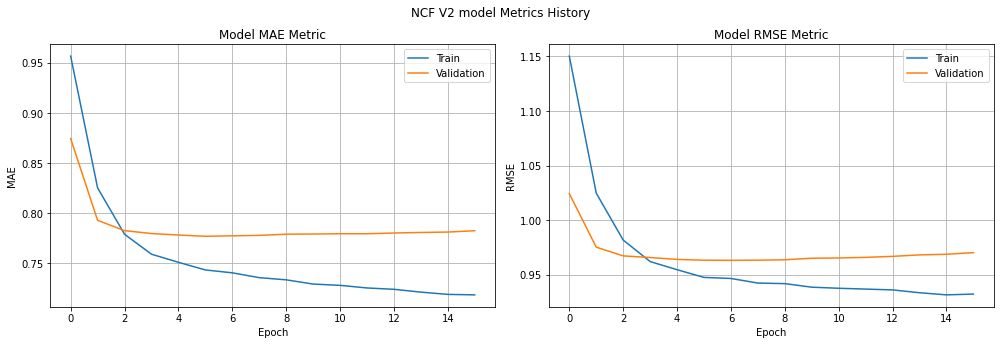

In [ ]:
plot_history(ncf_model_2_history, plot_title='NCF V2 model')

We can already see an improvement, our model suffers less from overfitting.

In [ ]:
loss_metrics_ncf_2 = ncf_model_2.evaluate([X_test_map['user_id'], X_test_map['movie_id']], y_test)

print(f'MAE: {loss_metrics_ncf_2[1]}')
print(f'RMSE: {loss_metrics_ncf_2[2]}')

625/625 [==============================] - 1s 1ms/step - loss: 0.7395 - mae: 0.7394 - root_mean_squared_error: 0.9469
MAE: 0.7393589019775391
RMSE: 0.9469417929649353


In [ ]:
prediction = ncf_model_2.predict([X_test_map['user_id'], X_test_map['movie_id']], batch_size=20)
test_pred = ratings_test.assign(rating_pred=prediction)
test_pred

user_id  movie_id  rating  unix_timestamp  rating_pred
0            0         5       5       887431973     3.823537
1            0         9       3       875693118     4.243023
2            0        11       5       878542960     4.879962
3            0        13       5       874965706     4.183180
4            0        16       3       875073198     3.458555
...        ...       ...     ...             ...          ...
19995      457       647       4       886395899     4.025693
19996      457      1100       4       886397931     3.967652
19997      458       933       3       879563639     2.956453
19998      459         9       3       882912371     3.460083
19999      461       681       5       886365231     3.908199

[20000 rows x 5 columns]

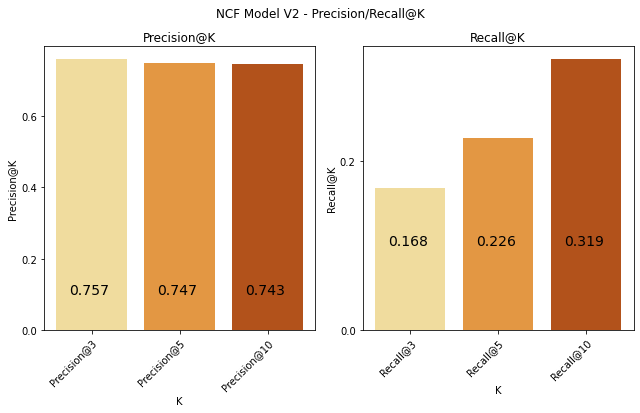

In [ ]:
mprk_ncf_2 = plot_model_precision_recall_at_k(test_pred, k=[3, 5, 10], plot_title='NCF Model V2')

We will now try and increase the amount of hidden layers from 1 to 3 (20 neuron wide) with dropout separating layers in our model to increase the learning capabilities of our NCF MLP side of the model.

In [ ]:
def create_ncf_model_2(num_users, num_movies, latent_dim, hidden_dim, loss_f, lr, dropout):
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    movie_input = Input(shape=(1,),dtype='int32', name='movie_input')

    # Matrix factorization embedding layer
    mf_embedding_user = Embedding(input_dim=num_users, output_dim=latent_dim, name='mf_user_embedding', input_length=1, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))
    mf_embedding_movie = Embedding(input_dim=num_movies, output_dim=latent_dim, name='mf_movie_embedding', input_length=1, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))

    mf_user_latent = Flatten(name='mf_user_latent')(mf_embedding_user(user_input))
    mf_movie_latent = Flatten(name='mf_movie_latent')(mf_embedding_movie(movie_input))

    # MLP embedding layer
    mlp_embedding_user = Embedding(input_dim=num_users, output_dim=latent_dim, name='mlp_user_embedding', input_length=1)
    mlp_embedding_movie = Embedding(input_dim=num_movies, output_dim=latent_dim, name='mlp_movie_embedding', input_length=1)

    mlp_user_latent = Flatten(name='mlp_user_latent')(mf_embedding_user(user_input))
    mlp_movie_latent = Flatten(name='mlp_movie_latent')(mf_embedding_movie(movie_input))

    # Element-wise product of user and movie embeddings
    gmf = Multiply(name='gmf_user_movie_element_wise_product')([mf_user_latent, mf_movie_latent])

    # MLP concatination
    mlp = Concatenate(name='mlp_concat')([mlp_user_latent, mlp_movie_latent])

    # MLP hidden layers
    drop1 = Dropout(0.1, name=f'drop1_{0.1}')(mlp)
    hidden1 = Dense(hidden_dim, activation='relu')(drop1)
    drop2 = Dropout(dropout, name=f'drop2_{dropout}')(hidden1)
    hidden2 = Dense(hidden_dim, activation='relu')(drop2)
    drop3 = Dropout(dropout, name=f'drop3_{dropout}')(hidden2)
    hidden3 = Dense(hidden_dim, activation='relu')(drop3)
    drop4 = Dropout(dropout, name=f'drop4_{dropout}')(hidden3)

    # GMF & MLP concatination
    ncf_concat = Concatenate(name='ncf_concat')([gmf, drop4])
    x = Dense(1, activation='sigmoid', kernel_initializer='he_normal', name='prediction')(ncf_concat)

    # Since we used sigmoid [0, 1] output from previous layer we reverse-normalize to our range [min_rating, max_rating]
    pred = Lambda(lambda value: reverse_min_max_normalize(value, min_rating, max_rating), name='min_max_normalize')(x)

    model = Model(inputs=[user_input, movie_input], outputs=pred) # , gender_input, age_input
    model.compile(loss=loss_f, optimizer=Adam(lr=lr), metrics=['mae', root_mean_squared_error])
    return model

In [ ]:
ncf_model_3 = create_ncf_model_2(num_users=rating_user_count, num_movies=rated_movie_count, latent_dim=20, hidden_dim=20, loss_f='mae', lr=0.0001, dropout=0.5)
ncf_model_3.summary()

Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
mf_user_embedding (Embedding)   (None, 1, 20)        18860       user_input[0][0]                 
                                                                 user_input[0][0]                 
__________________________________________________________________________________________________
mf_movie_embedding (Embedding)  (None, 1, 20)        33640       movie_input[0][0]         

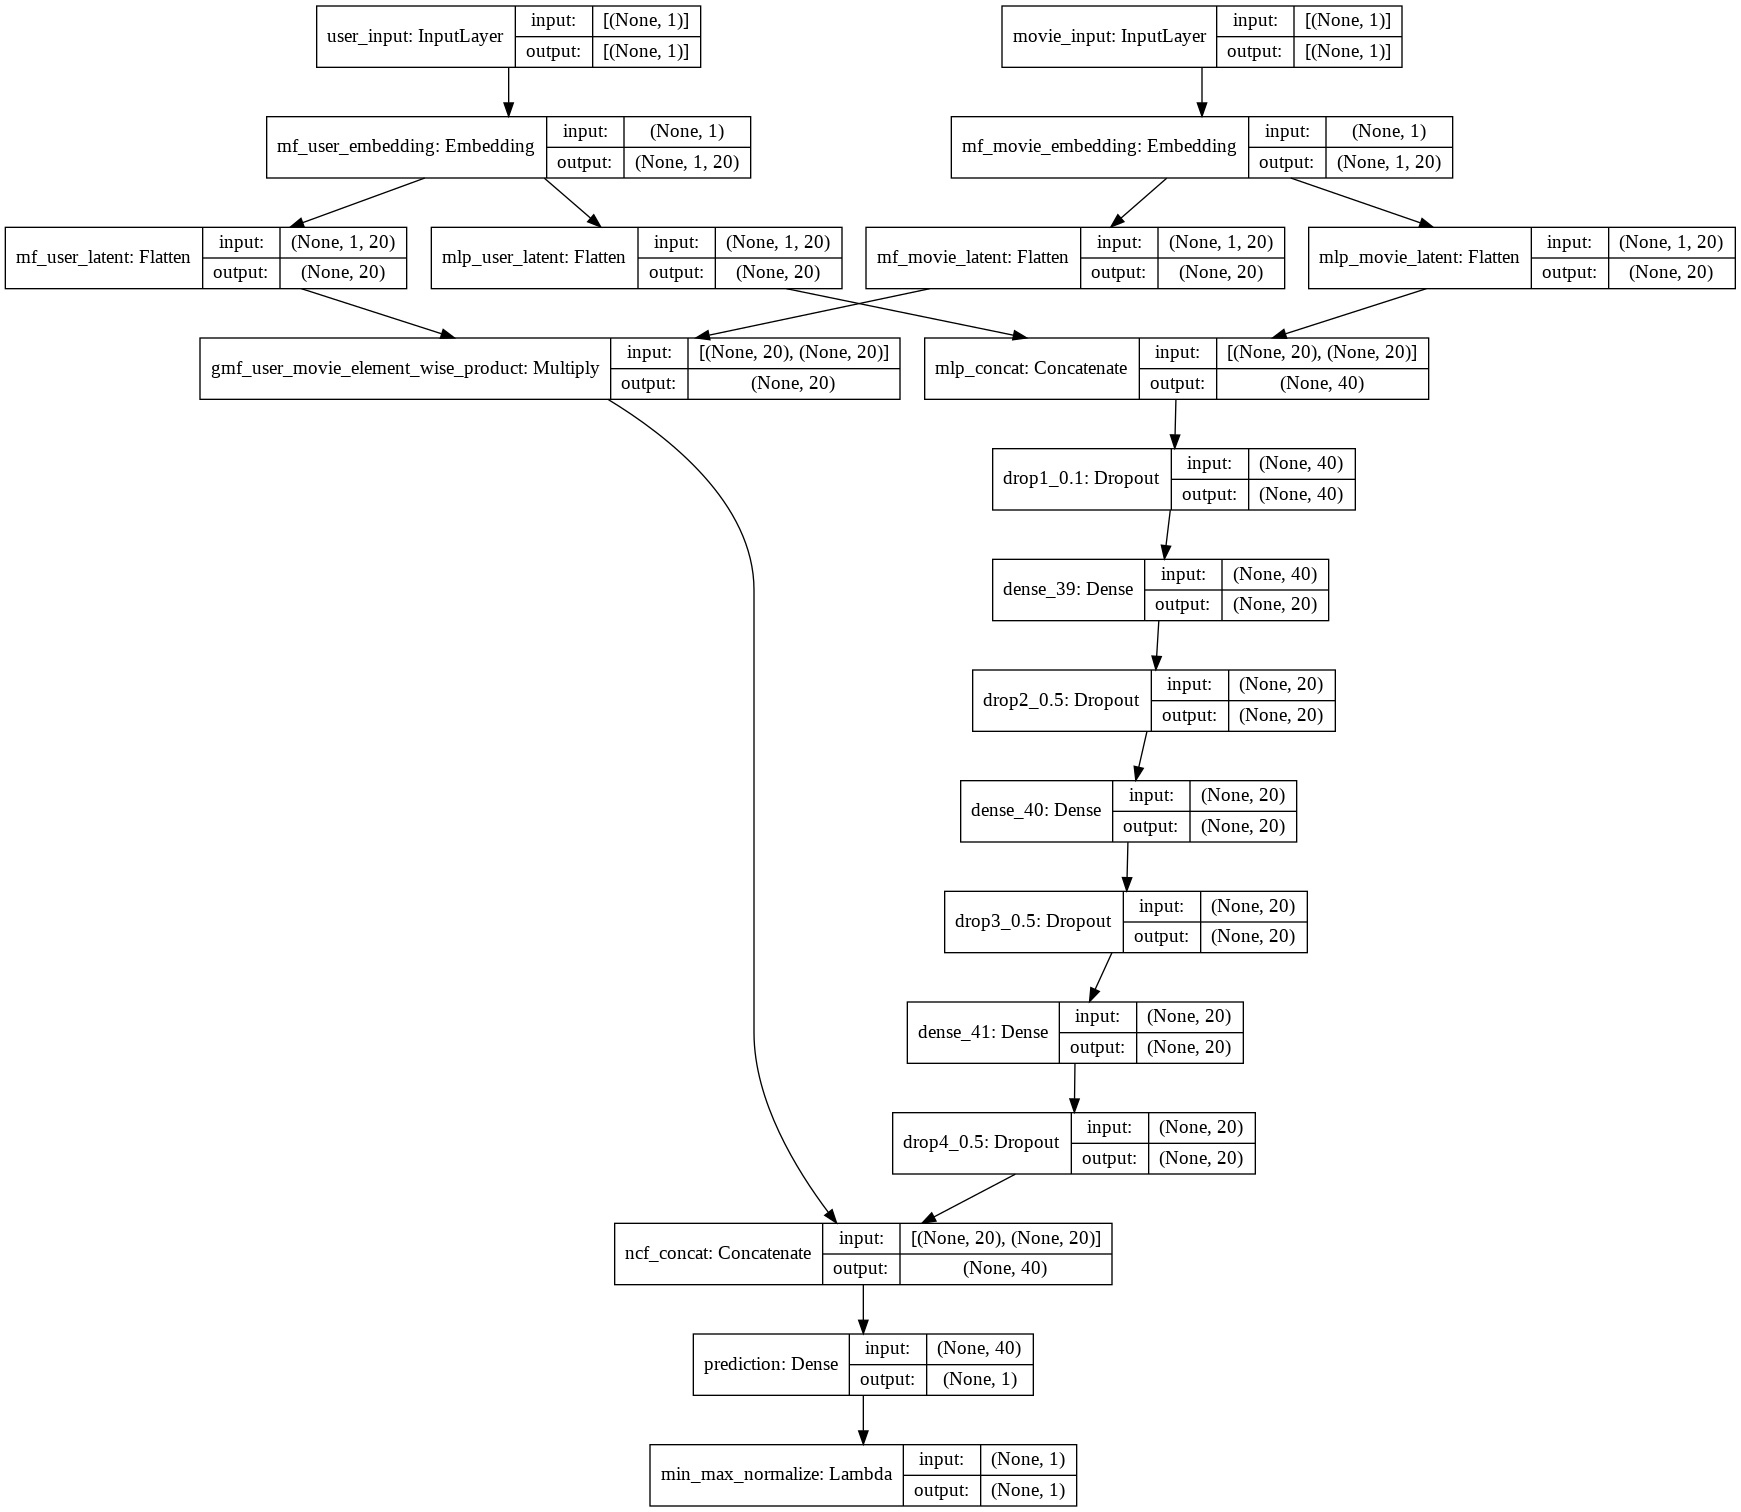

In [ ]:
plot_model(ncf_model_3, "ncf_model_3.png", show_shapes=True)

In [ ]:
train_time_callback_3, callbacks = create_callbacks('ncf_model_3')
ncf_model_3_history = ncf_model_3.fit([X_train_map['user_id'], X_train_map['movie_id']], y_train, epochs=25, validation_split=.1, verbose=1, callbacks=callbacks, batch_size=32)

Epoch 1/25
2250/2250 [==============================] - 7s 3ms/step - loss: 0.9765 - mae: 0.9765 - root_mean_squared_error: 1.1873 - val_loss: 0.8875 - val_mae: 0.8874 - val_root_mean_squared_error: 1.0408
Epoch 2/25
2250/2250 [==============================] - 6s 3ms/step - loss: 0.9191 - mae: 0.9190 - root_mean_squared_error: 1.1189 - val_loss: 0.8428 - val_mae: 0.8427 - val_root_mean_squared_error: 1.0060
Epoch 3/25
2250/2250 [==============================] - 6s 3ms/step - loss: 0.8691 - mae: 0.8690 - root_mean_squared_error: 1.0699 - val_loss: 0.8017 - val_mae: 0.8017 - val_root_mean_squared_error: 0.9823
Epoch 4/25
2250/2250 [==============================] - 6s 3ms/step - loss: 0.8183 - mae: 0.8182 - root_mean_squared_error: 1.0320 - val_loss: 0.7918 - val_mae: 0.7918 - val_root_mean_squared_error: 0.9855
Epoch 5/25
2250/2250 [==============================] - 6s 2ms/step - loss: 0.7983 - mae: 0.7982 - root_mean_squared_error: 1.0209 - val_loss: 0.7922 - val_mae: 0.7921 - val_ro

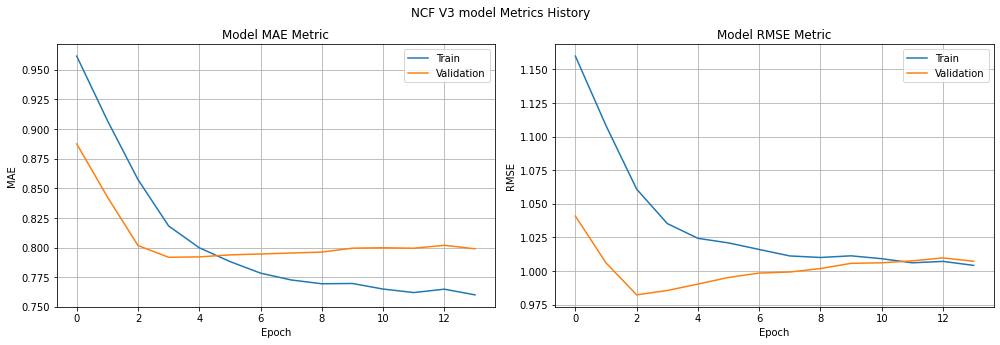

In [ ]:
plot_history(ncf_model_3_history, plot_title='NCF V3 model')

In [ ]:
loss_metrics_ncf_3 = ncf_model_3.evaluate([X_test_map['user_id'], X_test_map['movie_id']], y_test)

print(f'MAE: {loss_metrics_ncf_3[1]}')
print(f'RMSE: {loss_metrics_ncf_3[2]}')

625/625 [==============================] - 1s 1ms/step - loss: 0.7855 - mae: 0.7854 - root_mean_squared_error: 1.0198
MAE: 0.7854375243186951
RMSE: 1.0197725296020508


In [ ]:
prediction = ncf_model_3.predict([X_test_map['user_id'], X_test_map['movie_id']], batch_size=20)
test_pred = ratings_test.assign(rating_pred=prediction)
test_pred

user_id  movie_id  rating  unix_timestamp  rating_pred
0            0         5       5       887431973     4.339095
1            0         9       3       875693118     4.568455
2            0        11       5       878542960     4.988988
3            0        13       5       874965706     4.396618
4            0        16       3       875073198     3.649216
...        ...       ...     ...             ...          ...
19995      457       647       4       886395899     4.133552
19996      457      1100       4       886397931     4.113035
19997      458       933       3       879563639     2.999519
19998      459         9       3       882912371     3.334958
19999      461       681       5       886365231     4.054100

[20000 rows x 5 columns]

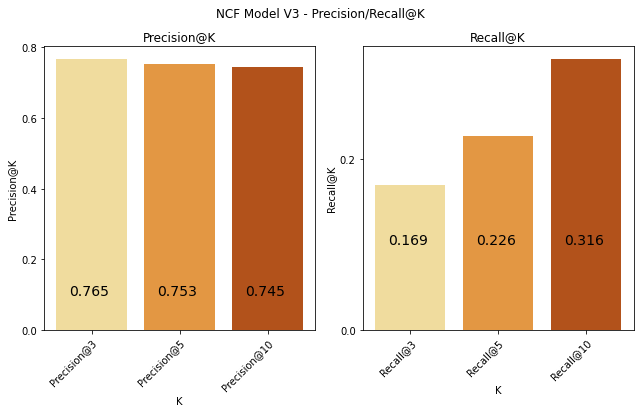

In [ ]:
mprk_ncf_3 = plot_model_precision_recall_at_k(test_pred, k=[3, 5, 10], plot_title='NCF Model V3')

We will try to make to model 'wider' by increasing the amount of neurons from 20 to 64 in each of the 3 hidden layers in the MLP side of the model.

In [ ]:
ncf_model_4 = create_ncf_model_2(num_users=rating_user_count, num_movies=rated_movie_count, latent_dim=64, hidden_dim=64, loss_f='mae', lr=0.0001, dropout=0.5)
ncf_model_4.summary()

Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
mf_user_embedding (Embedding)   (None, 1, 64)        60352       user_input[0][0]                 
                                                                 user_input[0][0]                 
__________________________________________________________________________________________________
mf_movie_embedding (Embedding)  (None, 1, 64)        107648      movie_input[0][0]         

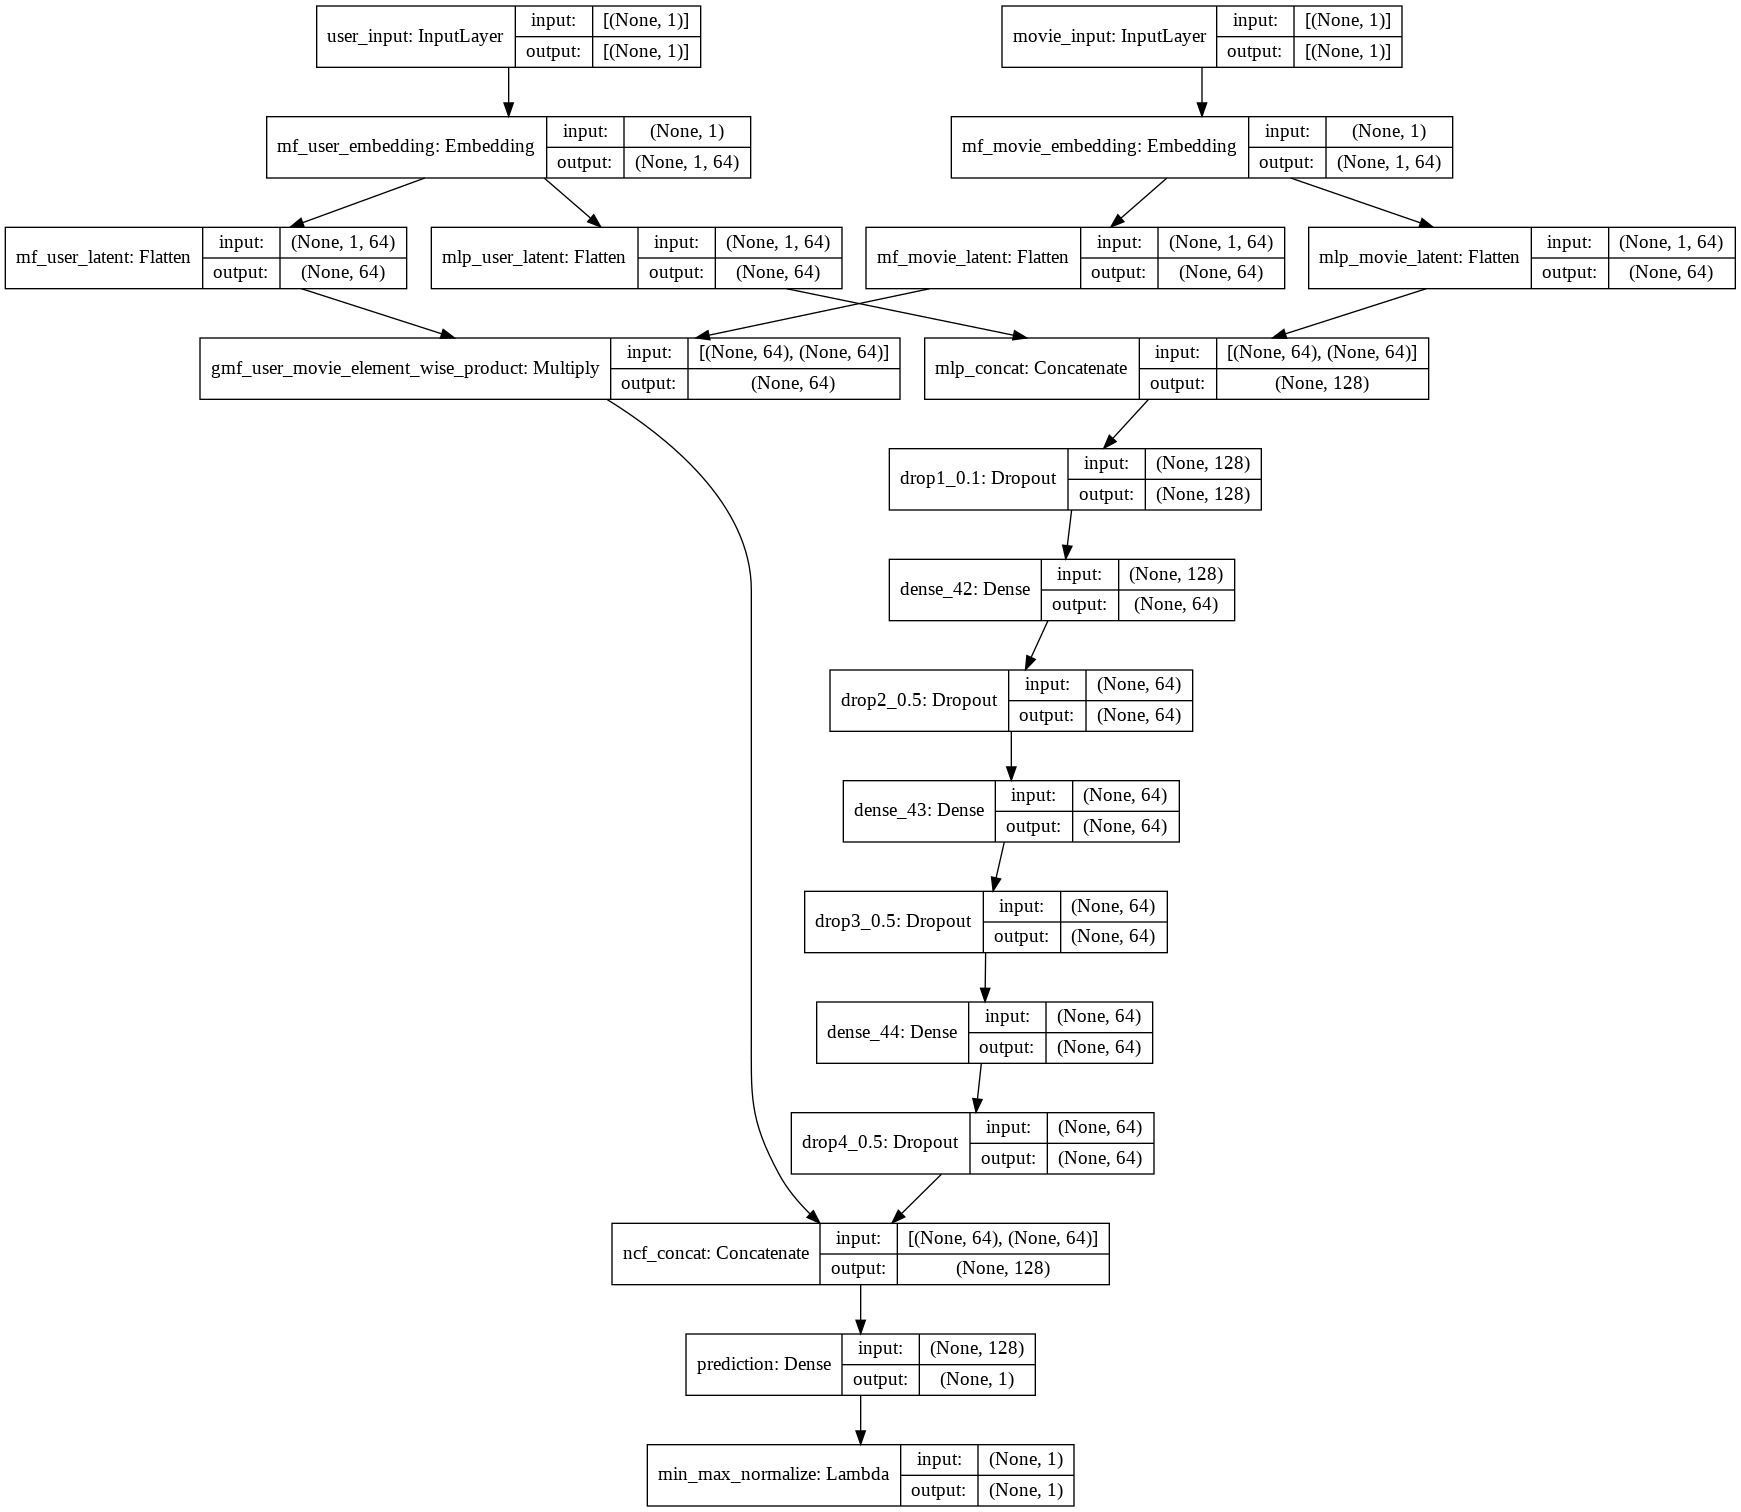

In [ ]:
plot_model(ncf_model_4, "ncf_model_4.png", show_shapes=True)

In [ ]:
train_time_callback_4, callbacks = create_callbacks('ncf_model_4')
ncf_model_4_history = ncf_model_4.fit([X_train_map['user_id'], X_train_map['movie_id']], y_train, epochs=25, validation_split=.1, verbose=1, callbacks=callbacks, batch_size=32)

Epoch 1/25
2250/2250 [==============================] - 11s 4ms/step - loss: 0.9688 - mae: 0.9685 - root_mean_squared_error: 1.1776 - val_loss: 0.8410 - val_mae: 0.8407 - val_root_mean_squared_error: 1.0099
Epoch 2/25
2250/2250 [==============================] - 10s 4ms/step - loss: 0.8315 - mae: 0.8313 - root_mean_squared_error: 1.0392 - val_loss: 0.7938 - val_mae: 0.7936 - val_root_mean_squared_error: 0.9850
Epoch 3/25
2250/2250 [==============================] - 9s 4ms/step - loss: 0.7728 - mae: 0.7725 - root_mean_squared_error: 0.9890 - val_loss: 0.7899 - val_mae: 0.7897 - val_root_mean_squared_error: 0.9836
Epoch 4/25
2250/2250 [==============================] - 9s 4ms/step - loss: 0.7590 - mae: 0.7588 - root_mean_squared_error: 0.9785 - val_loss: 0.7910 - val_mae: 0.7907 - val_root_mean_squared_error: 0.9836
Epoch 5/25
2250/2250 [==============================] - 9s 4ms/step - loss: 0.7522 - mae: 0.7519 - root_mean_squared_error: 0.9756 - val_loss: 0.7895 - val_mae: 0.7892 - val_

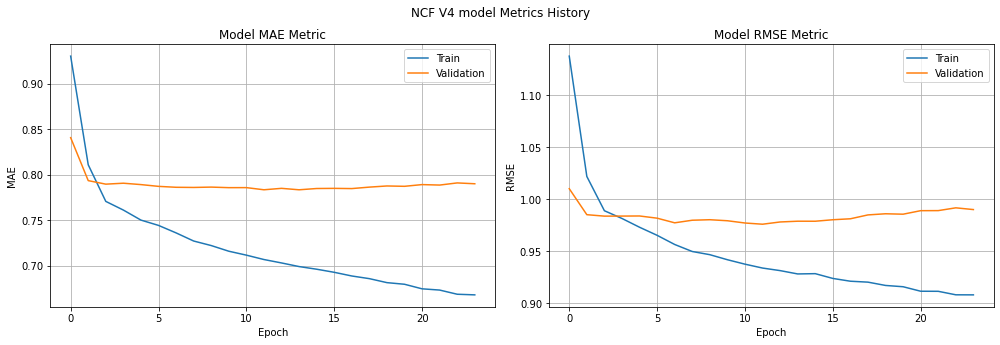

In [ ]:
plot_history(ncf_model_4_history, plot_title='NCF V4 model')

In [ ]:
loss_metrics_ncf_4 = ncf_model_4.evaluate([X_test_map['user_id'], X_test_map['movie_id']], y_test)

print(f'MAE: {loss_metrics_ncf_4[1]}')
print(f'RMSE: {loss_metrics_ncf_4[2]}')

625/625 [==============================] - 1s 2ms/step - loss: 0.7260 - mae: 0.7257 - root_mean_squared_error: 0.9612
MAE: 0.7257158160209656
RMSE: 0.9612079858779907


In [ ]:
prediction = ncf_model_4.predict([X_test_map['user_id'], X_test_map['movie_id']], batch_size=20)
test_pred = ratings_test.assign(rating_pred=prediction)
test_pred

user_id  movie_id  rating  unix_timestamp  rating_pred
0            0         5       5       887431973     4.493304
1            0         9       3       875693118     4.193358
2            0        11       5       878542960     4.958766
3            0        13       5       874965706     4.445634
4            0        16       3       875073198     3.100778
...        ...       ...     ...             ...          ...
19995      457       647       4       886395899     3.963994
19996      457      1100       4       886397931     3.848687
19997      458       933       3       879563639     2.999002
19998      459         9       3       882912371     3.549572
19999      461       681       5       886365231     4.190098

[20000 rows x 5 columns]

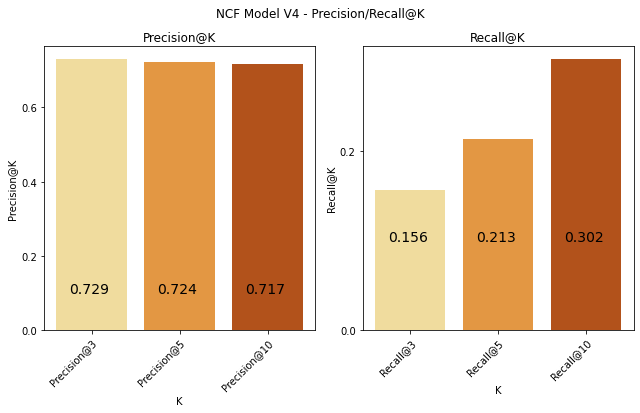

In [ ]:
mprk_ncf_4 = plot_model_precision_recall_at_k(test_pred, k=[3, 5, 10], plot_title='NCF Model V4')

## Section 4.c.

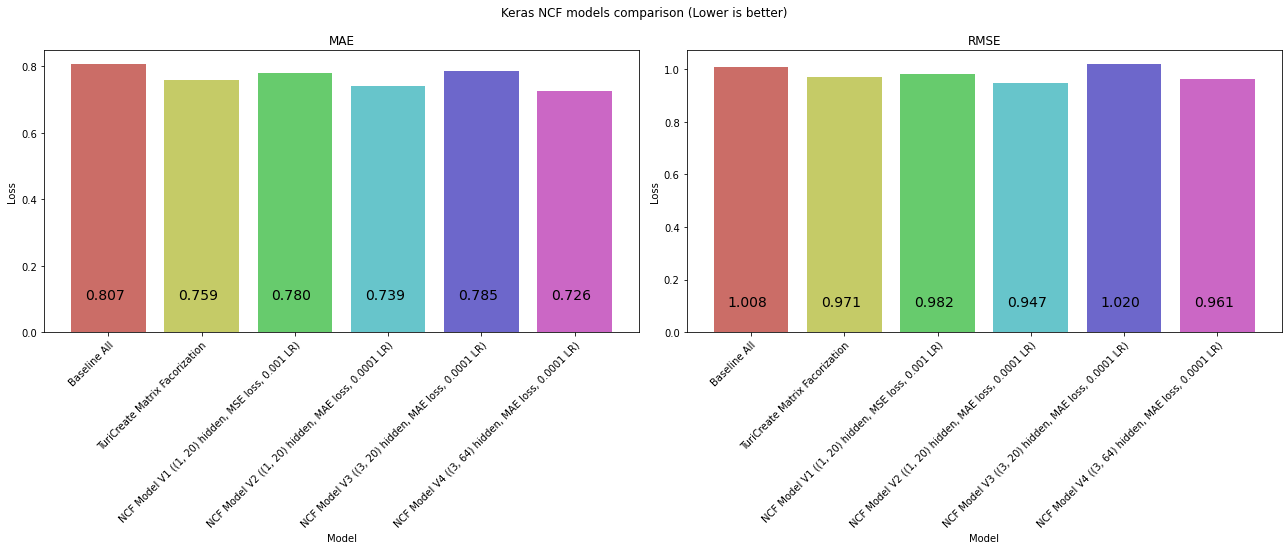

In [ ]:
plot_model_loss_comparison(losses={'Baseline All': {'mae': basemodel_loss["MAE"], 'rmse': basemodel_loss["RMSE"]},
                                   'TuriCreate Matrix Facorization': {'mae': mae(test_data["rating"], y_pred_mf), 'rmse': rmse(np.array(test_data["rating"]), np.array(y_pred_mf))},
                                    'NCF Model V1 ((1, 20) hidden, MSE loss, 0.001 LR)': {'mae': loss_metrics_ncf_1[1], 'rmse': loss_metrics_ncf_1[2]},
                                    'NCF Model V2 ((1, 20) hidden, MAE loss, 0.0001 LR)': {'mae': loss_metrics_ncf_2[1], 'rmse': loss_metrics_ncf_2[2]},
                                    'NCF Model V3 ((3, 20) hidden, MAE loss, 0.0001 LR)': {'mae': loss_metrics_ncf_3[1], 'rmse': loss_metrics_ncf_3[2]},
                                    'NCF Model V4 ((3, 64) hidden, MAE loss, 0.0001 LR)': {'mae': loss_metrics_ncf_4[1], 'rmse': loss_metrics_ncf_4[2]},
                                   },
                            plot_title='Keras NCF models comparison', high=True)

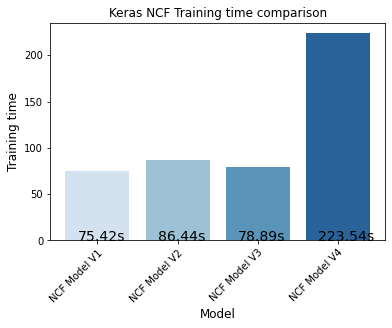

In [ ]:
plot_model_train_time_comparison(times={'NCF Model V1': train_time_callback_1.train_time_end,
                                      'NCF Model V2': train_time_callback_2.train_time_end,
                                      'NCF Model V3': train_time_callback_3.train_time_end,
                                      'NCF Model V4': train_time_callback_4.train_time_end}, plot_title='Keras NCF Training time comparison')

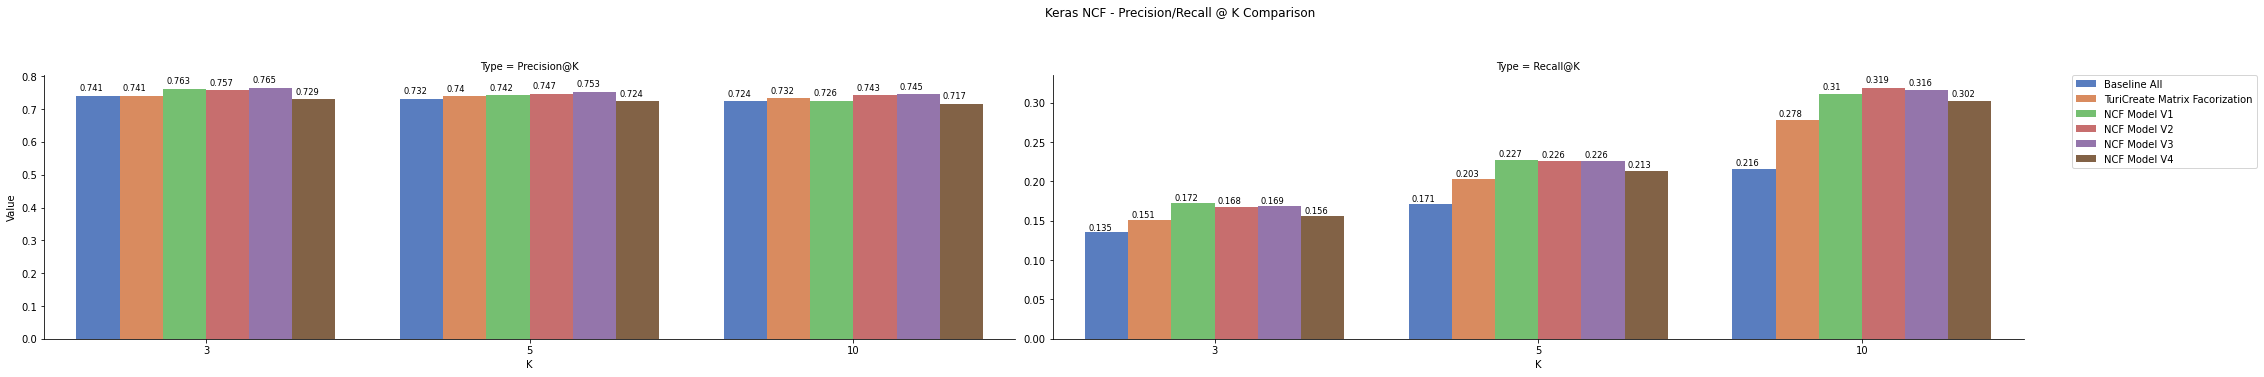

In [ ]:
plot_model_precision_recall_at_k_comparison(data={
                                      'Baseline All': mprk_baseline_all,
                                      'TuriCreate Matrix Facorization': mprk_mf,
                                      'NCF Model V1': mprk_ncf_1,
                                      'NCF Model V2': mprk_ncf_2,
                                      'NCF Model V3': mprk_ncf_3,
                                      'NCF Model V4': mprk_ncf_4,
                                   },
                                    plot_title='Keras NCF', wide=True)

# Question 5 - Adding Extra User and Movie data to our models (DeepFM)

DeepFM, combines the power of factorization machines for recommendation and deep learning for feature learning in a new neural network architecture.

Compared to the latest Wide \& Deep model from Google, DeepFM has a shared input to its "wide" and "deep" parts, with no need of feature engineering besides raw features.

DeepFM consists of an FM component and a deep component which are integrated in a parallel structure. The FM component is the same as the 2-way factorization machines which is used to model the low-order feature interactions.
The deep component is a multi-layered perceptron that is used to capture high-order feature interactions and nonlinearities.
These two components share the same inputs/embeddings and their outputs are summed up as the final prediction.

The advantages of DeepFM over the Wide & Deep model is that it reduces the effort of hand-crafted feature engineering by identifying feature combinations automatically.

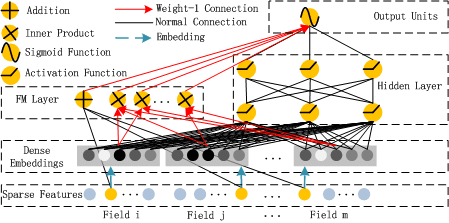


## Section 5.a.

### Preprocessing

In order to feed the model with additional features we need to first preprocess them.
We will use the following features from each user:
- Age - No preprocessing needed
- Gender - We convert the 'M' and 'F' (male and female) values in the dataset to a binary 1 and 0.

We will use the following features in regards to each movie:
- Genres - will require preprocessing since the genres are present as binary columns in the dataset, we will first extract them to a list of genres for each movie and then encode them to a sequence of genres in the length of the max genres per movie in the dataset, we will get a list of number encoding that represent the different genres.

In [ ]:
def text2seq(text, n_genre, vec_size):
  """ using tokenizer to encoded the multi-level categorical feature"""
  tokenizer = Tokenizer(lower=True, split='|',filters='', num_words=n_genre)
  tokenizer.fit_on_texts(text)
  seq = tokenizer.texts_to_sequences(text)
  seq = pad_sequences(seq, maxlen=vec_size, padding='post')
 
  return seq

Extract the movie genres from binary column into a list of genres

In [ ]:
num_generes = len(genre_cols)

condense_movies = movies.apply(lambda row: condense_binary_row(row, 'genres', genre_cols), axis=1)[['movie_id', 'genres']]
max_movie_genres = max(condense_movies['genres'].str.len())
movies_details = pd.merge(pd.Series(X_train_map['movie_id'], name='movie_id'), condense_movies, on='movie_id')

movies_details

movie_id                         genres
0             0  [Animation, Children, Comedy]
1             0  [Animation, Children, Comedy]
2             0  [Animation, Children, Comedy]
3             0  [Animation, Children, Comedy]
4             0  [Animation, Children, Comedy]
...         ...                            ...
79995      1678            [Romance, Thriller]
79996      1679               [Drama, Romance]
79997       906                       [Comedy]
79998      1680                       [Comedy]
79999      1681                        [Drama]

[80000 rows x 2 columns]

Convert the genres for each movie to a sequence representing the genres for each movie.

In [ ]:
condense_movies['genres'] = text2seq(condense_movies['genres'].values, n_genre=num_generes, vec_size=max_movie_genres).tolist()
condense_movies

movie_id               genres
0            0  [15, 7, 2, 0, 0, 0]
1            1   [3, 6, 4, 0, 0, 0]
2            2   [4, 0, 0, 0, 0, 0]
3            3   [3, 2, 1, 0, 0, 0]
4            4   [8, 1, 4, 0, 0, 0]
...        ...                  ...
1677      1677   [1, 0, 0, 0, 0, 0]
1678      1678   [5, 4, 0, 0, 0, 0]
1679      1679   [1, 5, 0, 0, 0, 0]
1680      1680   [2, 0, 0, 0, 0, 0]
1681      1681   [1, 0, 0, 0, 0, 0]

[1682 rows x 2 columns]

Add users gender and age features to our training and testing data.
(With conversion of gender 'M' and 'F' to 1 and 0)

In [ ]:
movie_details = pd.merge(pd.Series(X_train_map['movie_id'], name='movie_id'), condense_movies, on='movie_id')
X_train_map['genres'] = np.array([np.array(x) for x in movie_details['genres'].values])

movie_details = pd.merge(pd.Series(X_test_map['movie_id'], name='movie_id'), condense_movies, on='movie_id')
X_test_map['genres'] =  np.array([np.array(x) for x in movie_details['genres'].values])

In [ ]:
users_details = pd.merge(pd.Series(X_train_map['user_id'], name='user_id'), users, on='user_id')
X_train_map['gender'] = users_details['sex'].apply(lambda g: 1 if g == 'M' else 0).values.astype(np.int32)
X_train_map['age'] = users_details['age'].values.astype(np.int32)

users_details = pd.merge(pd.Series(X_test_map['user_id'], name='user_id'), users, on='user_id')
X_test_map['gender'] = users_details['sex'].apply(lambda g: 1 if g == 'M' else 0).values.astype(np.int32)
X_test_map['age'] = users_details['age'].values.astype(np.int32)

max_age = users['age'].max() + 1

print(f'Train data shapes: user_id: {X_train_map["user_id"].shape}, movie_id: {X_train_map["movie_id"].shape}, gender: {X_train_map["gender"].shape}, age: {X_train_map["age"].shape}, genres: {X_train_map["genres"].shape}')
print(f'Test data shapes: user_id: {X_test_map["user_id"].shape}, movie_id: {X_test_map["movie_id"].shape}, gender: {X_test_map["gender"].shape}, age: {X_test_map["age"].shape}, genres: {X_test_map["genres"].shape}')

Train data shapes: user_id: (80000,), movie_id: (80000,), gender: (80000,), age: (80000,), genres: (80000, 6)
Test data shapes: user_id: (20000,), movie_id: (20000,), gender: (20000,), age: (20000,), genres: (20000, 6)


## Section 5.b.

#### DeepFM model architecture

- 1st order embedded layers to have overall characterization of individual features.

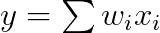

- 2nd order shared embedded layers for both deep and FM parts, from which dot product between pairs of embedded features address the 2nd order feature interactions.

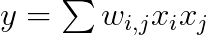

#### 1st order factorization machines (summation of all 1st order embed layers)

- numeric features with shape (None, 1) => dense layer

- categorical features (single level) with shape (None,1) => embedding layer (latent_dim = 1)

- categorical features (multi level) with shape (None,L) => embedding layer (latent_dim = 1)

- output will summation of all embedded features

#### 2nd order factorization machines (summation of dot product between 2nd order embed layers)
- numeric features => dense layer

- categorical features (single level) => embedding layer (latent_dim = k)

- categorical features (multi level) with shape (None,L) => embedding layer (latent_dim = k)

- shared embed layer will be the concatenated layers of all embedded features

- shared embed layer => dot layer => 2nd order of FM part

#### Deep part (DNN model on shared embed layers)
- shared embed layer => series of dense layers => deep part


#### 1st order factorization machines
1st order will require features to map to a scalar.

In [ ]:
def Tensor_Mean_Pooling(name='mean_pooling', keepdims=False):
  return Lambda(lambda x: K.mean(x, axis = 1, keepdims=keepdims), name=name)
 
def fm_add(inputs, num_users, num_movies, latent_dim, num_genres, max_age):
  user_input, movie_input, genre_input, gender_input, age_input = inputs

  fm_1d_embedding_user = Embedding(input_dim=num_users, output_dim=latent_dim, name='fm_1d_user_embedding', input_length=1, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))
  fm_1d_user_latent = Flatten(name='fm_1d_user_latent')(fm_1d_embedding_user(user_input))

  fm_1d_embedding_movie = Embedding(input_dim=num_movies, output_dim=latent_dim, name='fm_1d_movie_embedding', input_length=1, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))
  fm_1d_movie_latent = Flatten(name='fm_1d_movie_latent')(fm_1d_embedding_movie(movie_input))
  
  cat_genre_embed_1d = Embedding(input_dim=num_genres + 1, output_dim=latent_dim, mask_zero=True, name='cat_embed_1d_genre', input_length=max_movie_genres, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))(genre_input)
  fm_1d_genre_mean = Tensor_Mean_Pooling(name='fm_1d_genre_mean')(cat_genre_embed_1d)

  fm_1d_embedding_gender = Embedding(input_dim=2, output_dim=latent_dim, name='fm_1d_gender_embedding', mask_zero=False, input_length=1, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))
  fm_1d_gender_latent = Flatten(name='fm_1d_gender_latent')(fm_1d_embedding_gender(gender_input))

  fm_1d_embedding_age = Embedding(input_dim=max_age, output_dim=latent_dim, name='fm_1d_age_embedding', input_length=1, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))
  fm_1d_age_latent = Flatten(name='fm_1d_age_latent')(fm_1d_embedding_age(age_input))

  # Add tensors to produce scalar value
  y_fm_1d = Add(name = 'fm_1d_output')([fm_1d_user_latent, fm_1d_movie_latent, fm_1d_gender_latent, fm_1d_age_latent, fm_1d_genre_mean])
  return y_fm_1d

#### 2nd order FM, each feature stack to concat_embed_2d layer with shape (None, p, k).

k – matrix factorization latent dimension, p is feature dimension.

the calculation of interaction terms can be simplified, using:

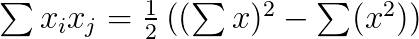

In [ ]:
def fm_interactions(inputs, num_users, num_movies, latent_dim, num_genres, max_age):
  user_input, movie_input, genre_input, gender_input, age_input = inputs
  
  fm_2d_embedding_user = Embedding(input_dim=num_users, output_dim=latent_dim, name='fm_2d_user_embedding', input_length=1, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))(user_input)
  fm_2d_embedding_movie = Embedding(input_dim=num_movies, output_dim=latent_dim, name='fm_2d_movie_embedding', input_length=1, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))(movie_input)

  cat_genre_embed_2d = Embedding(input_dim=num_genres + 1, output_dim=latent_dim, mask_zero=True, name='cat_embed_2d_genre', input_length=max_movie_genres, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))(genre_input)
  fm_2d_genre_mean = Tensor_Mean_Pooling(name='fm_2d_genre_mean', keepdims=True)(cat_genre_embed_2d)

  fm_2d_embedding_gender = Embedding(input_dim=2, output_dim=latent_dim, name='fm_2d_gender_embedding', mask_zero=False, input_length=1, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))(gender_input)

  fm_2d_embedding_age = Embedding(input_dim=max_age, output_dim=latent_dim, name='fm_2d_age_embedding', input_length=1, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))(age_input)

  # Concatenate all 2d embed layers => (None, 1, latent_dim)
  embed_2d = Concatenate(axis=1, name = 'concat_embed_2d')([fm_2d_embedding_user, fm_2d_embedding_movie, fm_2d_genre_mean, fm_2d_embedding_gender, fm_2d_embedding_age])

  # calcuate the interactions by simplication
  # sum of (x1*x2) = sum of (0.5*[(xi)^2 - (xi^2)])
  sum_of_embed = Lambda(lambda x: K.sum(x, axis=1), name = 'embed_2d_sum')(embed_2d)
  square_of_sum = Multiply(name='square_of_sum')([sum_of_embed, sum_of_embed])
  square_of_embed = Multiply(name='square_of_embed')([embed_2d, embed_2d])
  sum_of_square = Lambda(lambda x: K.sum(x, axis=1), name = 'embed_2d_square_embed_sum')(square_of_embed)
  sub = Subtract(name='sub_square_of_sum_sum_of_square')([square_of_sum, sum_of_square])
  half = Lambda(lambda x: x*0.5, name='divide_by_2')(sub)
  sum_of_half = Lambda(lambda x: K.sum(x, axis=1), name = 'embed_2d_half_sum')(half)

  y_fm_2d = Flatten(name = 'fm_2d_output')(sum_of_half)
  
  return y_fm_2d, embed_2d

#### Deep Part (DNN)

In [ ]:
def dnn(embed_2d, dnn_dims, dropout):
  # Flat embed layers from 3D to 2D tensors
  y_dnn = Flatten(name = 'flat_embed_2d')(embed_2d)
  for hidden_dim in dnn_dims:
    y_dnn = Dropout(dropout)(y_dnn)
    y_dnn = Dense(hidden_dim, activation='relu')(y_dnn)
  y_dnn = Dropout(dropout)(y_dnn)
  y_dnn = Dense(1, activation='relu')(y_dnn)
  y_dnn = Flatten(name = 'deep_output')(y_dnn)

  return y_dnn

In [ ]:
def deepfm_model(num_users, num_movies, num_genres, max_age, latent_dim, dnn_dims, dropout):
  user_input = Input(shape=(1,), dtype='int32', name='user_input')
  movie_input = Input(shape=(1,),dtype='int32', name='movie_input')
  genre_input = Input(shape=(max_movie_genres,), name='genre_input')
  gender_input = Input(shape=(1,),dtype='int32', name='gender_input')
  age_input = Input(shape=(1,),dtype='int32', name='age_input')
  inputs = [user_input, movie_input, genre_input, gender_input, age_input]

  y_fm_1d = fm_add(inputs, num_users=num_users, num_movies=num_movies, latent_dim=1, num_genres=num_genres, max_age=max_age)
  y_fm_2d, embed_2d = fm_interactions(inputs, num_users=num_users, num_movies=num_movies, latent_dim=latent_dim, num_genres=num_generes, max_age=max_age)
  y_dnn = dnn(embed_2d, dnn_dims, dropout)
  
  # Combined deep and fm parts
  y = Concatenate()([y_fm_1d, y_fm_2d, y_dnn])
  
  y = Dense(1, activation='sigmoid', name = 'deepfm_output')(y)
  pred = Lambda(lambda value: reverse_min_max_normalize(value, min_rating, max_rating), name='min_max_normalize')(y)
  
  fm_model_1d = Model(inputs, y_fm_1d)
  fm_model_2d = Model(inputs, y_fm_2d)
  deep_model = Model(inputs, y_dnn)
  deepfm_model = Model(inputs, pred)

  return fm_model_1d, fm_model_2d, deep_model, deepfm_model

In [ ]:
fm_model_1d, fm_model_2d, deep_model, deepfm_model = deepfm_model(num_users=rating_user_count, num_movies=rated_movie_count, num_genres=num_generes, max_age=max_age, latent_dim=20, dnn_dims=[32, 32, 32], dropout=0.5)
deepfm_model.summary()

Model: "model_49"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
genre_input (InputLayer)        [(None, 6)]          0                                            
__________________________________________________________________________________________________
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
gender_input (InputLayer)       [(None, 1)]          0                                            
___________________________________________________________________________________________

#### 1st order factorization machines plot

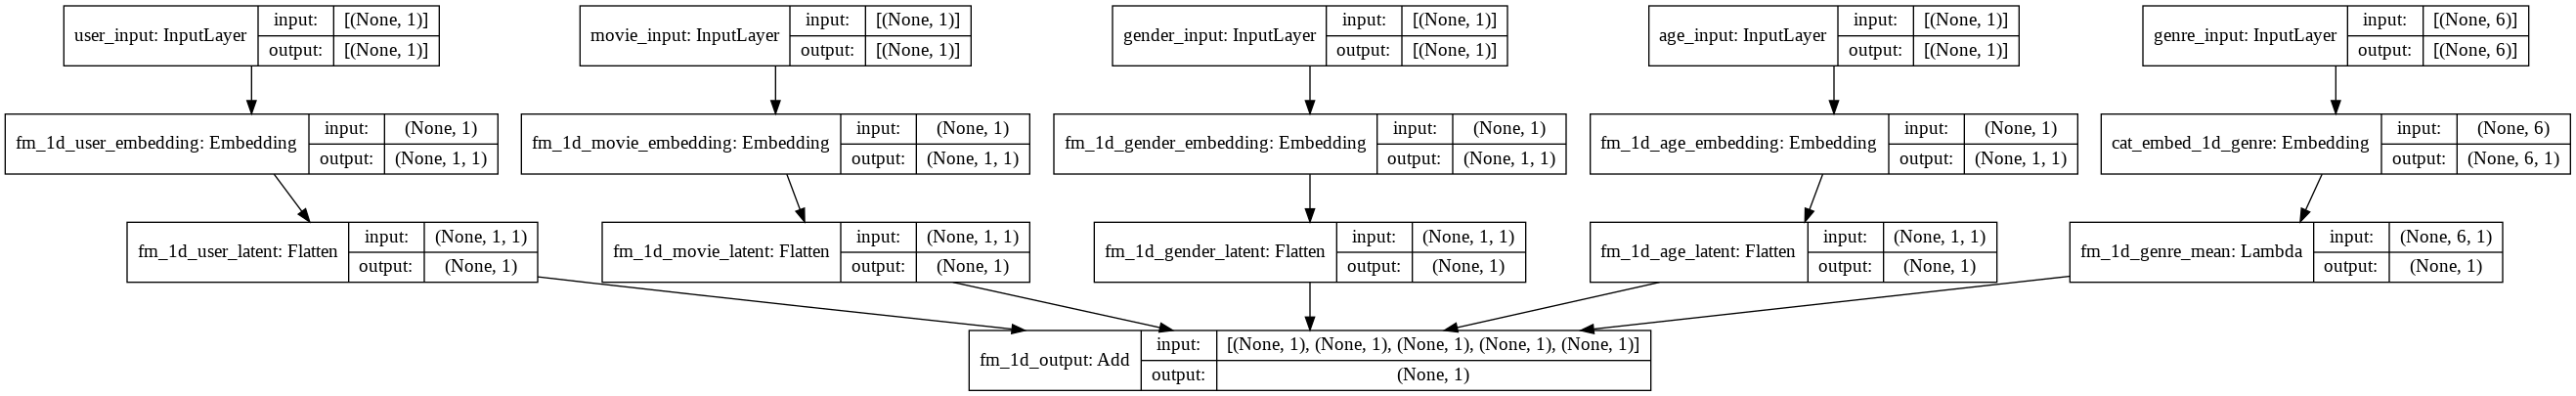

In [ ]:
plot_model(fm_model_1d, "deepfm_1d.png", show_shapes=True)

#### 2st order factorization machines plot

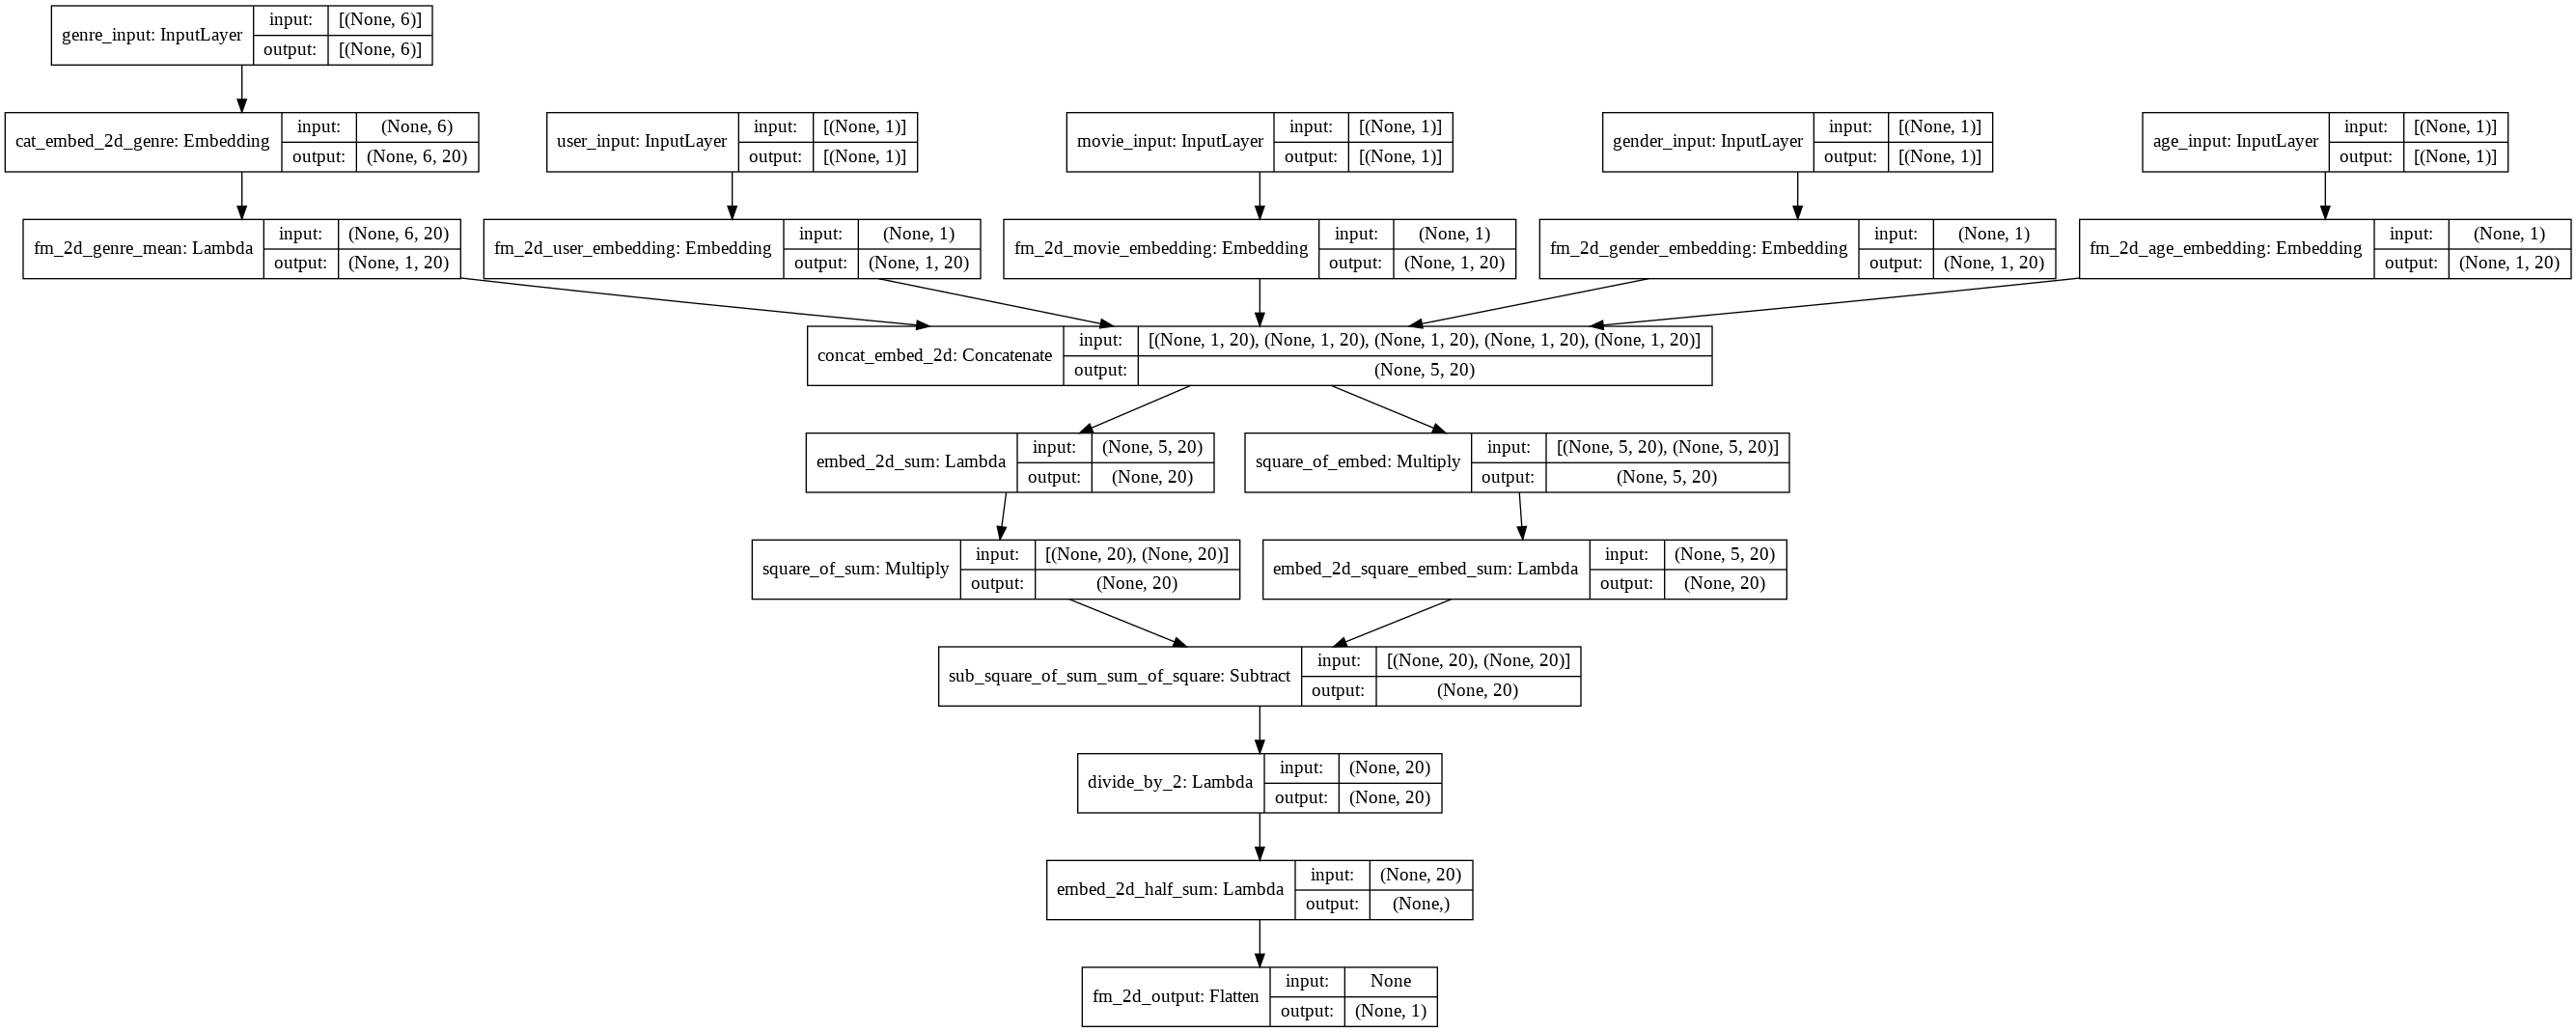

In [ ]:
plot_model(fm_model_2d, "deepfm_2d.png", show_shapes=True)

DNN part plot

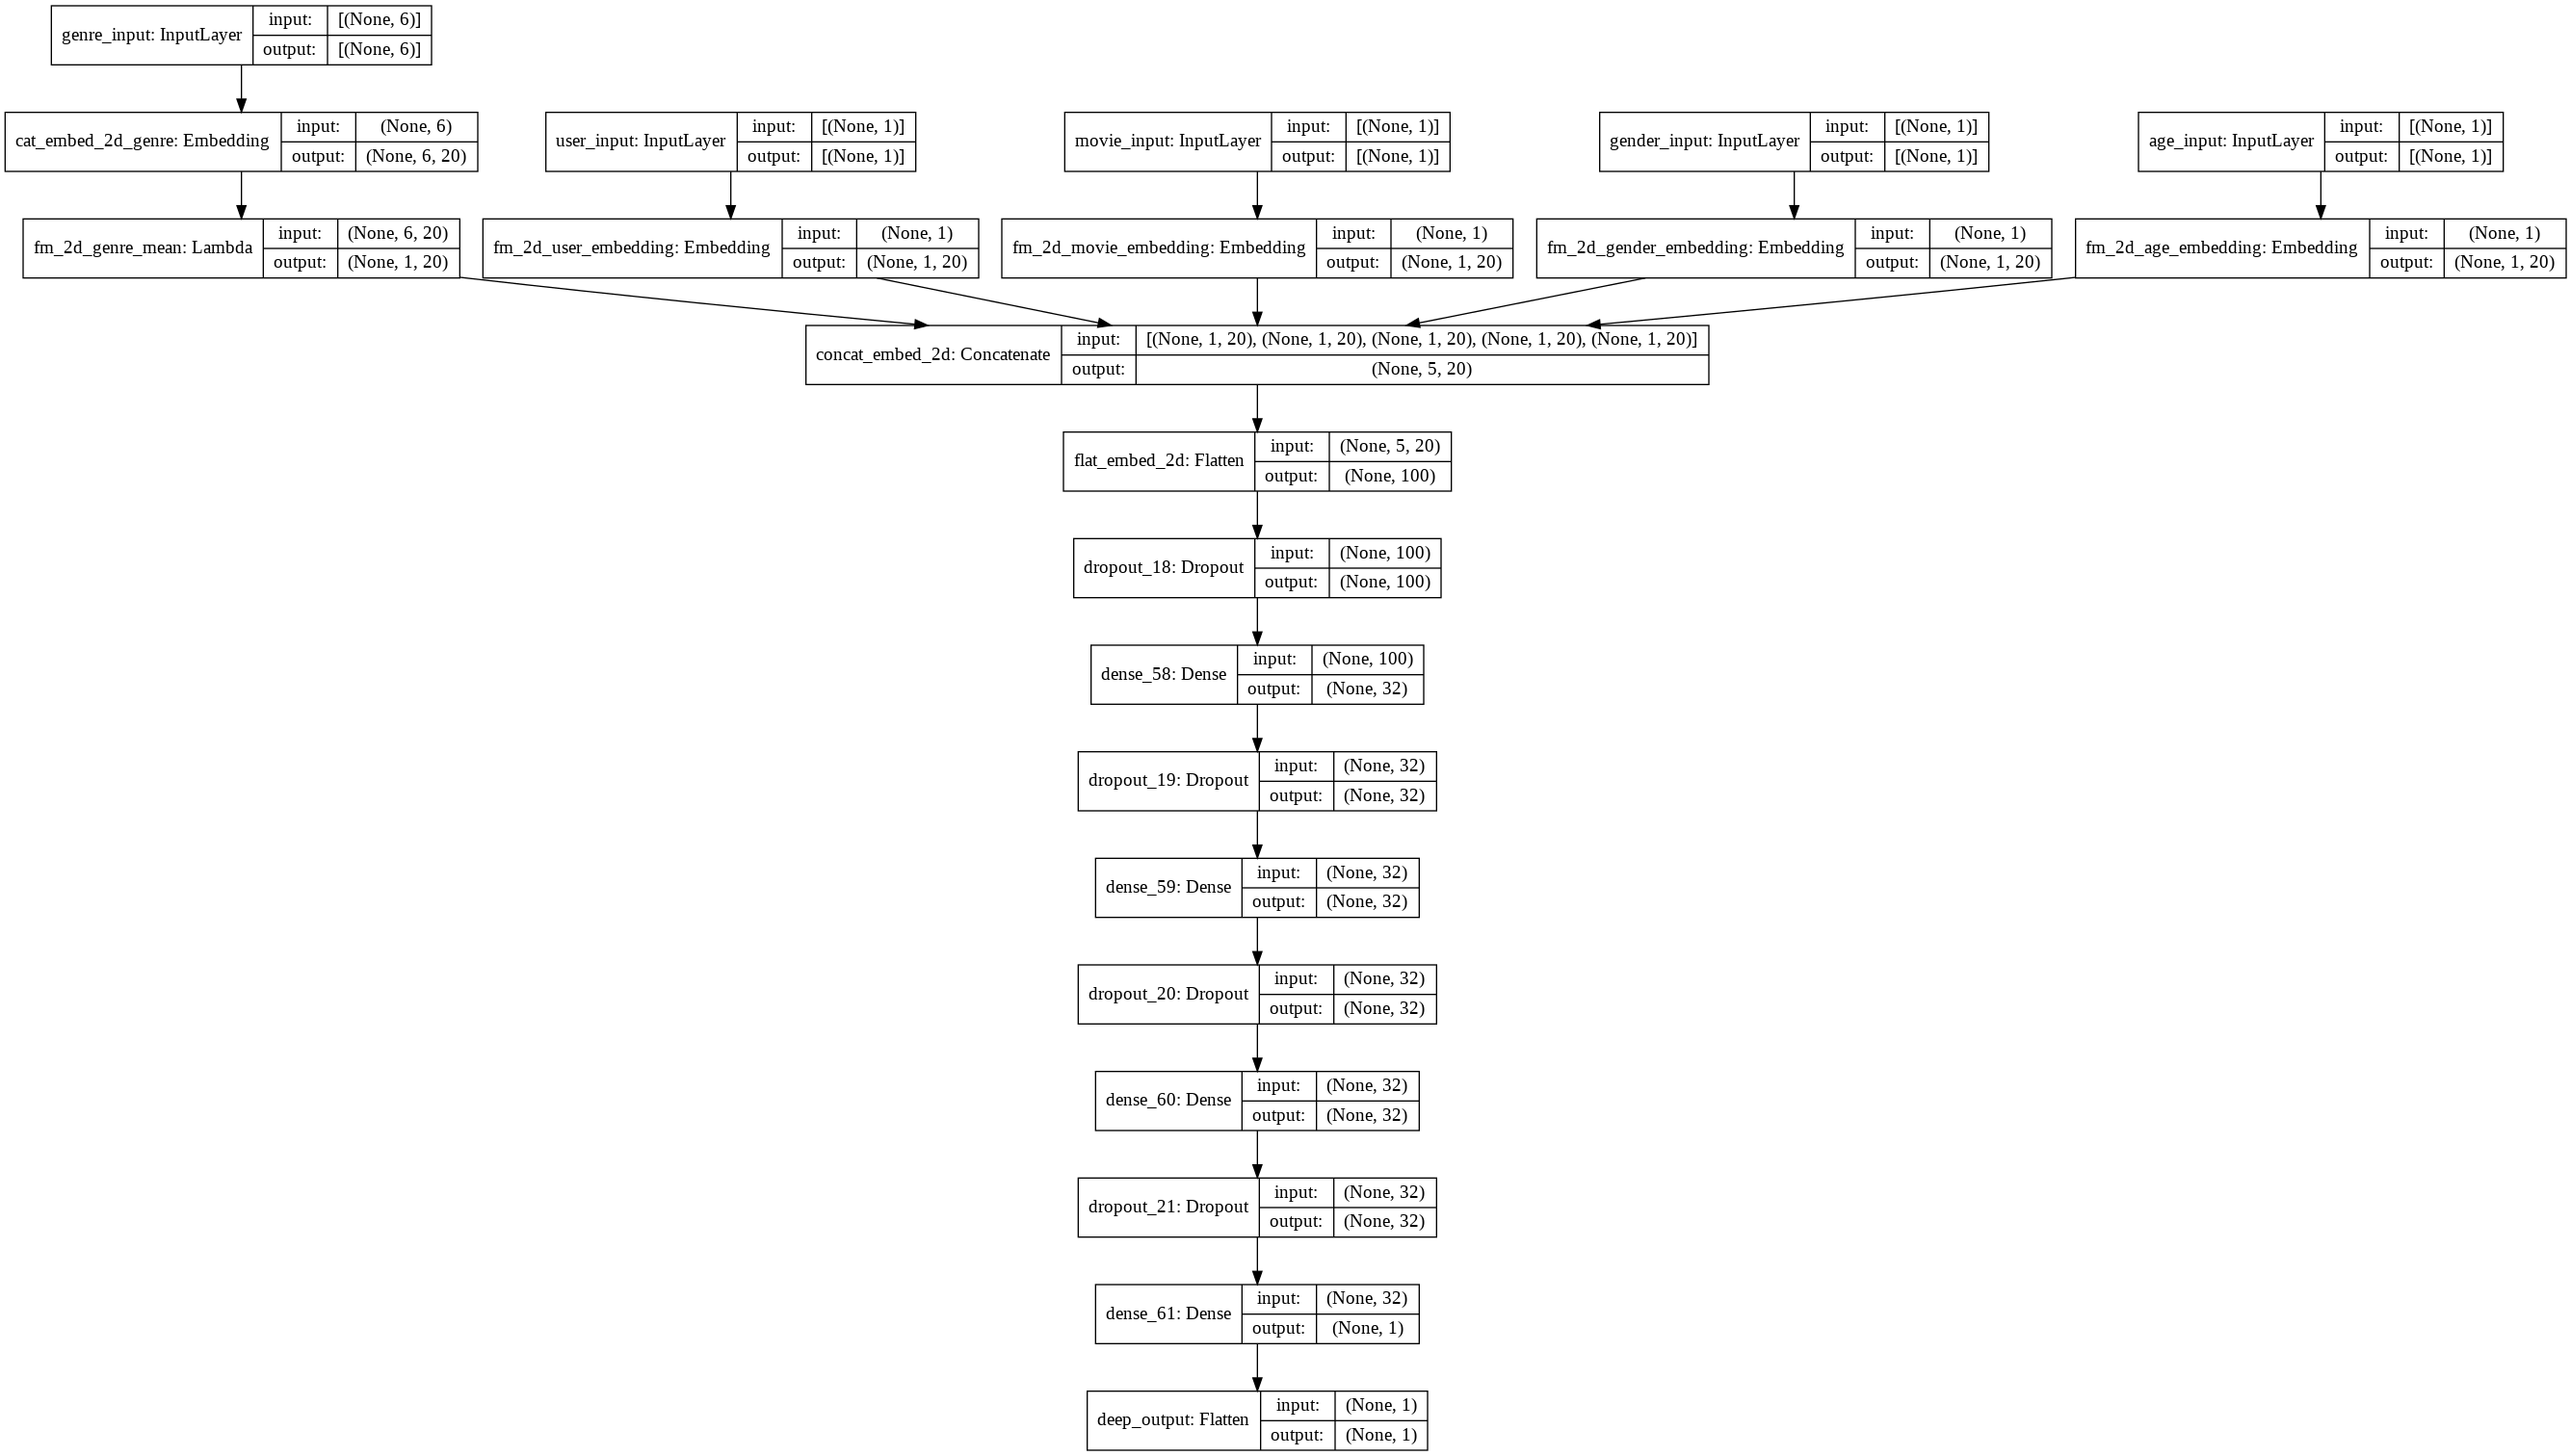

In [ ]:
plot_model(deep_model, "deepfm_dnn.png", show_shapes=True)

DeepFM model full plot

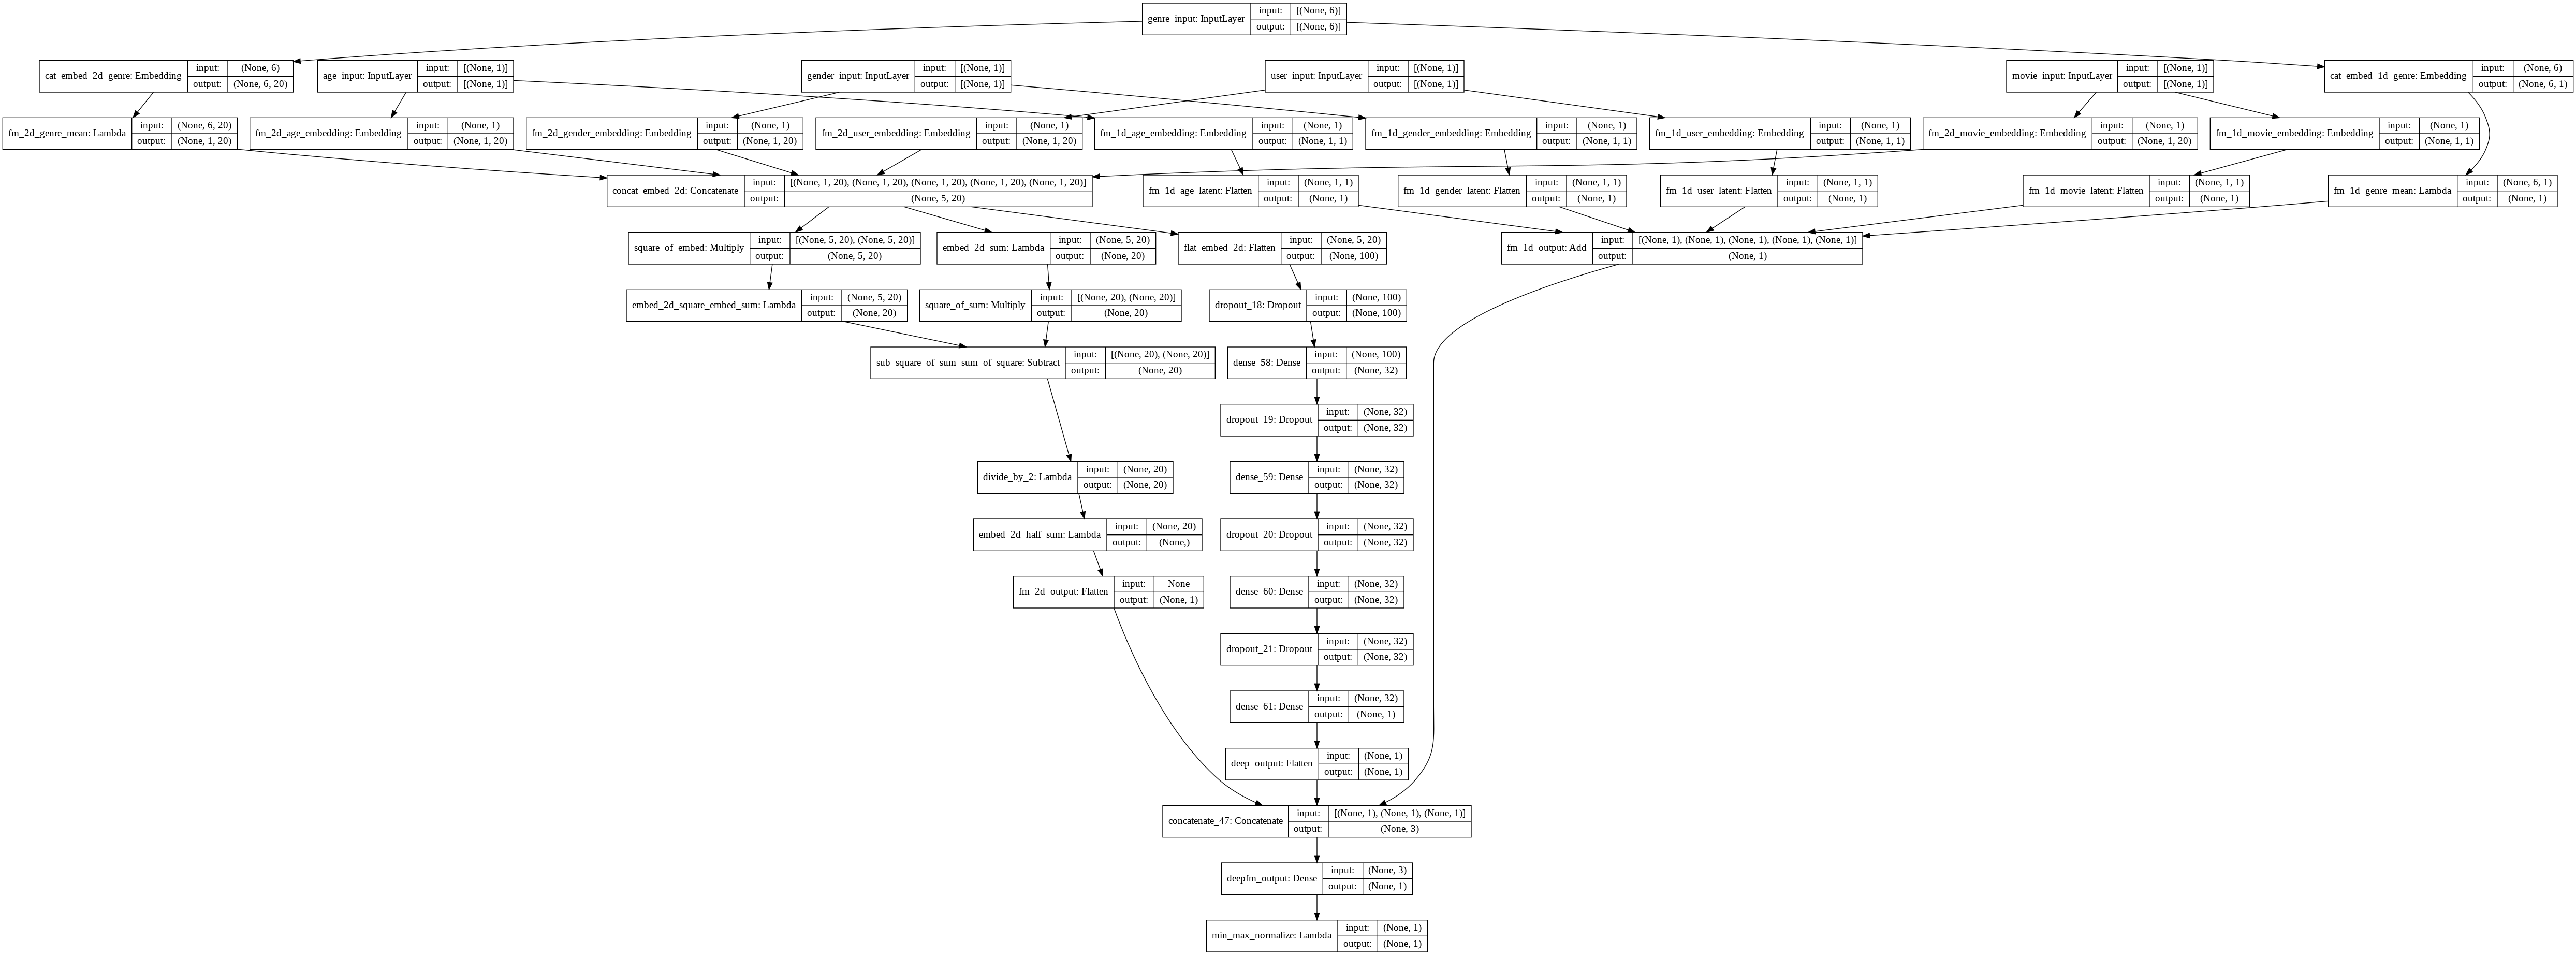

In [ ]:
plot_model(deepfm_model, "deepfm.png", show_shapes=True)

In [ ]:
deepfm_model.compile(loss='mae', optimizer=Adam(lr=0.0001), metrics=['mae', root_mean_squared_error])

In [ ]:
train_time_callback_1, callbacks = create_callbacks('deepfm_model')
deepfm_model_history = deepfm_model.fit([X_train_map['user_id'], X_train_map['movie_id'], X_train_map['genres'], X_train_map['gender'], X_train_map['age']], y_train, epochs=25, validation_split=.1, verbose=1, callbacks=callbacks, batch_size=32)

Epoch 1/25
2250/2250 [==============================] - 10s 4ms/step - loss: 1.0308 - mae: 1.0306 - root_mean_squared_error: 1.2601 - val_loss: 0.8729 - val_mae: 0.8727 - val_root_mean_squared_error: 1.0791
Epoch 2/25
2250/2250 [==============================] - 8s 3ms/step - loss: 0.8578 - mae: 0.8576 - root_mean_squared_error: 1.0818 - val_loss: 0.8476 - val_mae: 0.8474 - val_root_mean_squared_error: 1.0437
Epoch 3/25
2250/2250 [==============================] - 8s 3ms/step - loss: 0.7984 - mae: 0.7981 - root_mean_squared_error: 1.0137 - val_loss: 0.8314 - val_mae: 0.8311 - val_root_mean_squared_error: 1.0213
Epoch 4/25
2250/2250 [==============================] - 8s 3ms/step - loss: 0.7653 - mae: 0.7651 - root_mean_squared_error: 0.9791 - val_loss: 0.8207 - val_mae: 0.8205 - val_root_mean_squared_error: 1.0069
Epoch 5/25
2250/2250 [==============================] - 8s 3ms/step - loss: 0.7438 - mae: 0.7436 - root_mean_squared_error: 0.9536 - val_loss: 0.8155 - val_mae: 0.8153 - val_r

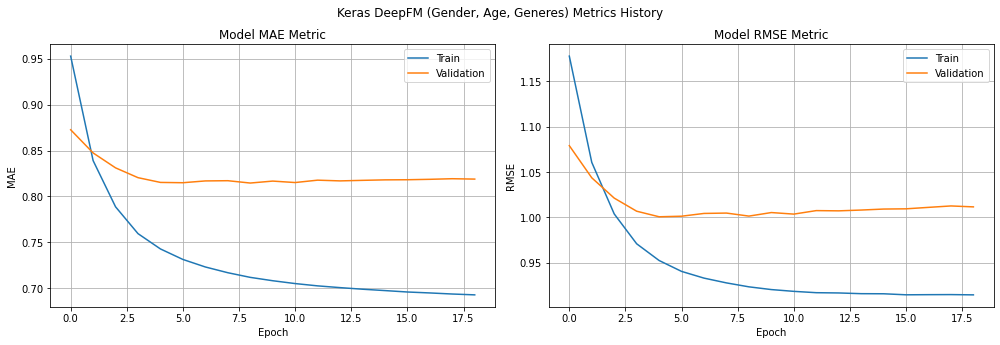

In [ ]:
plot_history(deepfm_model_history, plot_title='Keras DeepFM (Gender, Age, Generes)')

In [ ]:
loss_metrics = deepfm_model.evaluate([X_test_map['user_id'], X_test_map['movie_id'], X_test_map['genres'], X_test_map['gender'], X_test_map['age']], y_test)
_, deepfm_model_mae, deepfm_model_rmse = loss_metrics

print(f'MAE: {deepfm_model_mae}')
print(f'RMSE: {deepfm_model_rmse}')

625/625 [==============================] - 1s 2ms/step - loss: 0.7534 - mae: 0.7530 - root_mean_squared_error: 0.9631
MAE: 0.7530499696731567
RMSE: 0.9630998969078064


In [ ]:
prediction = deepfm_model.predict([X_test_map['user_id'], X_test_map['movie_id'], X_test_map['genres'], X_test_map['gender'], X_test_map['age']], batch_size=20)
test_pred = ratings_test.assign(rating_pred=prediction)
test_pred

user_id  movie_id  rating  unix_timestamp  rating_pred
0            0         5       5       887431973     3.605712
1            0         9       3       875693118     4.173556
2            0        11       5       878542960     4.822255
3            0        13       5       874965706     4.176426
4            0        16       3       875073198     3.423254
...        ...       ...     ...             ...          ...
19995      457       647       4       886395899     3.942675
19996      457      1100       4       886397931     3.942984
19997      458       933       3       879563639     2.638029
19998      459         9       3       882912371     3.205859
19999      461       681       5       886365231     3.969927

[20000 rows x 5 columns]

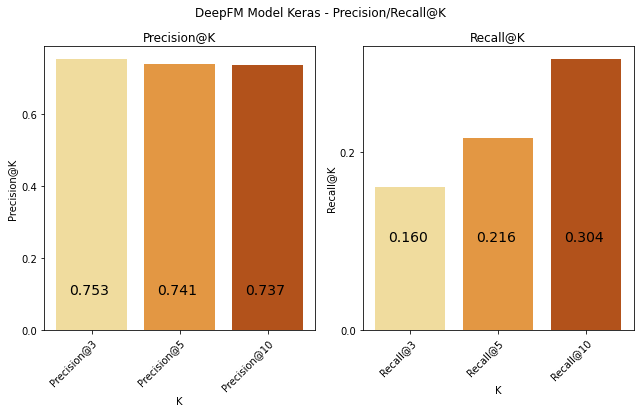

In [ ]:
mprk_deepfm_keras = plot_model_precision_recall_at_k(test_pred, k=[3, 5, 10], plot_title='DeepFM Model Keras')

#### DeepCTR DeepFM model
Extra user features:
- Age
- Gender

Extra Movie features:
- Genres

In [ ]:
def create_deepfm_ctr_model(fixlen_feature_columns, varlen_feature_columns):
  linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
  dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns

  feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

  model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')
  model.compile(loss='mae', optimizer=Adam(lr=0.0001), metrics=['mae', root_mean_squared_error])
  return model, feature_names

In [ ]:
fixlen_feature_columns = [SparseFeat("user_id", rating_user_count, embedding_dim=20),
                          SparseFeat("movie_id", rated_movie_count, embedding_dim=20),
                          SparseFeat("gender", 2, embedding_dim=20),
                          SparseFeat("age", max_age, embedding_dim=20)]

varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres',vocabulary_size=num_generes, embedding_dim=20), maxlen=max_movie_genres, combiner='mean', weight_name=None)]  # Notice : value 0 is for padding for sequence input feature

deepfm_ctr_model_1, feature_names = create_deepfm_ctr_model(fixlen_feature_columns, varlen_feature_columns)
train_input = {name:X_train_map[name] for name in feature_names}

train_time_callback_2, callbacks = create_callbacks('deepfm_ctr_model')
deepfm_ctr_model_1_history = deepfm_ctr_model_1.fit(train_input, y_train, batch_size=32, epochs=25, verbose=1, validation_split=0.1, callbacks=callbacks )

Epoch 1/25
2250/2250 [==============================] - 11s 4ms/step - loss: 1.4657 - mae: 1.4656 - root_mean_squared_error: 1.6716 - val_loss: 0.8260 - val_mae: 0.8259 - val_root_mean_squared_error: 0.9961
Epoch 2/25
2250/2250 [==============================] - 8s 4ms/step - loss: 0.7343 - mae: 0.7342 - root_mean_squared_error: 0.9411 - val_loss: 0.8191 - val_mae: 0.8190 - val_root_mean_squared_error: 0.9903
Epoch 3/25
2250/2250 [==============================] - 9s 4ms/step - loss: 0.7234 - mae: 0.7233 - root_mean_squared_error: 0.9293 - val_loss: 0.8077 - val_mae: 0.8076 - val_root_mean_squared_error: 0.9855
Epoch 4/25
2250/2250 [==============================] - 9s 4ms/step - loss: 0.7245 - mae: 0.7244 - root_mean_squared_error: 0.9330 - val_loss: 0.8098 - val_mae: 0.8097 - val_root_mean_squared_error: 0.9846
Epoch 5/25
2250/2250 [==============================] - 9s 4ms/step - loss: 0.7184 - mae: 0.7184 - root_mean_squared_error: 0.9285 - val_loss: 0.8066 - val_mae: 0.8065 - val_r

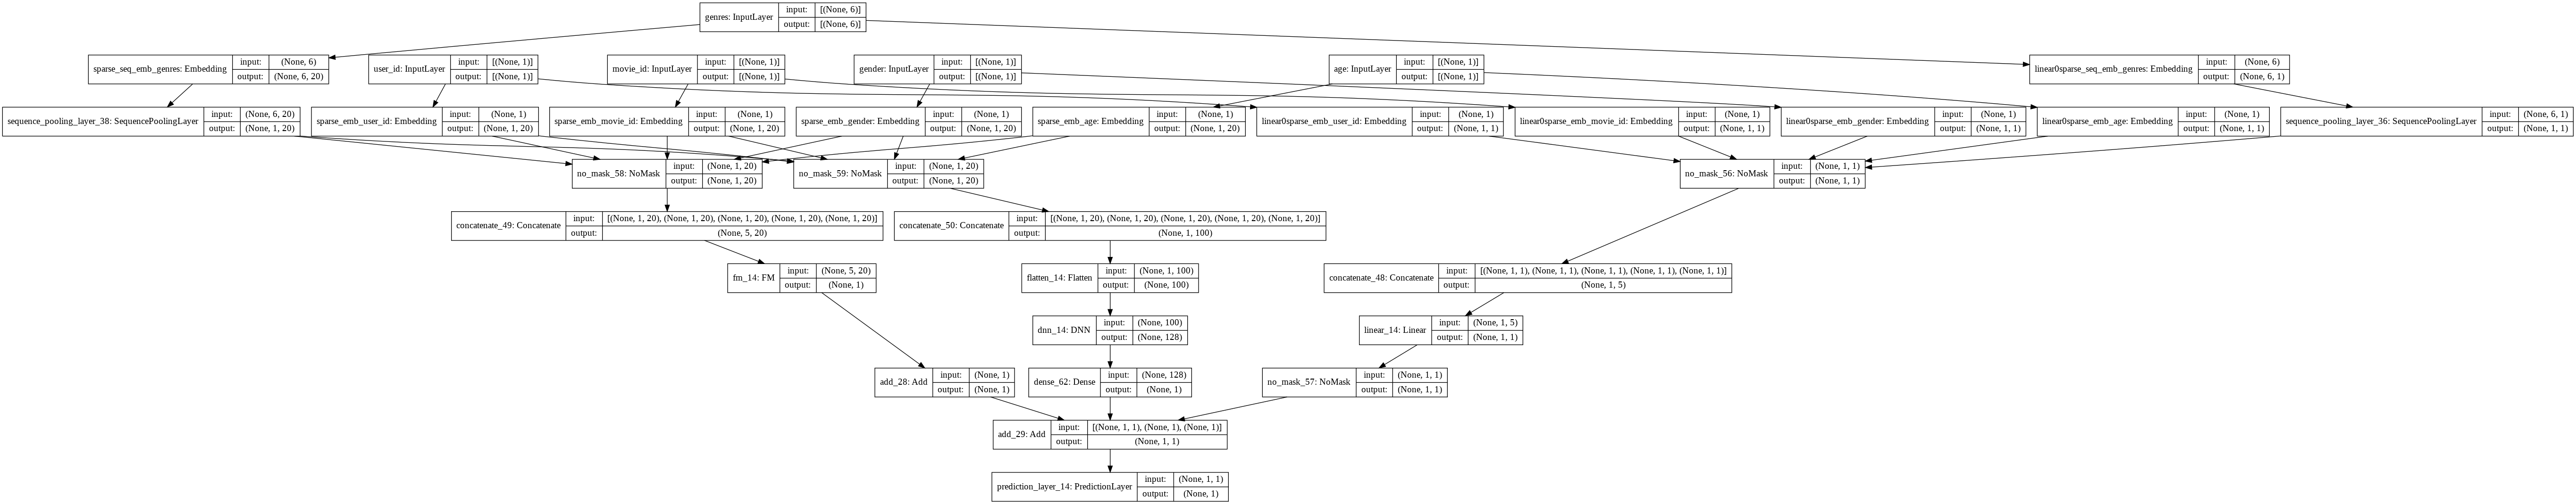

In [ ]:
plot_model(deepfm_ctr_model_1, "deepfm_ctr.png", show_shapes=True)

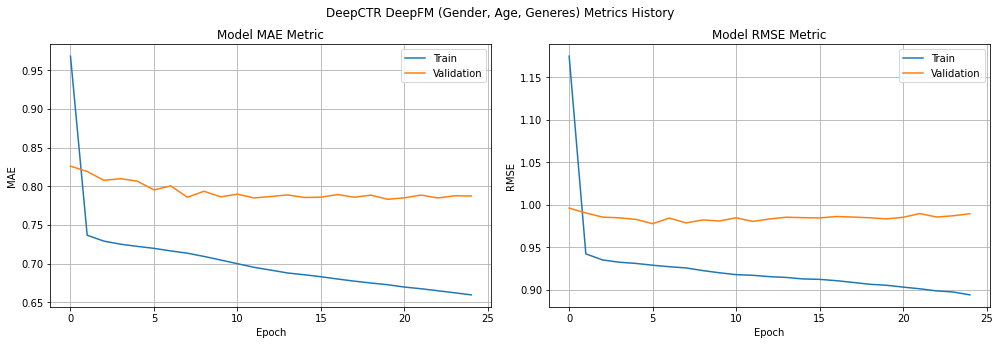

In [ ]:
plot_history(deepfm_ctr_model_1_history, plot_title='DeepCTR DeepFM (Gender, Age, Generes)')

In [ ]:
test_input = {name:X_test_map[name] for name in feature_names}
loss_metrics = deepfm_ctr_model_1.evaluate(test_input, y_test)
_, deepfm_ctr_model_1_mae, deepfm_ctr_model_1_rmse = loss_metrics

print(f'MAE: {deepfm_ctr_model_1_mae}')
print(f'RMSE: {deepfm_ctr_model_1_rmse}')

625/625 [==============================] - 1s 2ms/step - loss: 0.7302 - mae: 0.7298 - root_mean_squared_error: 0.9550
MAE: 0.7297515869140625
RMSE: 0.9549513459205627


In [ ]:
prediction = deepfm_ctr_model_1.predict(test_input, batch_size=20)
test_pred = ratings_test.assign(rating_pred=prediction)
test_pred

user_id  movie_id  rating  unix_timestamp  rating_pred
0            0         5       5       887431973     4.128789
1            0         9       3       875693118     4.801704
2            0        11       5       878542960     4.861095
3            0        13       5       874965706     4.861135
4            0        16       3       875073198     3.233257
...        ...       ...     ...             ...          ...
19995      457       647       4       886395899     4.004219
19996      457      1100       4       886397931     4.071216
19997      458       933       3       879563639     3.239141
19998      459         9       3       882912371     4.124553
19999      461       681       5       886365231     3.927983

[20000 rows x 5 columns]

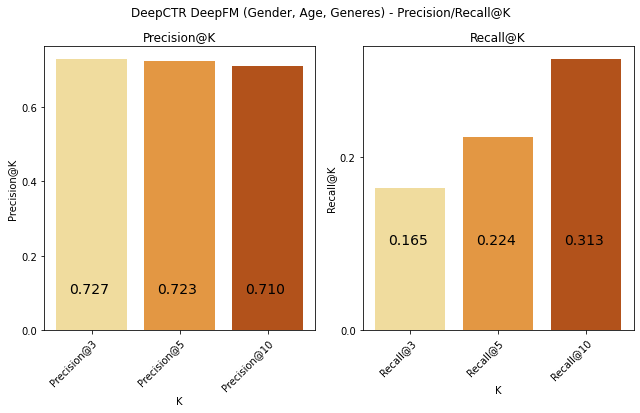

In [ ]:
mprk_deepfm_ctr_1 = plot_model_precision_recall_at_k(test_pred, k=[3, 5, 10], plot_title='DeepCTR DeepFM (Gender, Age, Generes)')

## Section 5.c.

We will try diffrent combination of user and movie features to see what works best.

Use DeepCTR DeepFM model and ignore users age

In [ ]:
fixlen_feature_columns = [SparseFeat("user_id", rating_user_count, embedding_dim=20),
                          SparseFeat("movie_id", rated_movie_count, embedding_dim=20),
                          SparseFeat("gender", 2, embedding_dim=20)]

varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres',vocabulary_size=num_generes, embedding_dim=20), maxlen=max_movie_genres, combiner='mean', weight_name=None)]  # Notice : value 0 is for padding for sequence input feature

deepfm_ctr_model_2, feature_names = create_deepfm_ctr_model(fixlen_feature_columns, varlen_feature_columns)
train_input = {name:X_train_map[name] for name in feature_names}

train_time_callback_3, callbacks = create_callbacks('deepfm_ctr_model')
deepfm_ctr_model_2_history = deepfm_ctr_model_2.fit(train_input, y_train, batch_size=32, epochs=25, verbose=1, validation_split=0.1, callbacks=callbacks )

Epoch 1/25
2250/2250 [==============================] - 10s 4ms/step - loss: 1.4665 - mae: 1.4665 - root_mean_squared_error: 1.6690 - val_loss: 0.8365 - val_mae: 0.8365 - val_root_mean_squared_error: 1.0023
Epoch 2/25
2250/2250 [==============================] - 8s 4ms/step - loss: 0.7315 - mae: 0.7315 - root_mean_squared_error: 0.9371 - val_loss: 0.8381 - val_mae: 0.8381 - val_root_mean_squared_error: 1.0014
Epoch 3/25
2250/2250 [==============================] - 8s 4ms/step - loss: 0.7228 - mae: 0.7228 - root_mean_squared_error: 0.9309 - val_loss: 0.8161 - val_mae: 0.8160 - val_root_mean_squared_error: 0.9862
Epoch 4/25
2250/2250 [==============================] - 8s 4ms/step - loss: 0.7199 - mae: 0.7198 - root_mean_squared_error: 0.9288 - val_loss: 0.7976 - val_mae: 0.7976 - val_root_mean_squared_error: 0.9744
Epoch 5/25
2250/2250 [==============================] - 8s 4ms/step - loss: 0.7183 - mae: 0.7182 - root_mean_squared_error: 0.9283 - val_loss: 0.7925 - val_mae: 0.7925 - val_r

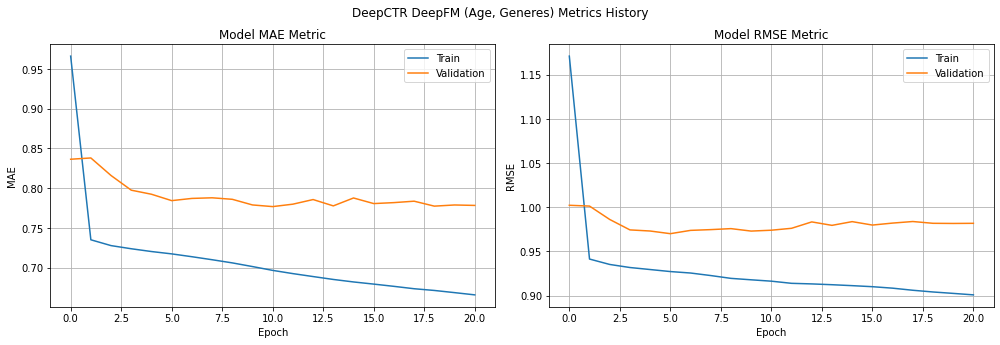

In [ ]:
plot_history(deepfm_ctr_model_2_history, plot_title='DeepCTR DeepFM (Age, Generes)')

In [ ]:
test_input = {name:X_test_map[name] for name in feature_names}
loss_metrics = deepfm_ctr_model_2.evaluate(test_input, y_test)
_, deepfm_ctr_model_2_mae, deepfm_ctr_model_2_rmse = loss_metrics

print(f'MAE: {deepfm_ctr_model_2_mae}')
print(f'RMSE: {deepfm_ctr_model_2_rmse}')

625/625 [==============================] - 1s 2ms/step - loss: 0.7321 - mae: 0.7318 - root_mean_squared_error: 0.9596
MAE: 0.7317923903465271
RMSE: 0.9596238136291504


In [ ]:
prediction = deepfm_ctr_model_2.predict(test_input, batch_size=20)
test_pred = ratings_test.assign(rating_pred=prediction)
test_pred

user_id  movie_id  rating  unix_timestamp  rating_pred
0            0         5       5       887431973     4.238823
1            0         9       3       875693118     4.370886
2            0        11       5       878542960     4.997692
3            0        13       5       874965706     4.890097
4            0        16       3       875073198     3.281315
...        ...       ...     ...             ...          ...
19995      457       647       4       886395899     4.023106
19996      457      1100       4       886397931     4.053744
19997      458       933       3       879563639     3.347976
19998      459         9       3       882912371     3.686494
19999      461       681       5       886365231     3.819952

[20000 rows x 5 columns]

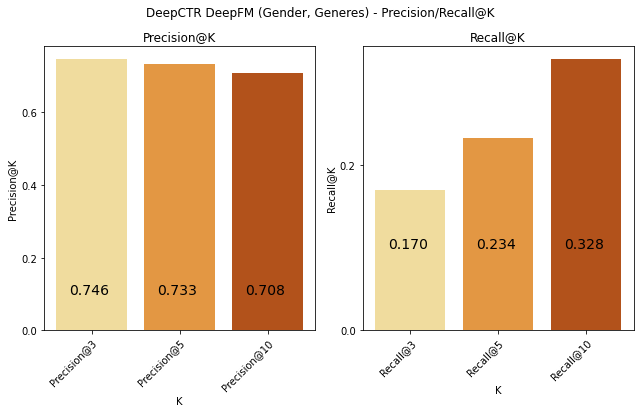

In [ ]:
mprk_deepfm_ctr_2 = plot_model_precision_recall_at_k(test_pred, k=[3, 5, 10], plot_title='DeepCTR DeepFM (Gender, Generes)')

Ignore movie categorical genre data

In [ ]:
fixlen_feature_columns = [SparseFeat("user_id", rating_user_count, embedding_dim=20),
                          SparseFeat("movie_id", rated_movie_count, embedding_dim=20),
                          SparseFeat("gender", 2, embedding_dim=20),
                          SparseFeat("age", max_age, embedding_dim=20)]

varlen_feature_columns = []

deepfm_ctr_model_3, feature_names = create_deepfm_ctr_model(fixlen_feature_columns, varlen_feature_columns)
train_input = {name:X_train_map[name] for name in feature_names}

train_time_callback_4, callbacks = create_callbacks('deepfm_ctr_model')
deepfm_ctr_model_3_history = deepfm_ctr_model_3.fit(train_input, y_train, batch_size=32, epochs=25, verbose=1, validation_split=0.1, callbacks=callbacks )

Epoch 1/25
2250/2250 [==============================] - 10s 4ms/step - loss: 1.5035 - mae: 1.5035 - root_mean_squared_error: 1.7045 - val_loss: 0.8404 - val_mae: 0.8403 - val_root_mean_squared_error: 1.0099
Epoch 2/25
2250/2250 [==============================] - 8s 4ms/step - loss: 0.7330 - mae: 0.7329 - root_mean_squared_error: 0.9386 - val_loss: 0.8322 - val_mae: 0.8321 - val_root_mean_squared_error: 1.0006
Epoch 3/25
2250/2250 [==============================] - 8s 4ms/step - loss: 0.7224 - mae: 0.7224 - root_mean_squared_error: 0.9303 - val_loss: 0.8375 - val_mae: 0.8375 - val_root_mean_squared_error: 1.0054
Epoch 4/25
2250/2250 [==============================] - 8s 4ms/step - loss: 0.7209 - mae: 0.7208 - root_mean_squared_error: 0.9286 - val_loss: 0.8244 - val_mae: 0.8243 - val_root_mean_squared_error: 0.9979
Epoch 5/25
2250/2250 [==============================] - 8s 4ms/step - loss: 0.7142 - mae: 0.7141 - root_mean_squared_error: 0.9226 - val_loss: 0.8011 - val_mae: 0.8010 - val_r

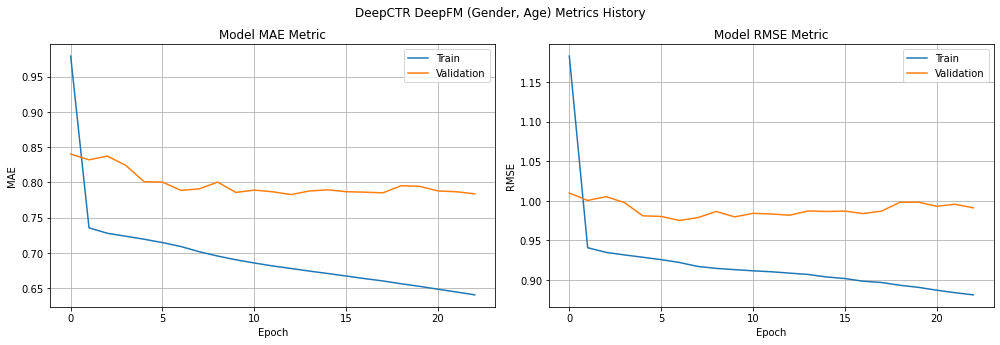

In [ ]:
plot_history(deepfm_ctr_model_3_history, plot_title='DeepCTR DeepFM (Gender, Age)')

In [ ]:
test_input = {name:X_test_map[name] for name in feature_names}
loss_metrics = deepfm_ctr_model_3.evaluate(test_input, y_test)
_, deepfm_ctr_model_3_mae, deepfm_ctr_model_3_rmse = loss_metrics

print(f'MAE: {deepfm_ctr_model_3_mae}')
print(f'RMSE: {deepfm_ctr_model_3_rmse}')

625/625 [==============================] - 1s 2ms/step - loss: 0.7281 - mae: 0.7277 - root_mean_squared_error: 0.9552
MAE: 0.7276912927627563
RMSE: 0.9552035927772522


In [ ]:
prediction = deepfm_ctr_model_3.predict(test_input, batch_size=20)
test_pred = ratings_test.assign(rating_pred=prediction)
test_pred

user_id  movie_id  rating  unix_timestamp  rating_pred
0            0         5       5       887431973     4.140345
1            0         9       3       875693118     4.304011
2            0        11       5       878542960     4.887478
3            0        13       5       874965706     4.629174
4            0        16       3       875073198     2.993731
...        ...       ...     ...             ...          ...
19995      457       647       4       886395899     4.032073
19996      457      1100       4       886397931     3.980045
19997      458       933       3       879563639     3.280157
19998      459         9       3       882912371     3.728464
19999      461       681       5       886365231     4.113528

[20000 rows x 5 columns]

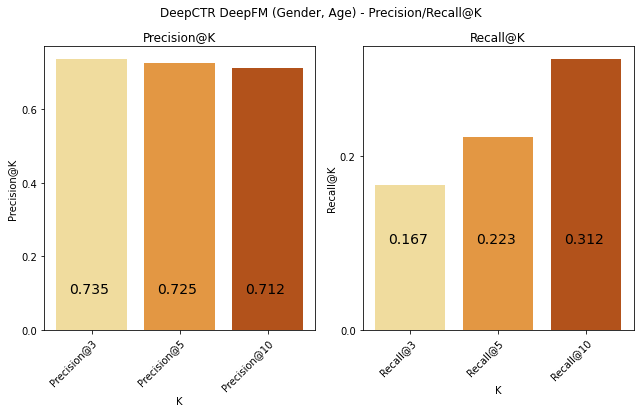

In [ ]:
mprk_deepfm_ctr_3 = plot_model_precision_recall_at_k(test_pred, k=[3, 5, 10], plot_title='DeepCTR DeepFM (Gender, Age)')

Use only movie genre data



In [ ]:
fixlen_feature_columns = [SparseFeat("user_id", rating_user_count, embedding_dim=20),
                          SparseFeat("movie_id", rated_movie_count, embedding_dim=20)]

varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres',vocabulary_size=num_generes, embedding_dim=20), maxlen=max_movie_genres, combiner='mean', weight_name=None)]  # Notice : value 0 is for padding for sequence input feature

deepfm_ctr_model_4, feature_names = create_deepfm_ctr_model(fixlen_feature_columns, varlen_feature_columns)
train_input = {name:X_train_map[name] for name in feature_names}

train_time_callback_5, callbacks = create_callbacks('deepfm_ctr_model')
deepfm_ctr_model_4_history = deepfm_ctr_model_4.fit(train_input, y_train, batch_size=32, epochs=25, verbose=1, validation_split=0.1, callbacks=callbacks )

Epoch 1/25
2250/2250 [==============================] - 10s 4ms/step - loss: 1.5556 - mae: 1.5556 - root_mean_squared_error: 1.7565 - val_loss: 0.8374 - val_mae: 0.8373 - val_root_mean_squared_error: 1.0034
Epoch 2/25
2250/2250 [==============================] - 8s 4ms/step - loss: 0.7335 - mae: 0.7335 - root_mean_squared_error: 0.9405 - val_loss: 0.8659 - val_mae: 0.8659 - val_root_mean_squared_error: 1.0281
Epoch 3/25
2250/2250 [==============================] - 8s 4ms/step - loss: 0.7258 - mae: 0.7258 - root_mean_squared_error: 0.9341 - val_loss: 0.8260 - val_mae: 0.8259 - val_root_mean_squared_error: 0.9931
Epoch 4/25
2250/2250 [==============================] - 8s 4ms/step - loss: 0.7211 - mae: 0.7211 - root_mean_squared_error: 0.9307 - val_loss: 0.8117 - val_mae: 0.8116 - val_root_mean_squared_error: 0.9848
Epoch 5/25
2250/2250 [==============================] - 8s 4ms/step - loss: 0.7191 - mae: 0.7190 - root_mean_squared_error: 0.9293 - val_loss: 0.8133 - val_mae: 0.8132 - val_r

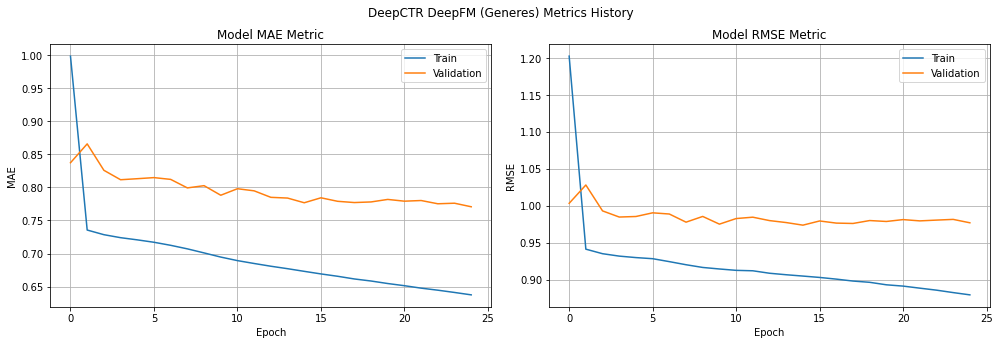

In [ ]:
plot_history(deepfm_ctr_model_4_history, plot_title='DeepCTR DeepFM (Generes)')

In [ ]:
test_input = {name:X_test_map[name] for name in feature_names}
loss_metrics = deepfm_ctr_model_4.evaluate(test_input, y_test)
_, deepfm_ctr_model_4_mae, deepfm_ctr_model_4_rmse = loss_metrics

print(f'MAE: {deepfm_ctr_model_4_mae}')
print(f'RMSE: {deepfm_ctr_model_4_rmse}')

625/625 [==============================] - 1s 2ms/step - loss: 0.7285 - mae: 0.7281 - root_mean_squared_error: 0.9581
MAE: 0.7281006574630737
RMSE: 0.9581118226051331


In [ ]:
prediction = deepfm_ctr_model_4.predict(test_input, batch_size=20)
test_pred = ratings_test.assign(rating_pred=prediction)
test_pred

user_id  movie_id  rating  unix_timestamp  rating_pred
0            0         5       5       887431973     5.061394
1            0         9       3       875693118     4.513389
2            0        11       5       878542960     4.991316
3            0        13       5       874965706     4.792376
4            0        16       3       875073198     3.545493
...        ...       ...     ...             ...          ...
19995      457       647       4       886395899     4.004834
19996      457      1100       4       886397931     3.993174
19997      458       933       3       879563639     3.259114
19998      459         9       3       882912371     3.994706
19999      461       681       5       886365231     3.985984

[20000 rows x 5 columns]

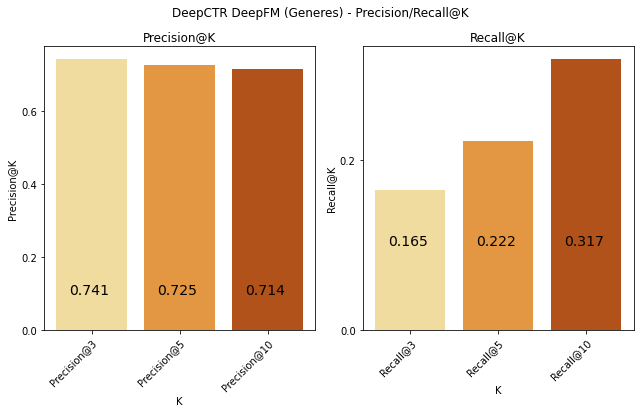

In [ ]:
mprk_deepfm_ctr_4 = plot_model_precision_recall_at_k(test_pred, k=[3, 5, 10], plot_title='DeepCTR DeepFM (Generes)')

## Section 5.d.

DeepFM models comparison

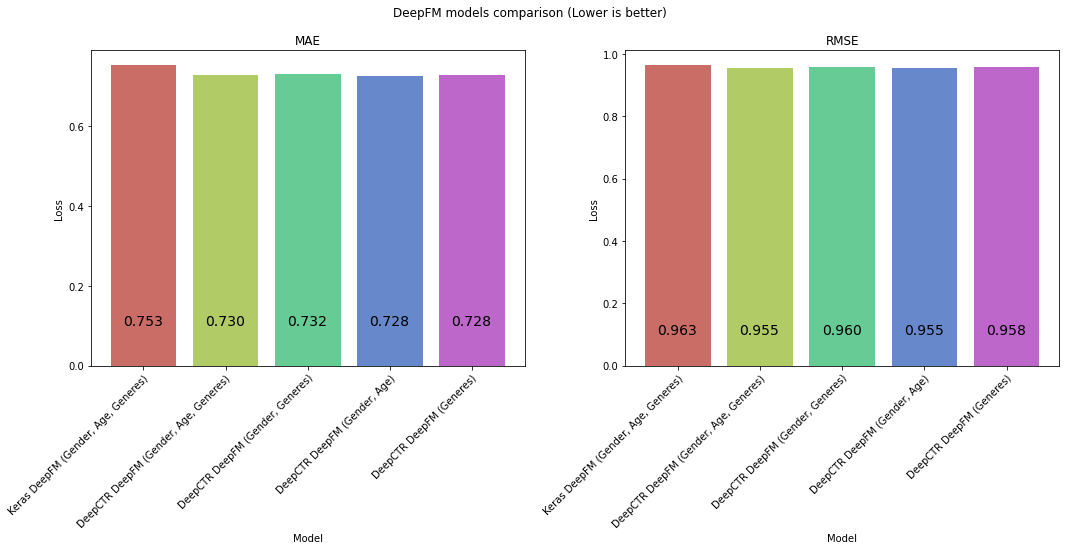

In [ ]:
plot_model_loss_comparison(losses={'Keras DeepFM (Gender, Age, Generes)': {'mae': deepfm_model_mae, 'rmse': deepfm_model_rmse},
                                   'DeepCTR DeepFM (Gender, Age, Generes)': {'mae': deepfm_ctr_model_1_mae, 'rmse': deepfm_ctr_model_1_rmse},
                                   'DeepCTR DeepFM (Gender, Generes)': {'mae': deepfm_ctr_model_2_mae, 'rmse': deepfm_ctr_model_2_rmse},
                                    'DeepCTR DeepFM (Gender, Age)': {'mae': deepfm_ctr_model_3_mae, 'rmse': deepfm_ctr_model_3_rmse},
                                    'DeepCTR DeepFM (Generes)': {'mae': deepfm_ctr_model_4_mae, 'rmse': deepfm_ctr_model_4_rmse},
                                   },
                            plot_title='DeepFM models comparison', high=True)

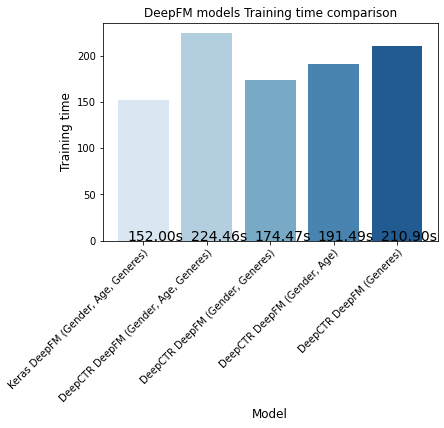

In [ ]:
plot_model_train_time_comparison(times={'Keras DeepFM (Gender, Age, Generes)': train_time_callback_1.train_time_end,
                                      'DeepCTR DeepFM (Gender, Age, Generes)': train_time_callback_2.train_time_end,
                                      'DeepCTR DeepFM (Gender, Generes)': train_time_callback_3.train_time_end,
                                      'DeepCTR DeepFM (Gender, Age)': train_time_callback_4.train_time_end,
                                      'DeepCTR DeepFM (Generes)': train_time_callback_5.train_time_end,}, plot_title='DeepFM models Training time comparison')

## Section 5.e.

Overall models comparison

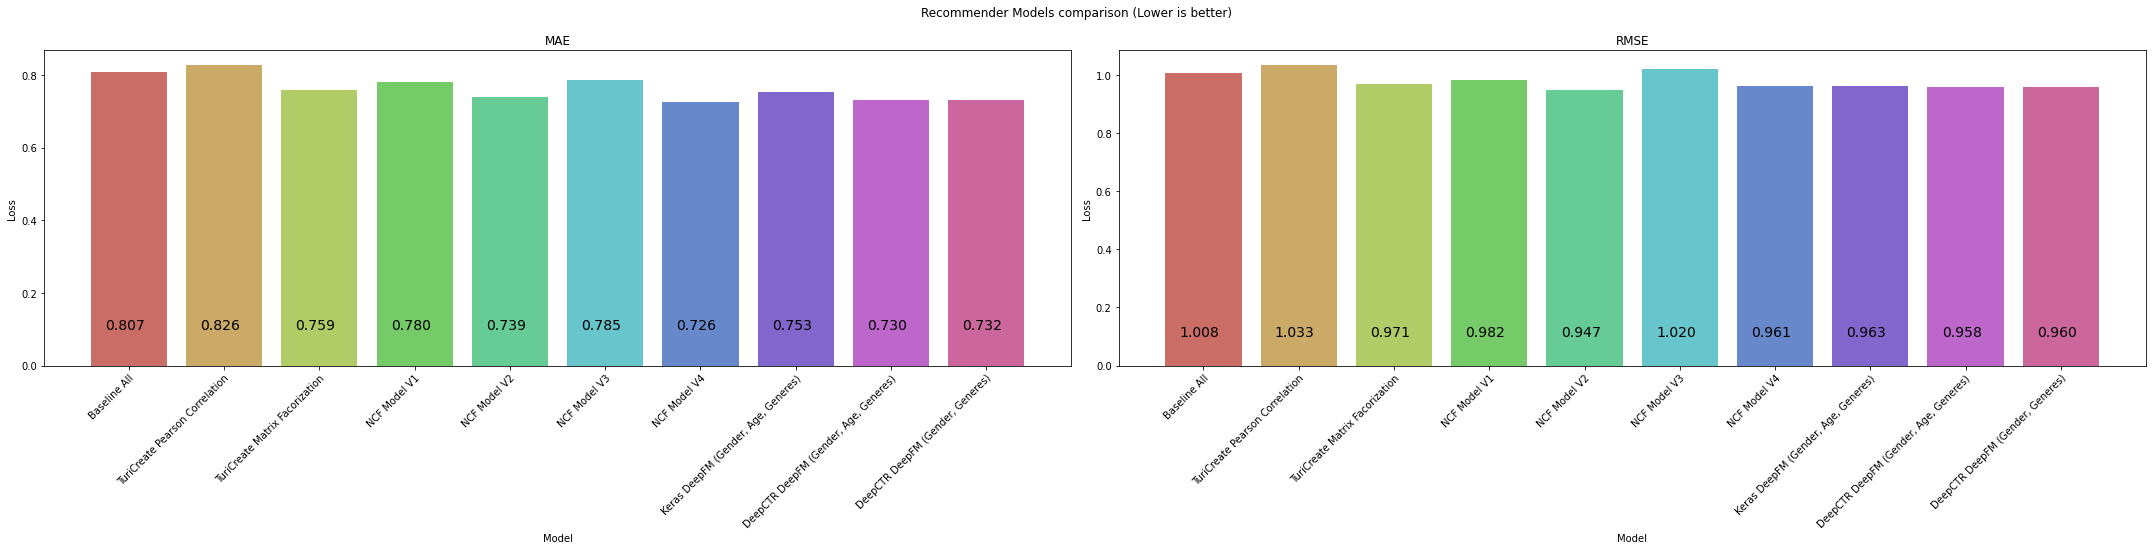

In [ ]:
plot_model_loss_comparison(losses={'Baseline All': {'mae': basemodel_loss["MAE"], 'rmse': basemodel_loss["RMSE"]},
                                   'TuriCreate Pearson Correlation': {'mae': mae(test_data["rating"], y_pred_pearson), 'rmse': rmse(np.array(test_data["rating"]), np.array(y_pred_pearson))},
                                   'TuriCreate Matrix Facorization': {'mae': mae(test_data["rating"], y_pred_mf), 'rmse': rmse(np.array(test_data["rating"]), np.array(y_pred_mf))},
                                    'NCF Model V1': {'mae': loss_metrics_ncf_1[1], 'rmse': loss_metrics_ncf_1[2]},
                                    'NCF Model V2': {'mae': loss_metrics_ncf_2[1], 'rmse': loss_metrics_ncf_2[2]},
                                    'NCF Model V3': {'mae': loss_metrics_ncf_3[1], 'rmse': loss_metrics_ncf_3[2]},
                                    'NCF Model V4': {'mae': loss_metrics_ncf_4[1], 'rmse': loss_metrics_ncf_4[2]},
                                    'Keras DeepFM (Gender, Age, Generes)': {'mae': deepfm_model_mae, 'rmse': deepfm_model_rmse},
                                    'DeepCTR DeepFM (Gender, Age, Generes)': {'mae': deepfm_ctr_model_1_mae, 'rmse': deepfm_ctr_model_4_rmse},
                                    'DeepCTR DeepFM (Gender, Generes)': {'mae': deepfm_ctr_model_2_mae, 'rmse': deepfm_ctr_model_2_rmse},
                                   },
                            plot_title='Recommender Models comparison', high=True)

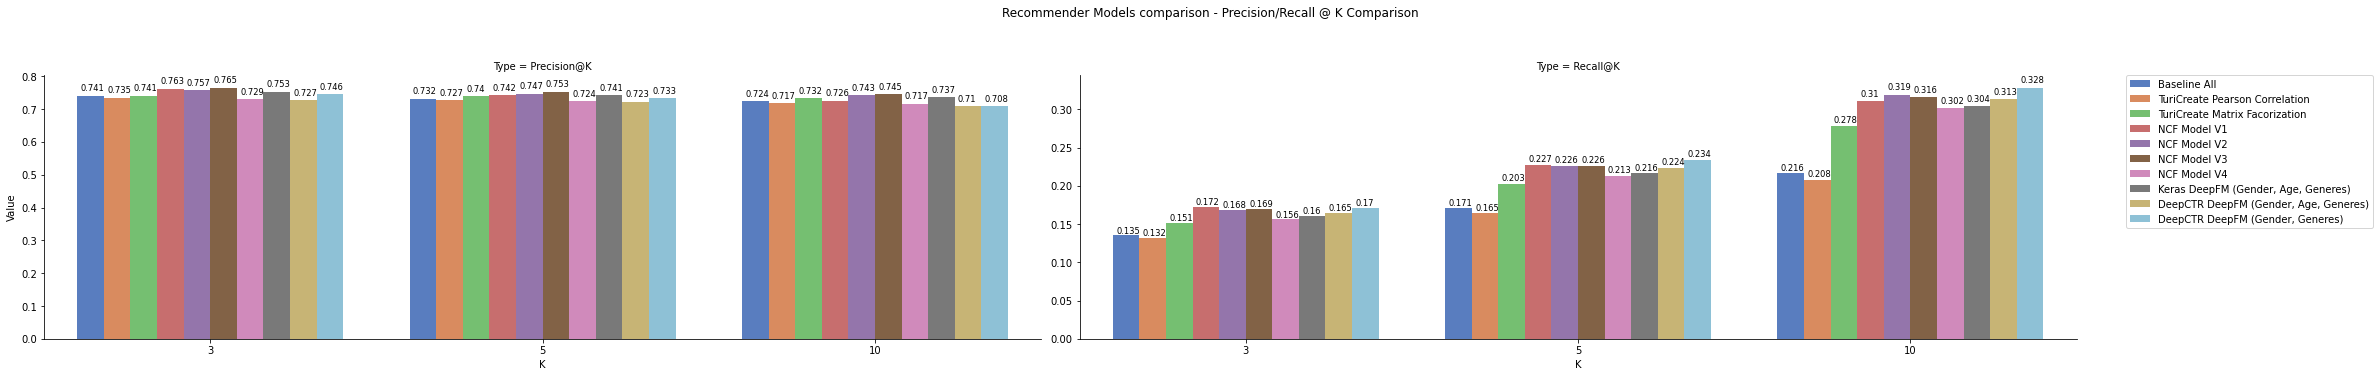

In [ ]:
plot_model_precision_recall_at_k_comparison(data={
                                      'Baseline All': mprk_baseline_all,
                                      'TuriCreate Pearson Correlation': mprk_pearson,
                                      'TuriCreate Matrix Facorization': mprk_mf,
                                      'NCF Model V1': mprk_ncf_1,
                                      'NCF Model V2': mprk_ncf_2,
                                      'NCF Model V3': mprk_ncf_3,
                                      'NCF Model V4': mprk_ncf_4,
                                      'Keras DeepFM (Gender, Age, Generes)': mprk_deepfm_keras,
                                      'DeepCTR DeepFM (Gender, Age, Generes)': mprk_deepfm_ctr_1,
                                      'DeepCTR DeepFM (Gender, Generes)': mprk_deepfm_ctr_2,
                                   },
                                    plot_title='Recommender Models comparison', wide=True)

We can see that overall the more complicated models we used have no substantial differences in terms of loss MAE/RMSE and in terms of Percision/Recall @ K, therefore, and due to the persitency over multiple runs we would recommend to use the DeepCTR based DeepFM model by using the additional features of user Gender and Movie Genres in order to predict rating for the MovieLens 100K dataset.